# Figures for "The Developmental Landscape of In-Context Learning"

All figures can be regenerated from the saved analysis files provided in the repo under `analysis/` except for essential dynamics and attention variabilities (the files are too large). The figures are saved in the `figures` folder.

In [1]:
import os
from dotenv import load_dotenv

load_dotenv();

In [2]:
import logging
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import seaborn as sns
from copy import deepcopy 
import os
import warnings
from typing import Optional

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.nn import functional as F
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from collections import defaultdict
from typing import Dict, List, Union, Iterable, Optional
from icl.analysis.hooks import hook
from torchtyping import TensorType

from infra.utils.tensors import convert_tensor
from infra.utils.tensors import ReturnTensor
from infra.utils.iterables import map_nested
from infra.utils.iterables import flatten_dict
from icl.regression.experiments.utils import iter_models
from icl.regression.train import Run
from icl.analysis.utils import get_unique_run, get_unique_config
from icl.constants import FIGURES, SWEEPS, DATA, ANALYSIS
from icl.figures.notation import str_d_dlogt, str_d_dt, str_dlog_dlogt
from icl.figures.colors import plot_transitions, gen_transition_colors, get_transition_type, PRIMARY, SECONDARY, TERTIARY, BRED, BBLUE, BRED, BGREEN
from icl.constants import DEVICE
from icl.figures.plotting import WIDTH, HEIGHT, FULL_WIDTH, FULL_HEIGHT
from icl.monitoring import stdlogger

warnings.filterwarnings('ignore')

MODELS_ID = "L2H4Minf"
LLC_SWEEP_ID = "hmy71gjb"
WANDB_ENTITY = os.getenv("WANDB_ENTITY")

In [43]:
# shorthands
BATCH_SIZE = 8192
K = 8
D = 4

runs = [get_unique_run(
    str(SWEEPS / "training-runs/L2H4Minf.yaml"), 
    task_config={"model_seed": model_seed, "layer_norm": True},
) for model_seed in range(5)]

steps = set(runs[0].checkpointer.file_ids)
steps = list(sorted(list(steps)))
num_steps = len(steps)
num_steps

190

# Retrieve checkpoints

In [4]:
all_models = []
all_optimizer_state_dicts = []

if os.path.exists(DATA / MODELS_ID / 'models.pt'):
    print(f"Loading models from disk...")
    all_models = torch.load(DATA / MODELS_ID / 'models.pt')
    all_optimizer_state_dicts = torch.load(DATA / MODELS_ID / 'optimizer_state_dicts.pt')
else:
    print(f"Retrieving models from bucket...")
    pbar = tqdm.tqdm(runs)

    for run in pbar:
        models = []
        optimizer_state_dicts = []

        for i, step in enumerate(steps):
            checkpoint = run.checkpointer.load_file(step)
            m = deepcopy(run.model)
            m.load_state_dict(checkpoint["model"])
            models.append(m)
            optimizer_state_dicts.append(checkpoint["optimizer"])

            pbar.set_description(f"Checkpoint {i}/{num_steps}")
            
        all_models.append(models)
        all_optimizer_state_dicts.append(optimizer_state_dicts)

    print(f"Saving models to disk...")
    
    with open(DATA / MODELS_ID / 'models.pt', 'wb') as f:
        torch.save(all_models, f)

    with open(DATA / MODELS_ID / 'optimizer_state_dicts.pt', 'wb') as f:
        torch.save(all_optimizer_state_dicts, f)

print(f"Found {len(all_models)} seeds with {len(all_models[0]) if len(all_models) > 0 else 0} checkpoints each")

Loading models from disk...
Found 5 seeds with 190 checkpoints each


# Utils

In [5]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params} ({total_params//1e6}M)")
    return total_params

if len(all_models) > 0:
    count_parameters(all_models[0][-1])
else:
    print("No models found")

+----------------------------------------------------------------+------------+
|                            Modules                             | Parameters |
+----------------------------------------------------------------+------------+
|       token_sequence_transformer.token_embedding.weight        |    320     |
|       token_sequence_transformer.postn_embedding.weight        |    1024    |
| token_sequence_transformer.blocks.0.attention.attention.weight |   12288    |
|  token_sequence_transformer.blocks.0.attention.output.weight   |    4096    |
|      token_sequence_transformer.blocks.0.compute.0.weight      |    4096    |
|       token_sequence_transformer.blocks.0.compute.0.bias       |     64     |
|      token_sequence_transformer.blocks.0.compute.2.weight      |    4096    |
|       token_sequence_transformer.blocks.0.compute.2.bias       |     64     |
|    token_sequence_transformer.blocks.0.layer_norms.0.weight    |     64     |
|     token_sequence_transformer.blocks.

In [6]:
from icl.figures.derivatives import d_dt, d_dlogt, dlog_dlogt

def add_slopes(df, column, model_seed):
    seed_subset = df[df.model_seed == model_seed].sort_values("step")
    _steps = seed_subset['step'].values

    d_dts = d_dt(_steps, seed_subset[column].values)
    d_dlogts = d_dlogt(_steps, seed_subset[column].values)
    dlog_dlogts = dlog_dlogt(_steps, seed_subset[column].values)
    
    # Ignore warnings about 0-values in logs

    for step, _d_dt, _d_dlogt, _dlog_dlogt, in zip(seed_subset['step'], d_dts, d_dlogts, dlog_dlogts):
        df.loc[((df.step == step) & (df.model_seed==model_seed)), f"{column}/d_dt"] = _d_dt
        df.loc[((df.step == step) & (df.model_seed==model_seed)), f"{column}/d_dlogt"] = _d_dlogt
        df.loc[((df.step == step) & (df.model_seed==model_seed)), f"{column}/dlog_dlogt"] = _dlog_dlogt


# Evals

## Behavioral (loss, delta ridge, etc.)

In [7]:
# Wait if my layer norm theory is right. Then we should see a sudden improvement in the ability of the model to make predictions for out-of-distribution xs/ys (not ws). 
from infra.utils.seed import set_seed
from icl.regression.baselines import fit_ridge
from icl.regression.tasks import apply_transformations
from infra.utils.iterables import flatten_dict
from copy import deepcopy

torch.manual_seed(0)

def eval_loss(yhats, ys):
    losses = ((yhats - ys) ** 2).mean(dim=0)[:, 0]
    return [loss.item() for loss in losses]

OOD_MULTIPLIER = 5
ws = torch.normal(
    mean=0.,
    std=1.,
    size=(BATCH_SIZE, D,),
    device=DEVICE
)

# sample i.i.d. inputs and outputs for each task according to the
# regression model
xs = torch.normal(
    mean=0.,
    std=1.,
    size=(BATCH_SIZE, K, D),
    device=DEVICE
)

errors = torch.normal(
    mean=0.,
    std=0.125,
    size=(BATCH_SIZE, K, 1,),
    device=DEVICE,
)
ys = apply_transformations(ws, xs, 0.125, DEVICE) # xs @ ws.view(BATCH_SIZE, D, 1) + errors

ood_a_xs = 3 * xs
ys_ood_a_inputs = apply_transformations(ws, ood_a_xs, 0.125, DEVICE) # ood_xs @ ws.view(BATCH_SIZE, D, 1) + errors
ood_b_xs = 5 * xs
ys_ood_b_inputs = apply_transformations(ws, ood_b_xs, 0.125, DEVICE) # ood_xs @ ws.view(BATCH_SIZE, D, 1) + errors
ood_c_xs = 10 * xs
ys_ood_c_inputs = apply_transformations(ws, ood_c_xs, 0.125, DEVICE) # ood_xs @ ws.view(BATCH_SIZE, D, 1) + errors
ood_d_xs = 100 * xs
ys_ood_d_inputs = apply_transformations(ws, ood_d_xs, 0.125, DEVICE) # ood_xs @ ws.view(BATCH_SIZE, D, 1) + errors

first_xs = deepcopy(xs[:, 0:1, :])
first_x_ws = fit_ridge(first_xs, ys[:, 0:1, :], 0.125)
first_x_ys = apply_transformations(first_x_ws, xs, 0., DEVICE)

first_xs /= torch.norm(first_xs, dim=-1, keepdim=True) ** 2
for b in range(BATCH_SIZE):
    first_xs[b] *= ys[b, 0, 0]

ys_using_first_x = xs @ first_xs.view(BATCH_SIZE, D, 1) 

def eval_all(model):
    ypreds = model(xs, ys)
    nested_evals = {
        "loss": eval_loss(ypreds, ys),
        "loss_0": eval_loss(ypreds, torch.zeros_like(ys)),
        "loss_first_x": eval_loss(ypreds, first_x_ys),
        "ood_a_inputs_loss": eval_loss(model(ood_a_xs, ys_ood_a_inputs), ys_ood_a_inputs),
        "ood_a_tasks_loss": eval_loss(model(xs, ys_ood_a_inputs), ys_ood_a_inputs),
        "ood_b_inputs_loss": eval_loss(model(ood_b_xs, ys_ood_b_inputs), ys_ood_b_inputs),
        "ood_b_tasks_loss": eval_loss(model(xs, ys_ood_b_inputs), ys_ood_b_inputs),
        "ood_c_inputs_loss": eval_loss(model(ood_c_xs, ys_ood_c_inputs), ys_ood_c_inputs),
        "ood_c_tasks_loss": eval_loss(model(xs, ys_ood_c_inputs), ys_ood_c_inputs),
        "ood_d_inputs_loss": eval_loss(model(ood_d_xs, ys_ood_d_inputs), ys_ood_d_inputs),
        "ood_d_tasks_loss": eval_loss(model(xs, ys_ood_d_inputs), ys_ood_d_inputs),
    }
    evals = {}
    
    for k, v in nested_evals.items():
        for i in range(8):
                evals[f"{k}/{i}"] = v[i]
                
        evals[f"{k}/mean"] = np.mean(v)

    return evals

In [51]:
with open(DATA / MODELS_ID / 'valset.pt', 'wb') as f:
    torch.save({
        "xs": xs,
        "ys": ys,
        "ws": ws
    }, f)

In [8]:
from icl.regression.evals import ICLEvaluator

torch.manual_seed(1)

run = runs[0]

evaluator = ICLEvaluator(
    pretrain_dist=run.pretrain_dist,
    true_dist=run.true_dist,
    max_examples=run.config.task_config.max_examples,
    eval_batch_size=BATCH_SIZE,
    seed=run.config.task_config.true_seed,  # type: ignore 
)

if os.path.exists(ANALYSIS / MODELS_ID / "evals_over_time.pt"):
    print("Loading evals from disk...")
    with open(ANALYSIS / MODELS_ID / "evals_over_time.pt", 'rb') as f:
        evals_over_time_df = torch.load(f)
else:
    print("Running evals...")
    evals_over_time_df = pd.DataFrame([
        {"step": step, "model_seed": i, **evaluator(model), **eval_all(model)} 
        for i, _models in enumerate(all_models) for step, model in zip(steps, tqdm.tqdm(_models))
    ])

    print("Calculating weight norms...")
    for i, _models in enumerate(all_models):
        for step, model in zip(steps, _models):
            evals_over_time_df.loc[((evals_over_time_df.step == step) & (evals_over_time_df.model_seed==i)), "weight/norm"] = (sum(torch.norm(p) ** 2 for p in model.parameters()) ** 0.5).item()

    print("Calculating derivatives...")
    for i in evals_over_time_df.model_seed.unique():
        for column in ['pretrain/mse', "weight/norm"]:
            add_slopes(evals_over_time_df, column, i)

    print("Saving evals to disk")
    with open(ANALYSIS / MODELS_ID / "evals_over_time.pt", 'wb') as f:
        torch.save(evals_over_time_df, f)

evals_over_time_df

Loading evals from disk...


step  model_seed  pretrain/mse_subsequence  \
0         0           0                  4.276848   
1         1           0                  4.251016   
2         2           0                  4.250223   
3         3           0                  4.299029   
4         4           0                  4.244000   
..      ...         ...                       ...   
945  479797           4                  2.743969   
946  484848           4                  2.745661   
947  489898           4                  2.739804   
948  494949           4                  2.742700   
949  499999           4                  2.757761   

     pretrain/mse_subseq/token/0  pretrain/mse_subseq/token/1  \
0                       4.254950                     4.366519   
1                       4.254946                     4.366516   
2                       4.254942                     4.366511   
3                       4.254936                     4.366506   
4                       4.254929                     4.366497   
..                           ...                          ...   
945                     4.117132                     3.148569   
946                     4.117899                     3.151049   
947                     4.117497                     3.151226   
948                     4.117395                     3.149464   
949                     4.117555                     3.150033   

     pretrain/mse_subseq/token/2  pretrain/mse_subseq/token/3  \
0                       4.337248                     4.338377   
1                       4.337247                     4.338374   
2                       4.337246                     4.338370   
3                       4.337243                     4.338366   
4                       4.337239                     4.338359   
..                           ...                          ...   
945                     2.305216                     1.516693   
946                     2.305601                     1.514910   
947                     2.307883                     1.515991   
948                     2.308408                     1.514375   
949                     2.307532                     1.513449   

     pretrain/mse_subseq/token/4  pretrain/mse_subseq/token/5  \
0                       4.163404                     4.306753   
1                       4.163404                     4.306751   
2                       4.163402                     4.306747   
3                       4.163399                     4.306742   
4                       4.163396                     4.306736   
..                           ...                          ...   
945                     1.068435                     0.737893   
946                     1.062163                     0.739283   
947                     1.065033                     0.736833   
948                     1.063126                     0.733683   
949                     1.062806                     0.732936   

     pretrain/mse_subseq/token/6  ...  ood_d_tasks_loss/6  ood_d_tasks_loss/7  \
0                       4.216225  ...        39576.472656        40213.640625   
1                       4.216223  ...        39576.472656        40213.640625   
2                       4.216221  ...        39576.472656        40213.640625   
3                       4.216218  ...        39576.472656        40213.640625   
4                       4.216214  ...        39576.476562        40213.640625   
..                           ...  ...                 ...                 ...   
945                     0.569678  ...        39614.578125        40252.343750   
946                     0.570030  ...        39612.476562        40249.867188   
947                     0.568369  ...        39612.140625        40243.750000   
948                     0.567793  ...        39608.039062        40241.796875   
949                     0.567376  ...        39606.460938        40235.125000   

     ood_d_tasks_loss/mean  weight/norm  pretrain/mse/

## Geometric

### LLC estimates

In [47]:
import wandb

llc_df = pd.DataFrame

if os.path.exists(ANALYSIS / MODELS_ID / "llcs.pt"):
    print("Retrieving LLC estimates from disk")
    with open(ANALYSIS / MODELS_ID / "llcs.pt", 'rb') as f:
        llc_df = torch.load(f)

else:
    print("Retrieving LLC estimates from wandb sweep")

    api = wandb.Api()
    sweep = api.sweep(f"{WANDB_ENTITY}/icl/{LLC_SWEEP_ID}")
    wandb_runs = sweep.runs

    for llc_run in tqdm.tqdm(wandb_runs):
        history_df = llc_run.history()

        llc_mean_columns = [f'llc/mean/{i}' for i in range(8)]
        history_df[llc_mean_columns] = history_df[llc_mean_columns].replace("NaN", np.nan)

        llc_std_columns = [f'llc/std/{i}' for i in range(8)]
        history_df[llc_std_columns] = history_df[llc_std_columns].replace("NaN", np.nan)
        history_df['model_seed'] = llc_run.config['task_config']['model_seed']
        history_df['step'] = history_df['_step']

        if llc_df is None:
            llc_df = history_df
        else:
            llc_df = pd.concat([llc_df, history_df])

    print("Saving LLCs to disk")
    with open(ANALYSIS / MODELS_ID / "llcs.pt", 'wb') as f:
        torch.save(llc_df, f)

print("Merging LLCs into evals")
evals_over_time_df = evals_over_time_df.merge(llc_df, on=['step', 'model_seed'])
print(list(llc_df.columns))
print(list(evals_over_time_df.columns))

print("Calculating derivatives")
for i in evals_over_time_df.model_seed.unique():
    for column in ['llc/mean/mean']:
        add_slopes(evals_over_time_df, column, i)

llc_df

Retrieving LLC estimates from disk
Merging LLCs into evals
['batch-loss/chain-2/std/std', 'batch-loss/chain-7/std/4', 'batch-loss/chain-6/std/mean', 'loss/mean/2', 'loss/mean/7', 'batch-loss/chain-5/std/5', 'wbic/mean/6', 'batch-loss/chain-0/mean/5', 'batch-loss/chain-1/std/0', 'batch-loss/chain-2/mean/6', 'batch-loss/chain-6/std/6', 'batch-loss/chain-2/mean/0', 'batch-loss/chain-1/std/1', 'batch-loss/chain-1/std/3', 'batch-loss/chain-1/mean/mean', 'batch-loss/chain-5/std/1', 'batch-loss/chain-1/std/5', 'batch-loss/chain-4/std/std', 'batch-loss/mean/6', 'batch-loss/chain-9/mean/3', 'batch-loss/chain-3/mean/0', 'batch-loss/chain-9/std/3', 'batch-loss/chain-7/std/0', 'loss/mean/0', 'batch-loss/chain-9/std/6', 'batch-loss/chain-3/mean/2', 'llc/mean/6', 'batch-loss/chain-6/std/7', 'batch-loss/chain-0/mean/7', 'batch-loss/chain-7/std/2', 'batch-loss/chain-6/mean/mean', 'batch-loss/chain-8/std/2', 'wbic/mean/std', 'batch-loss/chain-6/std/2', 'batch-loss/chain-4/mean/std', 'llc/mean/5', 'wbic

batch-loss/chain-2/std/std  batch-loss/chain-7/std/4  \
0                      0.002800                  0.264470   
1                      0.003820                  0.265399   
2                      0.003786                  0.265424   
3                      0.003757                  0.265280   
4                      0.003815                  0.265399   
..                          ...                       ...   
185                    0.073918                  0.340378   
186                    0.073030                  0.340323   
187                    0.073581                  0.338793   
188                    0.074062                  0.337162   
189                    0.074319                  0.338225   

     batch-loss/chain-6/std/mean  loss/mean/2  loss/mean/7  \
0                       0.265750     4.439744     4.474955   
1                       0.263671     4.425170     4.477533   
2                       0.263710     4.425153     4.477554   
3                       0.263705     4.425192     4.477541   
4                       0.263675     4.425185     4.477520   
..                           ...          ...          ...   
185                     0.313977     3.699310     3.328932   
186                     0.314419     3.698307     3.326499   
187                     0.315070     3.696387     3.323102   
188                     0.315380     3.696808     3.322949   
189                     0.315355     3.698817     3.327330   

     batch-loss/chain-5/std/5  wbic/mean/6  batch-loss/chain-0/mean/5  \
0                    0.285651   4688701.50                   4.453844   
1                    0.301905   4667845.00                   4.461284   
2                    0.301775   4667819.50                   4.461306   
3                    0.301968   4667816.50                   4.461197   
4                    0.301639   4667831.00                   4.461257   
..                        ...          ...                        ...   
185                  0.503810   3466857.00                   3.775999   
186                  0.492948   3463597.25                   3.777043   
187                  0.482055   3459223.00                   3.774743   
188                  0.488047   3460043.50                   3.777103   
189                  0.496265   3463926.25                   3.778592   

     batch-loss/chain-1/std/0  batch-loss/chain-2/mean/6  ...  \
0                    0.273078                   4.487923  ...   
1                    0.257812                   4.469196  ...   
2                    0.257505                   4.469173  ...   
3                    0.257453                   4.469088  ...   
4                    0.257757                   4.469166  ...   
..                        ...                        ...  ...   
185                  0.238505                   3.090042  ...   
186                  0.238893                   3.087273  ...   
187                  0.238713                   3.089475  ...   
188                  0.238817                   3.091058  ...   
189                  0.238841                   3.092528  ...   

     batch-loss/chain-8/std/0  batch-loss/chain-1/mean/2  \
0                    0.266796                   4.433786   
1                    0.274583                   4.419053   
2                    0.274791                   4.419082   
3                    0.274774                   4.419080   
4                    0.274576                   4.419018   
..                        ...                        ...   
185                  0.267582                   3.617803   
186                  0.267225                   3.611918   
187                  0.267813                   3.607190   
188                  0.267835                   3.606944   
189                  0.268080                   3.609663   

     batch-loss/chain-7/std/5  batch-loss/chain-1/mean/3  llc/std/2  \
0                    0.256581                   4.451212  17.755661   
1     

### Hessians

In [44]:
import pyhessian
from pyhessian import hessian # Hessian computation

class ModelWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs):
        return self.model(inputs[0], inputs[1])

hessian_stats_df = pd.DataFrame()

if os.path.exists(ANALYSIS / MODELS_ID / "hessian_stats.pt"):
    print("Loading hessian stats from disk")
    with open(ANALYSIS / MODELS_ID / "hessian_stats.pt", 'rb') as f:
        hessian_stats_df = torch.load(f)

else:
    print("Running hessian stats")
    hessian_stats = []

    xs = xs.to('cpu')
    ys = ys.to('cpu')

    for seed, _models in enumerate(all_models):
        for step, model in zip(steps, tqdm.tqdm(_models)):
            model = model.to('cpu')
            ref_model = ModelWrapper(model)
            hessian_comp = hessian(ref_model, F.mse_loss, data=((xs[:1024], ys[:1024]), ys[:1024]), cuda=False)

            _top_evals, _ = hessian_comp.eigenvalues(top_n=3)
            trace = hessian_comp.trace()

            hessian_stats.append({
                "model_seed": seed,
                "step": step,
                "hessian/trace": trace,
            } | {f"hessian/evals/{i}": _top_evals[i] for i in range(3)})
            model.to('mps')
                
    xs = xs.to('mps')
    ys = ys.to('mps')

    hessian_stats_df = pd.DataFrame(hessian_stats)

    print("Saving hessian stats to disk")
    with open(ANALYSIS / MODELS_ID / "hessian_stats.pt", 'wb') as f:
        torch.save(hessian_stats_df, f)

hessian_stats_df

Running hessian stats


 99%|█████████▉| 189/190 [26:39<00:08,  8.46s/it]

Saving hessian stats to disk


model_seed    step                                      hessian/trace  \
0             0       0  [99.69502258300781, 82.14969635009766, 236.785...   
1             0       1  [218.96839904785156, 46.0751953125, 355.074951...   
2             0       2             [88.32835388183594, 88.15232849121094]   
3             0       3  [250.83665466308594, 136.42210388183594, 239.9...   
4             0       4  [31.297300338745117, 150.7783203125, 28.710926...   
..          ...     ...                                                ...   
945           4  479797  [692.8419189453125, 681.8362426757812, 989.782...   
946           4  484848  [884.3275146484375, 594.6361694335938, 643.894...   
947           4  489898  [1197.0634765625, 1075.650390625, 1035.8225097...   
948           4  494949  [828.4136352539062, 635.7146606445312, 993.456...   
949           4  499999  [1333.531982421875, 1024.02099609375, 720.8449...   

     hessian/evals/0  hessian/evals/1  hessian/evals/2  
0          37.378578        32.585793        28.555990  
1          37.303616        32.674919        28.530817  
2          37.318039        32.709053        28.476149  
3          37.302322        32.665863        28.577150  
4          37.377857        32.590672        28.550880  
..               ...              ...              ...  
945       132.484879        70.546326        42.007782  
946       146.667175        70.837677        43.140079  
947       141.400513        71.735382        43.544258  
948       137.206436        70.699310        41.640221  
949       139.724411        71.887512        41.962910  

[950 rows x 6 columns]

### Essential Dynamics

In [134]:
from collections import defaultdict
from typing import Dict, Iterable
from sklearn.decomposition import PCA

all_outputs = []
all_weights = []
all_gradients = []
all_running_grads = []
all_running_grads_squared = []

def get_weights_vector(model):
    return np.concatenate([param.detach().cpu().numpy().flatten() for name, param in model.named_parameters() if param is not None])


def get_gradients_vector(model):
    return np.concatenate([param.grad.detach().cpu().numpy().flatten() for name, param in model.named_parameters() if param.grad is not None])


def get_exp_avg_sq_grads(optimizer_state_dict):
    return np.concatenate([g["exp_avg_sq"].cpu().numpy().flatten() for g in optimizer_state_dict["state"].values()])


def get_exp_avg_grads(optimizer_state_dict):
    return np.concatenate([g["exp_avg"].cpu().numpy().flatten() for g in optimizer_state_dict["state"].values()])


def extract_activations_over_checkpoints(models: Iterable[nn.Module], xs, ys, *paths, return_type: ReturnTensor="np"):
    def eval_activations(model):
        model.to(DEVICE)
        xs.to(model.device)
        ys.to(model.device)
        hooked_model = hook(model, *paths)
        outputs, activations = hooked_model.run_with_cache(xs, ys)
        activations[""] = outputs
        return {k: convert_tensor(v, return_type) for k, v in activations.items() if (k in paths or k == "") and v is not None}
    
    for model in models:
        yield eval_activations(model)


def get_vectorized_activations_trace(models: Iterable[nn.Module], xs, ys, *paths, normalize=False):
    evals: Dict[str, list] = defaultdict(list)
    
    for activations in extract_activations_over_checkpoints(models, xs, ys, *paths):
        for path, activation in activations.items():
            if normalize:
                activation = activation / np.linalg.norm(activation)

            evals[path].append(activation)

    return {
        k: np.array(v) for k, v in evals.items()
    }

essential_dynamics_reduced = []
NUM_COMPONENTS= 4

if os.path.exists(DATA / MODELS_ID / "essential_dynamics_reduced.pt"):
    print("Loading essential dynamics from disk")
    with open(DATA / MODELS_ID / "essential_dynamics_reduced.pt", 'rb') as f:
        essential_dynamics_reduced = torch.load(f)
else: 
    print("Running essential dynamics")
    for seed, (_models, opt_state_dicts) in enumerate(zip(tqdm.tqdm(all_models, desc="Generating full trajectory"), all_optimizer_state_dicts)):
        outputs = get_vectorized_activations_trace(_models, xs, ys, 'token_sequence_transformer', normalize=False)["token_sequence_transformer"]
        all_outputs.append(outputs.reshape((outputs.shape[0], -1)))

        # Weights & Gradients
        gradients = []
        weights = []

        for model in _models:
            model.to(DEVICE)
            xs.to(DEVICE)
            ys.to(DEVICE)
            model.train()
            model.zero_grad()
            ys_pred = model(xs, ys)
            loss = F.mse_loss(ys_pred, ys)
            loss.backward()

            gradients.append(get_gradients_vector(model))
            weights.append(get_weights_vector(model))

        all_gradients.append(np.array(gradients))
        all_weights.append(np.array(weights))

        # Optimizer states
        running_grads = []
        running_grads_squared = []
        for opt_state_dict in opt_state_dicts:
            running_grads.append(get_exp_avg_grads(opt_state_dict))
            running_grads_squared.append(get_exp_avg_sq_grads(opt_state_dict))

        all_running_grads.append(np.array(running_grads))
        all_running_grads_squared.append(np.array(running_grads_squared))

    for seed in range(len(all_models)):
        _essential_dynamics_reduced = {}

        arrays = [arrs[seed] for arrs in [all_outputs, all_weights, all_gradients, all_running_grads, all_running_grads_squared]]
        for type, arr in zip(['behavioral', 'weight', 'grad', 'first_moment_grad', 'second_moment_grad'], arrays):
            pca = PCA(n_components=NUM_COMPONENTS)
            samples = pca.fit_transform(arr)
            _essential_dynamics_reduced[type] = (pca, samples)

        essential_dynamics_reduced.append(_essential_dynamics_reduced)

    with open(DATA / MODELS_ID / "essential_dynamics_reduced.pt", 'wb') as f:
        torch.save(essential_dynamics_reduced, f)    

Loading essential dynamics from disk


## Structural

### Embedding

In [12]:
def get_embedding(model):
    return model.state_dict()['token_sequence_transformer.token_embedding.weight']

def get_unembedding(model):
    return model.state_dict()['token_sequence_transformer.unembedding.1.weight']

if os.path.exists(ANALYSIS / MODELS_ID / "embedding.pt"):
    print("Loading embedding from disk")
    with open(ANALYSIS / MODELS_ID / "embedding.pt", 'rb') as f:
        (embed_sing_vals, postn_sing_vals, entangling) = torch.load(f)

else:
    print("Running embedding")

    embed_sing_vals = []
    postn_sing_vals = []
    entangling = []

    for seed, _models in enumerate(all_models):
        for step, model in zip(steps, _models):
            embed = model.token_sequence_transformer.token_embedding.weight.detach().cpu().numpy()
            U_embed, S_embed, Vt_embed = np.linalg.svd(embed)
            embed_trace = np.sum(S_embed ** 2)
            S_embed_normed = S_embed ** 2 / embed_trace 

            # pca = PCA(n_components=5).fit(embed)

            for i in range(len(S_embed)):
                embed_sing_vals.append({
                    "step": step,
                    "seed": seed,
                    "index": i,
                    "embed/S": S_embed[i],
                    # "embed/S_normed": pca.explained_variance_ratio_[i],
                    "embed/S_normed": S_embed_normed[i], 

                })
            
            postn = model.token_sequence_transformer.postn_embedding.weight.detach().cpu().numpy()
            U_postn, S_postn, Vt_postn = np.linalg.svd(postn)
            postn_trace = np.sum(S_postn ** 2)
            S_postn_normed = S_postn ** 2 / postn_trace

            # pca = PCA(n_components=16).fit(postn)

            for i in range(len(S_postn)):
                postn_sing_vals.append({
                    "step": step, 
                    "seed": seed,
                    "index": i,
                    "postn/S": S_postn[i], 
                    # "postn/S_normed": pca.explained_variance_ratio_[i], # 
                    "postn/S_normed": S_postn_normed[i], 
                })

            # Compute the cossim between the singular vectors of the embedding and the positional encoding space
            # entangling = np.zeros((len(S_embed), len(S_postn)))

            # for i, j in itertools.product(range(len(S_embed)), range(len(S_postn))):
            #     v = V_embed[i]
            #     u = V_postn[j]
            #     cossim = np.dot(v, u) / (np.linalg.norm(v) * np.linalg.norm(u))
            #     entangling[i, j] = cossim


            cossims = []
            for i in range(len(S_embed)):           
                u = embed[:, i] # U_embed[:,]
                # v = Vt_postn[i]
                u_proj = np.dot(U_postn, u)
                cossim = np.abs(np.dot(u_proj, u) / (np.linalg.norm(u_proj) * np.linalg.norm(u)))
                cossims.append(cossim)

            # cossims = sorted(cossims, reverse=True) 
            
            for i in range(len(S_embed)):
                entangling.append({
                    "step": step,
                    "seed": seed,
                    "embed/trace": embed_trace,
                    "postn/trace": postn_trace,
                    "index": i,
                    "cossim": cossims[i],   
                })

    print("Saving embedding to disk")
    with open(ANALYSIS / MODELS_ID / "embedding.pt", 'wb') as f:
        torch.save((embed_sing_vals, postn_sing_vals, entangling), f)

embed_sing_vals = pd.DataFrame(embed_sing_vals)
postn_sing_vals = pd.DataFrame(postn_sing_vals)
entangling = pd.DataFrame(entangling)


Loading embedding from disk


### Unembedding

In [13]:
if os.path.exists(ANALYSIS / MODELS_ID / "unembeddings.pt"):
    print("Loading unembeddings from disk")
    with open(ANALYSIS / MODELS_ID / "unembeddings.pt", 'rb') as f:
        unembeddings = torch.load(f)
else:
    print("Computing unembeddings")
    unembeddings = []

    for seed, _models in enumerate(all_models):
        for step, model in zip(steps, tqdm.tqdm(_models)):
            for subset in ["weight", "bias"]:
                layer = f"ln.{subset}"
                for i, param in enumerate(getattr(model.token_sequence_transformer.unembedding[0], subset)):
                    unembeddings.append({"step": step, "seed": seed, "p": param.item(), "layer": layer, "i": i})

                layer = f"linear.{subset}"
                layer_param = getattr(model.token_sequence_transformer.unembedding[1], subset)
                if subset == "weight":
                    layer_param = layer_param[0, :]
                    for i, param in enumerate(layer_param):
                        unembeddings.append({"step": step, "seed": seed, "p": param.item(), "layer": layer, "i": i})
                else:
                    layer_param = layer_param[0]
                    unembeddings.append({"step": step, "seed": seed, "p": layer_param.item(),"layer": layer, "i": 0})

    unembeddings = pd.DataFrame(unembeddings)

    print("Saving unembeddings to disk")
    with open(ANALYSIS / MODELS_ID / "unembeddings.pt", 'wb') as f:
        torch.save(unembeddings, f)


unembeddings

Loading unembeddings from disk


step  seed             p        layer   i
0            0     0  1.000000e+00    ln.weight   0
1            0     0  1.000000e+00    ln.weight   1
2            0     0  1.000000e+00    ln.weight   2
3            0     0  1.000000e+00    ln.weight   3
4            0     0  1.000000e+00    ln.weight   4
...        ...   ...           ...          ...  ..
183345  499999     4 -3.199981e-07      ln.bias  60
183346  499999     4 -1.903158e-03      ln.bias  61
183347  499999     4  3.354225e-04      ln.bias  62
183348  499999     4 -3.463246e-05      ln.bias  63
183349  499999     4  4.508005e-02  linear.bias   0

[183350 rows x 5 columns]

In [14]:
if os.path.exists(ANALYSIS / MODELS_ID / "reduced_unembeddings.pt"):
    print("Loading reduced unembeddings from disk")
    with open(ANALYSIS / MODELS_ID / "reduced_unembeddings.pt", 'rb') as f:
        reduced_unembeddings = torch.load(f)

else:
    print("Computing reduced unembeddings")
    reduced_unembeddings = []

    for seed, _models in enumerate(all_models):
        for step, model in zip(steps, _models):
            reduced_weight = model.token_sequence_transformer.unembedding[1].weight[0, :] * model.token_sequence_transformer.unembedding[0].weight
            reduced_bias = model.token_sequence_transformer.unembedding[1].weight[0, :] @ model.token_sequence_transformer.unembedding[0].bias + model.token_sequence_transformer.unembedding[1].bias[0]

            for i, param in enumerate(reduced_weight):
                reduced_unembeddings.append({"step": step, "seed": seed, "p": param.item(), "subset": "weight", "i": i,})

            reduced_unembeddings.append({"step": step, "seed": seed, "p": reduced_bias.item(), "subset": "bias", "i": 0})

    reduced_unembeddings = pd.DataFrame(reduced_unembeddings)

    print("Saving reduced unembeddings to disk")
    with open(ANALYSIS / MODELS_ID / "reduced_unembeddings.pt", 'wb') as f:
        torch.save(reduced_unembeddings, f)


reduced_unembeddings

Loading reduced unembeddings from disk


step  seed             p  subset   i
0           0     0  3.847849e-02  weight   0
1           0     0  4.466397e-02  weight   1
2           0     0  9.276804e-02  weight   2
3           0     0 -3.937067e-02  weight   3
4           0     0  7.755385e-02  weight   4
...       ...   ...           ...     ...  ..
61745  499999     4 -1.891552e-11  weight  60
61746  499999     4 -4.164034e-08  weight  61
61747  499999     4 -6.419151e-09  weight  62
61748  499999     4  1.006327e-08  weight  63
61749  499999     4  2.309574e-01    bias   0

[61750 rows x 5 columns]

### Layer Norm

In [16]:
from icl.analysis.slt import prepend_keys

layer_norms = [
    "token_sequence_transformer.blocks.0.layer_norms.0",
    "token_sequence_transformer.blocks.0.layer_norms.1",
    "token_sequence_transformer.blocks.1.layer_norms.0",
    "token_sequence_transformer.blocks.1.layer_norms.1",
    "token_sequence_transformer.unembedding.0",
]

def get_ln(model, key):
    return (model.state_dict()[f'{key}.weight'], model.state_dict()[f'{key}.bias'])

def ln_norm(weight, bias):
    return torch.norm(weight).detach().cpu().numpy()

def ln_norm_std(weight, bias):
    return torch.std(weight.abs()).detach().cpu().numpy()

def get_stats(weight):
    return {
        "norm": weight.norm().item(),
        "norm_std": weight.abs().std().item(),
        "std": weight.std().item(),
        "mean": weight.mean().item(),
        "max": weight.max().item(),
        "min": weight.min().item(),
    }

if os.path.exists(ANALYSIS / MODELS_ID / "ln_stats.pt"):
    print("Loading LN stats from disk")
    with open(ANALYSIS / MODELS_ID / "ln_stats.pt", 'rb') as f:
        ln_stats = torch.load(f)

else:
    print("Computing LN stats")
    ln_stats = []

    for seed, _models in enumerate(all_models):
        for step, model in zip(steps, tqdm.tqdm(_models)):
            for layer in [ "blocks.0.layer_norms.0", "blocks.0.layer_norms.1", "blocks.1.layer_norms.0", "blocks.1.layer_norms.1", "unembedding.0"]:
                weight, bias = get_ln(model, f"token_sequence_transformer.{layer}")

                ln_stats.append({
                    "step": step,
                    "seed": seed,
                    "layer": layer,
                    "layer_pretty": layer.replace("_", " ").title(),
                    **prepend_keys(get_stats(weight), "weight"),
                    **prepend_keys(get_stats(bias), "bias"),
                })

    ln_stats = pd.DataFrame(ln_stats)

    print("Saving LN stats to disk")
    with open(ANALYSIS / MODELS_ID / "ln_stats.pt", 'wb') as f:
        torch.save(ln_stats, f)

ln_stats

Loading LN stats from disk


step  seed                   layer            layer_pretty  \
0          0     0  blocks.0.layer_norms.0  Blocks.0.Layer Norms.0   
1          0     0  blocks.0.layer_norms.1  Blocks.0.Layer Norms.1   
2          0     0  blocks.1.layer_norms.0  Blocks.1.Layer Norms.0   
3          0     0  blocks.1.layer_norms.1  Blocks.1.Layer Norms.1   
4          0     0           unembedding.0           Unembedding.0   
...      ...   ...                     ...                     ...   
4745  499999     4  blocks.0.layer_norms.0  Blocks.0.Layer Norms.0   
4746  499999     4  blocks.0.layer_norms.1  Blocks.0.Layer Norms.1   
4747  499999     4  blocks.1.layer_norms.0  Blocks.1.Layer Norms.0   
4748  499999     4  blocks.1.layer_norms.1  Blocks.1.Layer Norms.1   
4749  499999     4           unembedding.0           Unembedding.0   

      weight/norm  weight/norm_std  weight/std  weight/mean  weight/max  \
0        8.000000         0.000000    0.000000     1.000000    1.000000   
1        8.000000         0.000000    0.000000     1.000000    1.000000   
2        8.000000         0.000000    0.000000     1.000000    1.000000   
3        8.000000         0.000000    0.000000     1.000000    1.000000   
4        8.000000         0.000000    0.000000     1.000000    1.000000   
...           ...              ...         ...          ...         ...   
4745     2.031647         0.202688    0.203238     0.154381    0.951735   
4746     4.542259         0.359684    0.360601     0.440880    1.797323   
4747     3.568517         0.273314    0.273314     0.354175    1.824359   
4748     9.948290         0.583762    0.584591     1.099989    3.087366   
4749     3.133587         0.388517    0.388538     0.069459    2.245062   

      weight/min     bias/norm  bias/norm_std      bias/std     bias/mean  \
0       1.000000  9.599895e-08   6.478033e-13  1.180180e-08  2.625011e-09   
1       1.000000  9.599949e-08   4.085488e-13  1.194624e-08 -1.875051e-09   
2       1.000000  9.599707e-08   1.466465e-12  1.188002e-08  2.249781e-09   
3       1.000000  9.599901e-08   3.378364e-13  1.208883e-08  3.750669e-10   
4       1.000000  9.600019e-08   5.684078e-14  1.208898e-08 -3.749950e-10   
...          ...           ...            ...           ...           ...   
4745   -0.013326  1.063974e+00   1.187201e-01  1.319362e-01  2.351488e-02   
4746   -0.007716  4.107200e+00   4.336430e-01  5.167425e-01  2.699973e-02   
4747    0.018630  2.589954e+00   2.856843e-01  3.262783e-01  4.027337e-03   
4748   -0.013865  4.452782e+00   4.150146e-01  5.602273e-01  2.916095e-02   
4749   -0.000793  1.430959e-01   1.770520e-02  1.802784e-02 -1.390028e-04   

          bias/max      bias/min  
0     1.200004e-08 -1.200004e-08  
1     1.200004e-08 -1.200004e-08  
2     1.200002e-08 -1.200002e-08  
3     1.200003e-08 -1.200002e-08  
4     1.200005e-08 -1.200004e-08  
...            ...           ...  
4745  6.212561e-01 -4.990316e-01  
4746  2.267728e+00 -1.461408e+00  
4747  1.190483e+00 -1.758362e+00  
4748  1.459775e+00 -1.775579e+00  
4749  9.589041e-02 -1.061450e-01  

[4750 rows x 16 columns]

### Attention

In [18]:
def compute_attention_entropies(attn: TensorType["B", "H", "2K", "2K"]):
    """
    Computes the entropy of each token in each head, averaged across the batch, 
    then averages this over heads. 

    """
    
    # Threshold attention weights to avoid log(0)
    log_attention = torch.where(attn > 0, torch.log(attn), torch.tensor(0.0).to(attn.device))
    entropy_per_token = - torch.sum(attn * log_attention, dim=-1).mean(dim=0).squeeze(-1) # TensorType["H", "2K"]

    num_heads, num_tokens = entropy_per_token.shape

    entropy_per_head = entropy_per_token.mean(dim=-1) # TensorType["H"]
    entropy = entropy_per_head.mean() # TensorType[]    
    
    # Each token computes entropy over a variable context length, so we normalize by the maximum possible entropy
    # for a token with a fixed context length.

    max_entropy_per_token = torch.log2(torch.arange(1, num_tokens + 1).to(attn.device)) # TensorType["H", "2K"]
    max_entropy_per_token[0] = 1. # Special case for the first token to avoid dividing by 0

    entropy_per_token_normalized = entropy_per_token / max_entropy_per_token
    entropy_per_head_normalized = entropy_per_token_normalized.mean(dim=-1) # TensorType["H"]
    entropy_normalized = entropy_per_head_normalized.mean() # TensorType[]    

    results: Dict[str, Union[torch.Tensor, Dict[str, torch.Tensor]]] = {"mean": entropy, "mean_normalized": entropy_normalized}

    for i in range(num_heads):
        head_results = {"mean": entropy_per_head[i], "mean_normalized": entropy_per_head_normalized[i]}

        for j in range(num_tokens):
            head_results[f"token_{j}"] = entropy_per_token[i, j]
            head_results[f"token_{j}_normalized"] = entropy_per_token_normalized[i, j]

        results[f"head_{i}"] = head_results

    return map_nested(lambda x: convert_tensor(x, "np"), results)



def extract_activations_over_checkpoints(models: Iterable[nn.Module], xs, ys, *paths, return_type: ReturnTensor="np"):
    def eval_activations(model):
        model.to(DEVICE)
        xs.to(model.device)
        ys.to(model.device)
        hooked_model = hook(model, *paths)
        outputs, activations = hooked_model.run_with_cache(xs, ys)
        activations[""] = outputs
        return {k: convert_tensor(v, return_type) for k, v in activations.items() if (k in paths or k == "") and v is not None}
    
    for model in models:
        yield eval_activations(model)


def get_attention_entropies_trace(
    steps: List[int],
    models: Iterable[nn.Module],
    xs: torch.Tensor,
    ys: torch.Tensor,
    **paths,
):
    results = defaultdict(list)
    reverse_paths = {v: k for k, v in paths.items()}

    for activations in extract_activations_over_checkpoints(models, xs, ys, *paths.values(), return_type="pt"):
        for k, v in activations.items():
            if k == "":
                continue
            path = reverse_paths[k]
            results[path].append(compute_attention_entropies(v))

    values = []

    for i in range(len(steps)):
        value = {}

        for block in results.keys():
            value[block] = results[block][i]
        
        value["step"] = steps[i]
        values.append(flatten_dict(value, flatten_lists=True))

    return pd.DataFrame(values)


def compute_attention_variability(attn: TensorType["B", "H", "2K", "2K"]):
    """
    Computes the variability of the attention pattern of each head across the batch.
    """

    num_batches, num_heads, num_tokens, _ = attn.shape
    num_tokens = num_tokens - 1

    results: Dict[str, Union[float, Dict[str, float]]] = {}

    attn = attn[:, :, :-1, :-1] # Remove the last y token which gets to training signal
    mean_attn_pattern = attn.mean(dim=0, keepdim=True)

    log_attention = torch.where(attn > 0, torch.log2(attn), torch.tensor(0.0).to(attn.device))
    entropy_per_token = - torch.sum(attn * log_attention, dim=-1).mean(dim=0).squeeze(-1)

    variability = (((attn - mean_attn_pattern).abs().sum(dim=-1)) / (2 * mean_attn_pattern.sum(dim=-1))).mean(dim=0) 
    prev_token_attn = torch.zeros(num_heads, num_tokens, device=attn.device)

    self_attn = attn.diagonal(dim1=-2, dim2=-1).mean(dim=0)
    prev_token_attn[:, 1:] = attn.diagonal(dim1=-2, dim2=-1, offset=-1).mean(dim=0)
    x_tokens_attn = attn[:, :, :, 0::2].sum(dim=-1).mean(dim=0)
    # y_tokens_attn = attn[:, :, :, 1::2].sum(dim=-1).mean(dim=0)
    # hardness_per_token = (attn <= 0.001).float().mean(dim=-1).mean(dim=0)
    distances = (torch.arange(0, num_tokens, device=attn.device).view(1, 1, 1, -1) * attn).sum(dim=-1).mean(dim=0)
    # first_x_attn = attn[:, :, :, 0].mean(dim=0)

    # print(hardness_per_token.shape)
    for i in range(15):
        # hardness_per_token[:, i] = hardness_per_token[:, i] / (i + 1)
        distances[:, i] = distances[:, i] / (i + 1)

    # results["entropy"] = entropy_per_token.mean() 
    # results["variability"] = variability.mean().item()
    # results["self_attn"] = self_attn.mean().item()
    # results["prev_token_attn"] = prev_token_attn.mean().item()
    # results["x_tokens_attn"] = x_tokens_attn.mean().item()
    # # results["y_tokens_attn"] = y_tokens_attn.mean().item()
    # # results["hardness"] = hardness_per_token.mean().item()
    # results["distance"] = distances.mean().item()

    # results["x"] = {
    #     "entropy": entropy_per_token[::2].mean().item(),
    #     "variability": variability[::2].mean().item(),
    #     "self_attn": self_attn[::2].mean().item(),
    #     "prev_token_attn": prev_token_attn[::2].mean().item(),
    #     "x_tokens_attn": x_tokens_attn[::2].mean().item(),
    #     # "y_tokens_attn": y_tokens_attn[::2].mean().item(),
    #     # "hardness": hardness_per_token[::2].mean().item(),
    #     "distance": distances[::2].mean().item()
    # }

    # results["y"] = {
    #     "entropy": entropy_per_token[1::2].mean().item(),
    #     "variability": variability[1::2].mean().item(),
    #     "self_attn": self_attn[1::2].mean().item(),
    #     "prev_token_attn": prev_token_attn[1::2].mean().item(),
    #     "x_tokens_attn": x_tokens_attn[1::2].mean().item(),
    #     # "y_tokens_attn": y_tokens_attn[1::2].mean().item(),
    #     # "hardness": hardness_per_token[1::2].mean().item(),
    #     "distance": distances[1::2].mean().item()
    # }

    for i in range(num_heads):  
        head_entropy = entropy_per_token[i]
        head_variability = variability[i]
        head_self_attn = self_attn[i]
        head_prev_token_attn = prev_token_attn[i]
        head_x_tokens_attn = x_tokens_attn[i]
        # head_y_tokens_attn = y_tokens_attn[i]
        # head_hardness = hardness_per_token[i]
        head_distance = distances[i]

        head_results = {
            "entropy": head_entropy.mean().item(),
            "variability": head_variability.mean().item(),
            "self_attn": head_self_attn.mean().item(),
            "prev_token_attn": head_prev_token_attn.mean().item(),
            "x_tokens_attn": head_x_tokens_attn.mean().item(),
            # "y_tokens_attn": head_y_tokens_attn.mean().item(),
            # "hardness": head_hardness.mean().item(),
            "distance": head_distance.mean().item()
        }

        for x_or_y in (1, 0):
            # head_half_results = dict(
            #     entropy = head_entropy[x_or_y::2].mean().item(),
            #     variability = head_variability[x_or_y::2].mean().item(),
            #     self_attn = head_self_attn[x_or_y::2].mean().item(),
            #     prev_token_attn = head_prev_token_attn[x_or_y::2].mean().item(),
            #     x_tokens_attn = head_x_tokens_attn[x_or_y::2].mean().item(),
            #     # y_tokens_attn = head_y_tokens_attn[x_or_y::2].mean().item(),
            #     # hardness = head_hardness[x_or_y::2].mean().item(),
            #     distance = head_distance[x_or_y::2].mean().item()
            # )

            # head_results["x" if not x_or_y else "y"] = head_half_results

            for j in range(x_or_y, num_tokens, 2):
                head_results[f"token_{j}/entropy"] = head_entropy[j].item()
                head_results[f"token_{j}/entropy_normalized"] = head_entropy[j].item() / np.log2(j + 1)
                head_results[f"token_{j}/variability"] = head_variability[j].item()
                head_results[f"token_{j}/self_attn"] = self_attn[i, j].item()
                head_results[f"token_{j}/prev_token_attn"] = prev_token_attn[i, j].item()
                head_results[f"token_{j}/x_tokens_attn"] = x_tokens_attn[i, j].item()
                # head_results[f"token_{j}/y_tokens_attn"] = y_tokens_attn[i, j].item()
                # head_results[f"token_{j}/hardness"] = hardness_per_token[i, j].item()
                head_results[f"token_{j}/distance"] = distances[i, j].item()

        results[f"head_{i}"] = head_results

    return map_nested(lambda x: convert_tensor(x, "np"), results)


def get_attention_variabilities(
    steps: List[int],
    models: Iterable[nn.Module],
    xs: torch.Tensor,
    ys: torch.Tensor,
    **paths,
):
    results = defaultdict(list)
    reverse_paths = {v: k for k, v in paths.items()}

    for activations in tqdm.tqdm(extract_activations_over_checkpoints(models, xs, ys, *paths.values(), return_type="pt"), total=len(models)):
        for k, v in activations.items():
            if k == "":
                continue
            path = reverse_paths[k]
            results[path].append(compute_attention_variability(v))

    values = []

    for i in range(len(steps)):
        value = {}

        for block in results.keys():
            value[block] = results[block][i]
        
        value["step"] = steps[i]
        values.append(flatten_dict(value, flatten_lists=True))

    return pd.DataFrame(values)

attn_variabilities = pd.DataFrame()

if os.path.exists(DATA / MODELS_ID / "attention_variabilities.pt"):
    print("Loading attention variabilities from disk")
    with open(DATA / MODELS_ID / "attention_variabilities.pt", 'rb') as f:
        attn_variabilities = torch.load(f)

else:
    print("Computing attention variabilities")

    for seed, _models in enumerate(all_models):
        df = get_attention_variabilities(
            run.checkpointer.file_ids,
            _models, 
            xs, 
            ys, 
            **{f"block_{b}": f"token_sequence_transformer.blocks.{b}.attention.attention_softmax" for b in range(2)}
        )

        df["seed"] = seed

        if attn_variabilities is None:
            attn_variabilities = df
        else:
            attn_variabilities = pd.concat([attn_variabilities, df])


    print("Saving attention variabilities to disk")
    with open(DATA / MODELS_ID / "attention_variabilities.pt", 'wb') as f:
        torch.save(attn_variabilities, f)
        
attn_variabilities

Loading attention variabilities from disk


block_0/head_0/entropy block_0/head_0/variability  \
0        2.630890130996704        0.09930333495140076   
1        2.630890130996704        0.09930332005023956   
2        2.630890369415283        0.09930329769849777   
3       2.6308906078338623        0.09930326044559479   
4       2.6308906078338623        0.09930319339036942   
..                     ...                        ...   
185     1.4141857624053955        0.05270864814519882   
186       1.41628098487854        0.05331173911690712   
187     1.4153640270233154        0.05330037698149681   
188     1.4159448146820068       0.053015872836112976   
189      1.416321873664856       0.052969567477703094   

    block_0/head_0/self_attn block_0/head_0/prev_token_attn  \
0         0.2254423052072525            0.15525217354297638   
1         0.2254422903060913            0.15525217354297638   
2         0.2254423052072525            0.15525217354297638   
3         0.2254423201084137            0.15525217354297638   
4        0.22544239461421967            0.15525217354297638   
..                       ...                            ...   
185      0.12698233127593994            0.12480764836072922   
186      0.12685023248195648             0.1255781650543213   
187       0.1267738938331604             0.1257832795381546   
188       0.1266670525074005            0.12587259709835052   
189      0.12665711343288422              0.126000314950943   

    block_0/head_0/x_tokens_attn block_0/head_0/distance  \
0             0.5729663968086243     0.39291438460350037   
1             0.5729663968086243     0.39291438460350037   
2              0.572966456413269     0.39291438460350037   
3             0.5729666352272034     0.39291441440582275   
4             0.5729666948318481     0.39291441440582275   
..                           ...                     ...   
185           0.8150178790092468     0.19601809978485107   
186           0.8127723336219788     0.19633327424526215   
187           0.8121899366378784     0.19640938937664032   
188            0.811720609664917     0.19627979397773743   
189           0.8116481304168701     0.19641846418380737   

    block_0/head_0/token_1/entropy block_0/head_0/token_1/entropy_normalized  \
0               0.9777039289474487                        0.9777039289474487   
1               0.9777039289474487                        0.9777039289474487   
2               0.9777038097381592                        0.9777038097381592   
3               0.9777038097381592                        0.9777038097381592   
4               0.9777038097381592                        0.9777038097381592   
..                             ...                                       ...   
185            0.10499601066112518                       0.10499601066112518   
186            0.10617151856422424                       0.10617151856422424   
187            0.10607318580150604                       0.10607318580150604   
188            0.10759632289409637                       0.10759632289409637   
189             0.1070290356874466                        0.1070290356874466   

    block_0/head_0/token_1/variability block_0/head_0/token_1/self_attn  ...  \
0                  0.07379700243473053              0.49465757608413696  ...   
1                  0.07379704713821411               0.4946574568748474  ...   
2                   0.0737970769405365              0.49465733766555786  ...   
3                  0.07379713654518127              0.49465715885162354  ...   
4                  0.07379723340272903              0.49465709924697876  ...   
..                                 ...                              ...  ...   
185              0.0074072713032364845             0.014507852494716644  ...   
186               0.007592519745230675             0.014730091206729412  ...   
187              0.0075578996911644936             0.014706813730299473  ...   
188               0.007596165873110294             0.014951281249523163  ...   


## Identify Transitions

[(0.9921568627450981, 0.726797385620915, 0.4915032679738562),
 (0.9137254901960784, 0.3686274509803921, 0.050980392156862744),
 (0.42274509803921567, 0.684075355632449, 0.8398923490965013),
 (0.0, 0.3458576429404901, 0.6392941176470589),
 (0.5906343713956171, 0.5906343713956171, 0.5906343713956171)]

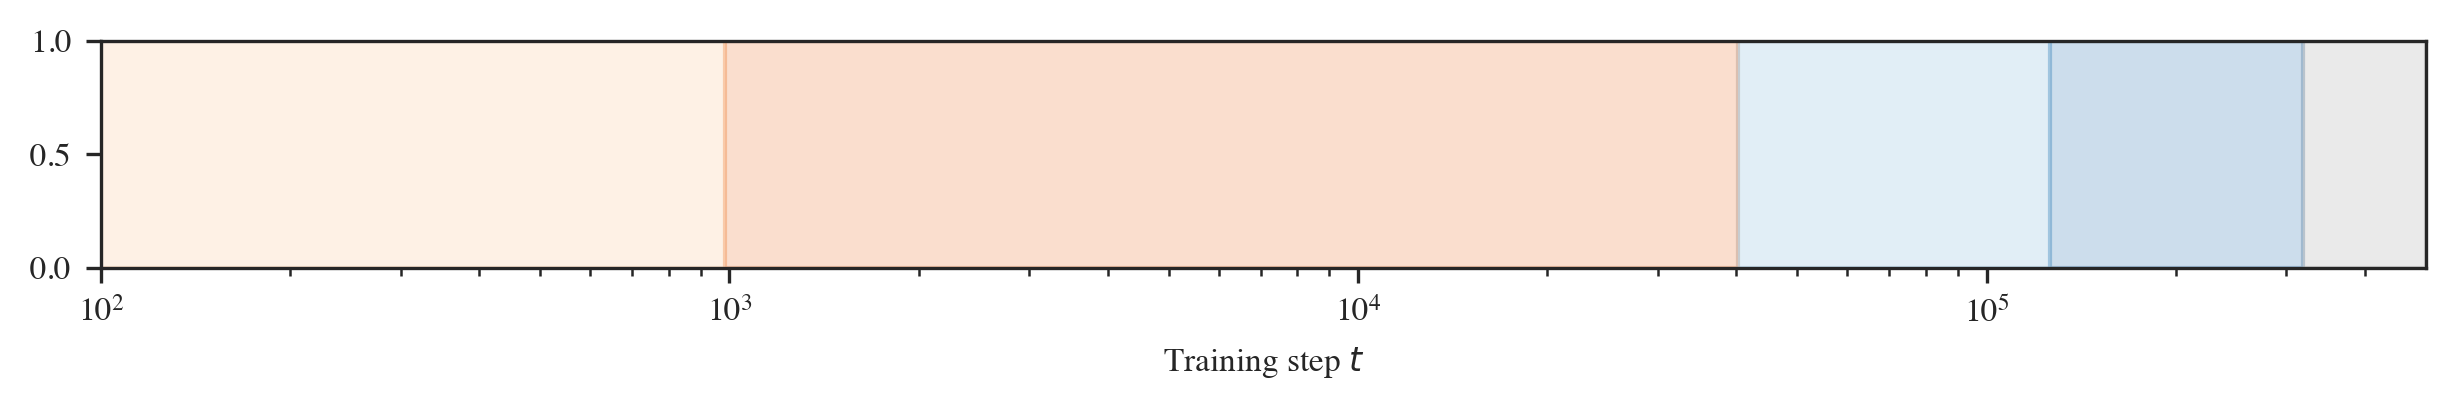

In [115]:
import colorsys
from functools import partial
from matplotlib.colors import LinearSegmentedColormap
import sys

del sys.modules['icl.figures.colors']

from icl.figures.colors import plot_transitions, gen_transition_colors, get_transition_type, PRIMARY, SECONDARY, TERTIARY, BRED, BBLUE, BRED, BGREEN, decrease_brightness, increase_saturation, increase_contrast, rainbow, LR_TRANSITION_COLORS

def get_transition_indices(steps, transitions):
    transition_indices = []
    for step in steps:
        # Find the index of the transition that the current step falls into
        index = next((i for i, transition in enumerate(transitions) if transition[0] <= step < transition[1]), None)
        transition_indices.append(index if index is not None else -1)

    return transition_indices

def get_nearest_step(step):
    idx = np.argmin(np.abs(np.array(steps) - step))
    return steps[idx]

TRANSITIONS = [
    (0, 1000, 'LR1'),
    (1000, 40_000, 'LR2'),
    (40000, 126_000, 'LR3'),
    (126000, 320000, 'LR4'),
    (320000, 500000, 'LR5'),
]

LR_TRANSITION_TYPES = ['A', 'A', "B", "B", "B", "Other"]
LR_TRANSITION_COLORS = gen_transition_colors(LR_TRANSITION_TYPES)

del LR_TRANSITION_COLORS[2], LR_TRANSITION_TYPES[2]

LR_TRANSITION_COLORS[3] = decrease_brightness(LR_TRANSITION_COLORS[3], .9)
LR_TRANSITION_COLORS[3] = increase_saturation(LR_TRANSITION_COLORS[3], 2)
TRANSITIONS = [(get_nearest_step(start), get_nearest_step(end), label) for start, end, label in TRANSITIONS]

transition_rainbow = list(reversed(rainbow(len(TRANSITIONS))))
transitions_cmap = LinearSegmentedColormap.from_list("transitions", LR_TRANSITION_COLORS)
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
_plot_transitions = partial(plot_transitions, transitions=TRANSITIONS, colors=LR_TRANSITION_COLORS)

transitions_of_steps = get_transition_indices(steps, TRANSITIONS)
highlight_steps = list(map(get_nearest_step, [t[0] for t in TRANSITIONS][1:]))

# Show the transition colors
fig, ax = plt.subplots(figsize=(10, 1))
ax.set_xscale('log')
ax.set_xlim(100, 500_000)
_plot_transitions(ax);

LR_TRANSITION_COLORS

# Multiple-Seed Figures

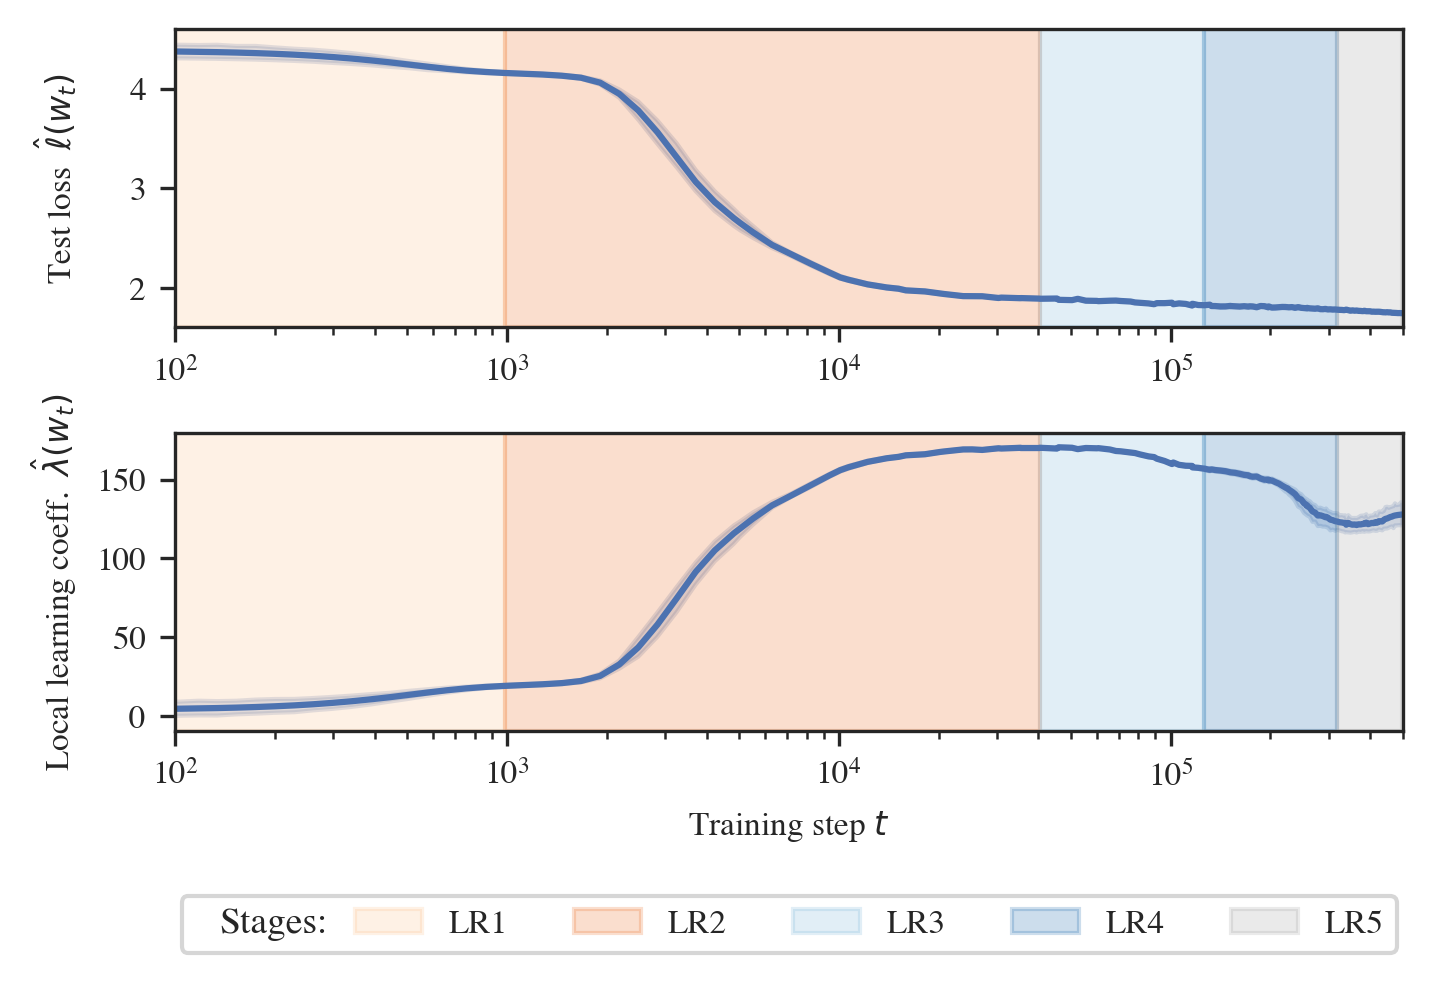

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from icl.figures.plotting import *
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

sns.set_palette('deep')

# Data setup (use your actual data here)
# For demonstration, replace evals_over_time_df with your DataFrame
# evals_over_time_df = ...

# Create figure
fig, axs = plt.subplots(2, 1, figsize=(WIDTH * 1.5, HEIGHT * 1.5))

axs[0].set_ylabel(r'Test loss  $\hat\ell(w_t)$' '\n')
axs[1].set_ylabel(r'Local learning coeff.  $\hat\lambda(w_t)$')

# First line plot
sns.lineplot(evals_over_time_df, x='step', y='pretrain/mse', ax=axs[0])
# axs[0].set_title(r'(b) Loss over Time')
axs[0].set_xscale('log')
# axs[0].set_yscale('log')

# Second line plot
sns.lineplot(evals_over_time_df, x='step', y='llc/mean/mean', ax=axs[1])
# axs[1].set_title(r'(d) Local Learning Coefficient over Time')
axs[1].set_xscale('log')

# Set x-label for both plots
# for ax in axs:

handles = _plot_transitions(axs, xlim=(100, 500_000)) 
axs[0].set_xlabel('')
axs[1].set_xlabel('Training step $t$')


# fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(1.05, .65), ncol=1)
labels = [t[2] for t in TRANSITIONS]
dummy = mlines.Line2D([], [], color='none', label='')
legend = fig.legend(handles=[dummy] + handles, labels=[""] + labels, loc='upper center', bbox_to_anchor=(0.55, 0.01), ncol=len(TRANSITIONS)+1)
fig.text(0.16, -0.058, 'Stages:', horizontalalignment='left', verticalalignment='bottom', zorder=1000, fontsize=9)

# fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.55, 0.01), ncol=len(TRANSITIONS)+1, title="Stages:")
# axs[1].legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(TRANSITIONS))
# Layout adjustments
plt.tight_layout()
fig.set_facecolor('white')

fig.savefig(FIGURES / MODELS_ID / f"lr-fig1-top.pdf", bbox_inches='tight')
plt.show()


# Model-Specific Figures

In [239]:
MODEL_SEED = 1  # 0, 1, 2, 3, 4
MODEL_ID = f"L2H4Minf-seed-{MODEL_SEED}"

if not os.path.exists(FIGURES / MODEL_ID):
    os.makedirs(FIGURES / MODEL_ID)

if not os.path.exists(DATA / MODEL_ID):
    os.makedirs(DATA / MODEL_ID)

In [223]:
for t1, t2, _ in TRANSITIONS: # + [(499_999, None, None)]:
    print(f"Step {t1}->{t2} Delta Lambdahat:", evals_over_time_df.loc[(evals_over_time_df.step == get_nearest_step(t2)) & (evals_over_time_df.model_seed == MODEL_SEED)]['llc/mean/mean'].values[0] - evals_over_time_df.loc[(evals_over_time_df.step == get_nearest_step(t1)) & (evals_over_time_df.model_seed == MODEL_SEED)]['llc/mean/mean'].values[0])
    print(f"Step {t1}->{t2} Delta Loss:", evals_over_time_df.loc[(evals_over_time_df.step == get_nearest_step(t2)) & (evals_over_time_df.model_seed == MODEL_SEED)]['pretrain/mse'].values[0] - evals_over_time_df.loc[(evals_over_time_df.step == get_nearest_step(t1)) & (evals_over_time_df.model_seed == MODEL_SEED)]['pretrain/mse'].values[0])
    print()

Step 0->984 Delta Lambdahat: 14.806382428854704
Step 0->984 Delta Loss: -0.21998977661132812

Step 984->40292 Delta Lambdahat: 150.4033237695694
Step 984->40292 Delta Loss: -2.2617125511169434

Step 40292->126262 Delta Lambdahat: -11.736135959625244
Step 40292->126262 Delta Loss: -0.07939791679382324

Step 126262->318181 Delta Lambdahat: -31.962708353996277
Step 126262->318181 Delta Loss: -0.04290175437927246

Step 318181->499999 Delta Lambdahat: -0.6845265626907349
Step 318181->499999 Delta Loss: -0.033307671546936035




\hat\ell(w_t)
LR1 0: Original: 4.452459335330786 Smoothed: 0.0 
LR2 984: Original: 4.164186954498291 Smoothed: -0.10447947826240439 
LR3 40292: Original: 1.8954315185546875 Smoothed: -0.014657083927366615 
LR4 126262: Original: 1.8286705017089844 Smoothed: -0.09370312419657825 
LR5 318181: Original: 1.778839111328125 Smoothed: -0.045233137838938994 
LR3a 126k: Original:  1.8286705017089844 Smoothed:  -0.09370312419657825
End 50k: Original:  1.747039794921875 Smoothed:  0.0

\hat \lambda(w_t)
LR1 0: Original: -0.7254163143225014 Smoothed: 0.0 
LR2 984: Original: 18.655792236328125 Smoothed: 6.766639234947734 
LR3 40292: Original: 169.48175048828125 Smoothed: -1.5127777395717477 
LR4 126262: Original: 157.38671875 Smoothed: -6.97987461223922 
LR5 318181: Original: 112.53125 Smoothed: -3.1933702261201202 
LR3a 126k: Original:  157.38671875 Smoothed:  -6.97987461223922
End 50k: Original:  115.94140625 Smoothed:  0.0
[     1      6      9     27    984  15151  23711  35290  45454  52524
 1

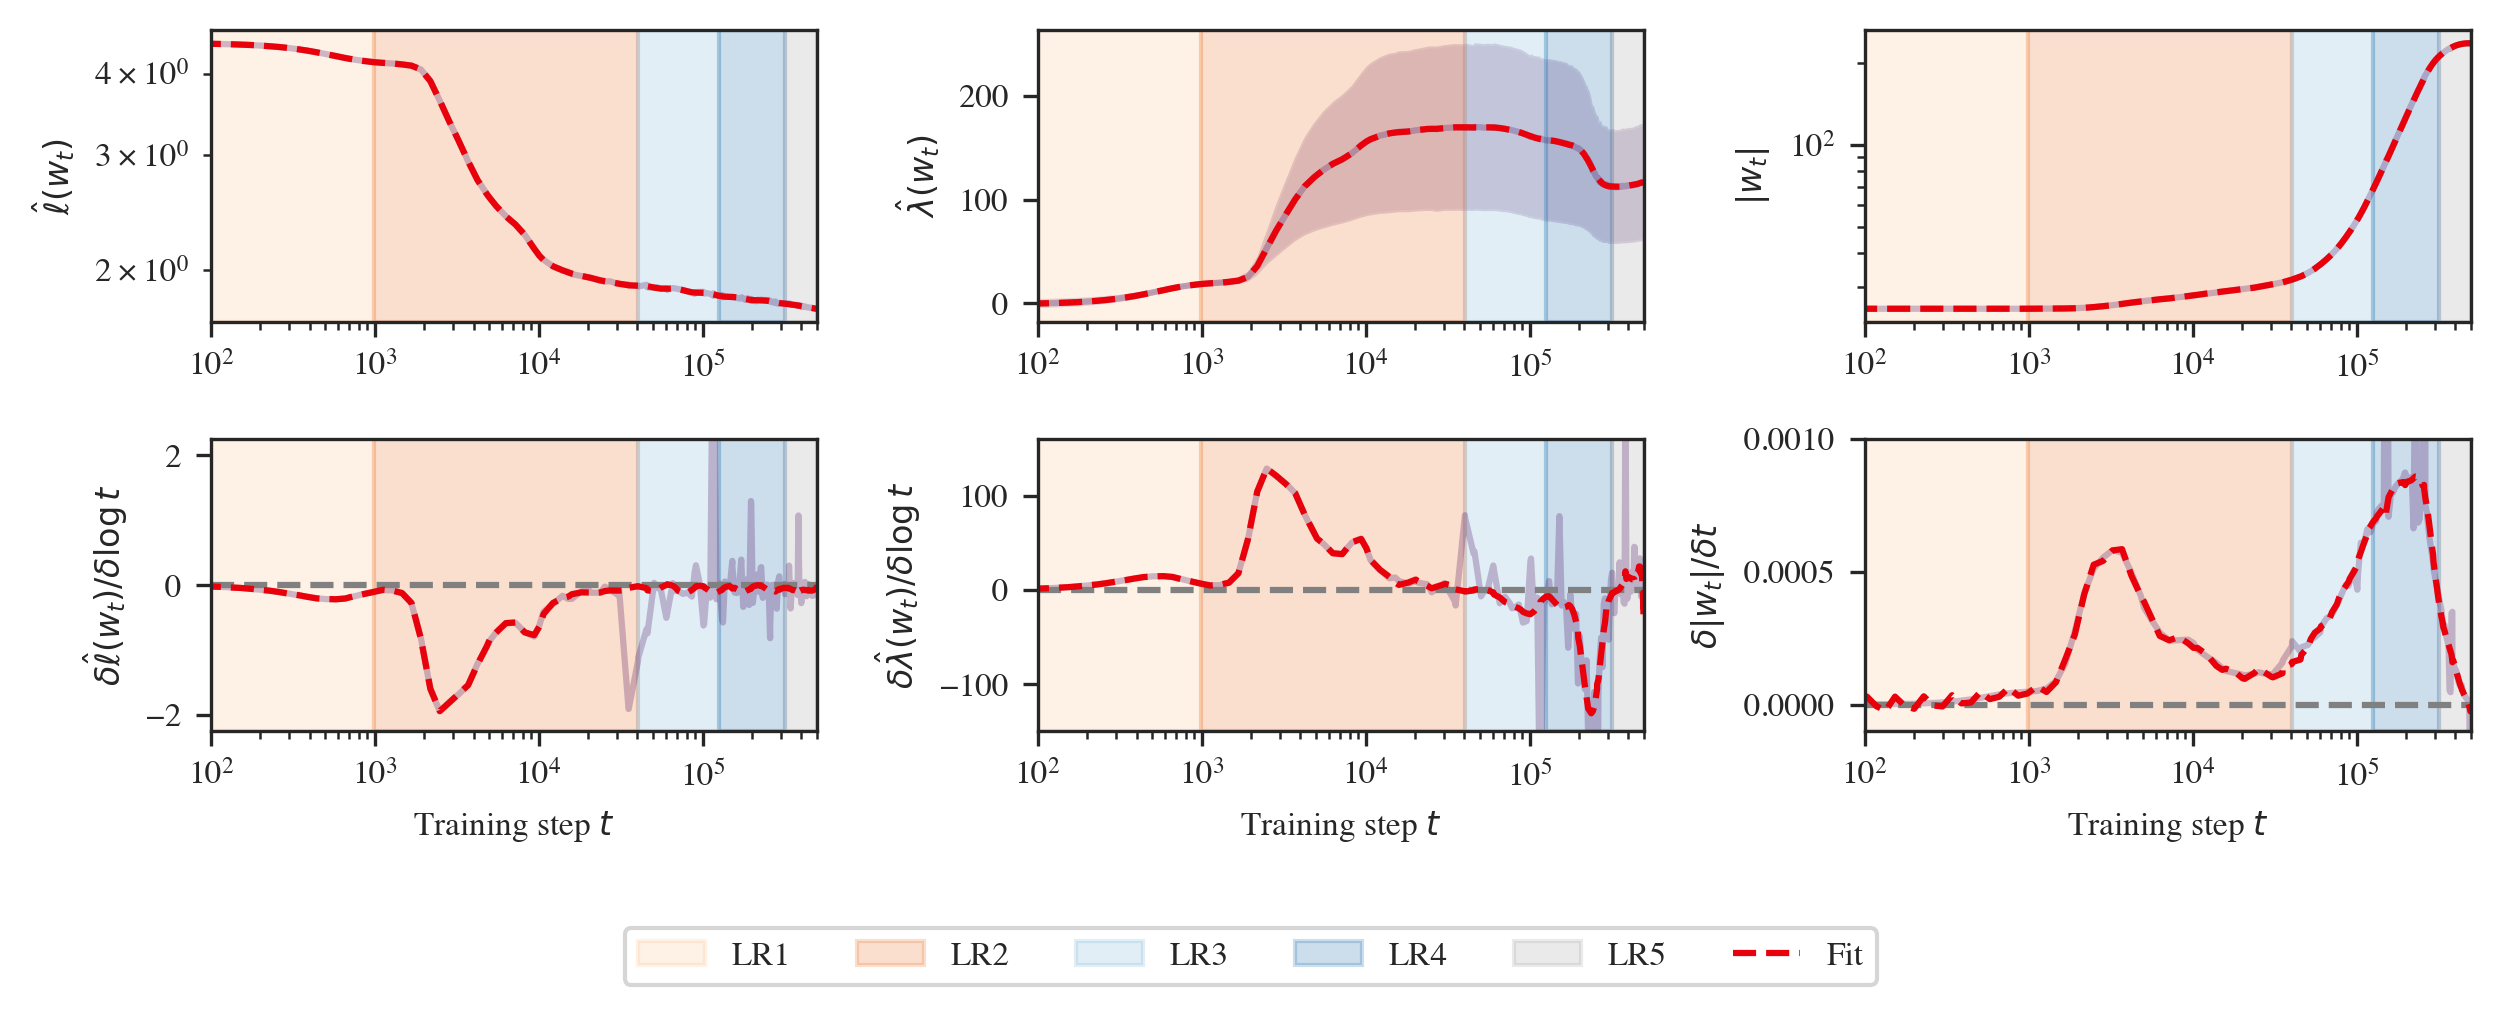

In [250]:
from matplotlib import lines as mlines
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

plt.rcParams['figure.dpi'] = 300

_df = evals_over_time_df.loc[evals_over_time_df.model_seed == MODEL_SEED].sort_values(by='step')

metrics_to_plot = [
    (r"\hat\ell(w_t)", "pretrain/mse", {"logy": True, "derivative": "d_dlogt", "spline": True, "s": 0.1}, ),
    # (r"L_\mathcal{G}(t)", _df["true/mse"], {"logy": False}),
    (r"\hat \lambda(w_t)", 'llc/mean/mean', {"derivative": "d_dlogt", "spline": True}),
    (r"|w_t|", "weight/norm", {"derivative": "d_dt", "logy": True, "spline": True, "s": 0.1}),
] 
fig, axes = plt.subplots(2, len(metrics_to_plot), figsize=(FULL_WIDTH * 1.25, FULL_HEIGHT * 1.5))

# axes = np.array(axes)
axes = axes.reshape(2, len(metrics_to_plot))

def str_dlog_dlogt(s):
    return r"$\delta \log " + s + r"/\delta\log t$"

for i, (metric_name, metric_key, kwargs) in enumerate(metrics_to_plot):
    use_spline = kwargs.get("spline", False)

    sns.lineplot(data=_df, x="step", y=_df[metric_key], ax=axes[0, i],label=metric_name, alpha=1 - use_spline * 0.75)

    std_key = {'llc/mean/mean':'llc/mean/std'}.get(metric_key, None)
    if std_key is not None:
        bottom = _df[metric_key] - _df[std_key]
        top = _df[metric_key] + _df[std_key]
        axes[0, i].fill_between(steps, bottom, top, alpha=0.2)
    # axes[0, i].plot(_df['step'], metric_values, label=metric_name, marker='.')
    axes[0, i].set_title(f"")
    axes[0, i].set_xlabel('')
    axes[0, i].set_ylabel(f"${metric_name}$")

    if kwargs.get("logy", False):
        axes[0, i].set_yscale('log')

    axes[0, i].legend().remove()

    slope_type = kwargs.get("derivative", "d_dlogt")

    if slope_type == "d_dlogt":
        slope_name = str_d_dlogt(metric_name)
    elif slope_type == "d_dt":
        slope_name = str_d_dt(metric_name)
    elif slope_type == "dlog_dlogt":
        slope_name = str_dlog_dlogt(metric_name)
    else:
        raise ValueError(f"Unknown slope type {slope_type}")

    sns.lineplot(data=_df, x="step", y=f"{metric_key}/{slope_type}", ax=axes[1, i], label=metric_name + " Slope", alpha=1 - use_spline * 0.75)
    axes[1, i].axhline(0, linestyle='--', color='gray')
    axes[1, i].set_title("")
    axes[1, i].set_xlabel('Training step $t$')
    axes[1, i].set_ylabel(slope_name)
    axes[1, i].legend().remove()
    
    if use_spline:     
        _steps = np.log(np.array(steps) + 1 ).reshape((-1, 1))
        _y = _df.groupby('step').mean()[metric_key].values

        kernel = C(1.0, (1e-3, 1e3)) * RBF(3, (5e-1, 1e3))

        # Create a Gaussian Process Regressor
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

        # Fit the Gaussian Process
        gp.fit(_steps, _y)
        _ypred = gp.predict(_steps)

        if slope_type == "d_dlogt":
            _derivy = d_dt(_steps, _ypred)
        elif slope_type == "d_dt":
            _derivy = d_dt(np.exp(_steps), _ypred)
        elif slope_type == "dlog_dlogt":            
            _derivy = d_dt(_steps, np.log(_ypred))
        
        axes[0, i].plot(steps, _ypred, label="Spline", linestyle='--', color=BRED)
        axes[1, i].plot(steps, _derivy, label="Spline", linestyle='--', color=BRED)

        print()
        print(metric_name)
        for t1, t2, label in TRANSITIONS:
            i1, i2 = list(steps).index(t1), list(steps).index(t2)
            print(f"{label} {t1}: Original: {_ypred[i1]} Smoothed: {_derivy[i1]} ")

        print("LR3a 126k: Original: ", _ypred[steps.index(126262)], "Smoothed: ", _derivy[steps.index(126262)])
        print("End 50k: Original: ", _ypred[-1], "Smoothed: ", _derivy[-1])

        # Find indices where |derivy| < 10
        if metric_key == "llc/mean/mean":
            # Find where derivative is less than neighbors
            local_min_idxs = np.where((np.abs(_derivy[1:-1]) < np.abs(_derivy[:-2])) & (np.abs(_derivy[1:-1]) < np.abs(_derivy[2:])))[0]
            local_mins = np.array(steps)[local_min_idxs]

            # Check that these are also less than 10       
            small_idxs = np.where(np.abs(_derivy) < 8)[0]

            # Combine
            local_min_and_small_idxs = np.array(sorted(list(set(local_min_idxs) & set(small_idxs))))

            print(np.array(steps)[local_min_and_small_idxs])

patch_list = plot_transitions(axes, TRANSITIONS, xlim=True, colors=LR_TRANSITION_COLORS)

for ax in axes[0]:
    ax.set_xlabel('')

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_xlim(100, 500_000)
    # ax.set_ylabel("")

# axes[0, 1].set_ylim(0, 100)
axes[1, 0].set_ylim(-2.25, 2.25)
axes[1, 1].set_ylim(-150, 160)
axes[1, 2].set_ylim(-0.0001, 0.001)
# axes[1, 1].set_ylim(-.005, .005)
#axes[1, 1].set_yscale('symlog')

milestone_labels = [label for _, _, label in TRANSITIONS]
gp_fit_patch = mlines.Line2D([], [], color=BRED, linestyle='--', label="GP Fit")
fig.legend(patch_list + [gp_fit_patch], milestone_labels + ["Fit"], loc='upper center', bbox_to_anchor=(0.5, -0.025), ncol=len(TRANSITIONS) + 1)

fig.set_facecolor("white")
fig.tight_layout()

fig.savefig(FIGURES / MODEL_ID /"behavioral-detail.pdf", bbox_inches='tight')

In [256]:
## Error bars over chains

print(evals_over_time_df.groupby('step').std()['llc/mean/mean'].mean())
print(evals_over_time_df.groupby('step').mean()['llc/mean/mean'].mean())
print((evals_over_time_df.groupby('step').std()['llc/mean/mean'] / evals_over_time_df.groupby('step').mean()['llc/mean/mean']).mean())


4.24044189655268
105.6721855814263
0.28439487183528034


# Behavioral Indicators

In [225]:
k0 = 0

titles_and_labels = {
    "loss": ("Test Loss $L_\mathrm{val}$", "MSE"),
    "loss_0": ("$\mathbb{E}[|\hat{y}_k|^2]$", r"$\|\hat y_k\|^2$"),
    # "loss_first_x": ("(MSE from Ridge", "MSE"),
    "pretrain/delta_ridge/token": ("MSE from Ridge", "MSE"),  
    "ood_inputs_loss": (r"MSE on $x_i \sim \mathcal{N}(0, 5I_D)$", "MSE"),
    "ood_targets_loss": (r"MSE on $\mathbf{t} \sim \mathcal{N}(0, 5I_D)$", "MSE"),
    "llc/mean": (r"Per-Token $\lambda_t$", "$\lambda_t^{(i)}$"),
    "icl_score": (f"$ICL_{{{k0+1}:8}}(w_t)/g$", "ICL"),
    "ood_inputs_rel_loss": (r"$\frac{\mathrm{MSE}(5 x_i)}{\mathrm{MSE}(x_i)}$", "MSE"),
    "loss_first_x": ("MSE from Ridge-Optimal 1-sample Prediction", "MSE"),
    "hessian": ("Hessian Statistics", "")
}


## Loss, Prediction Norm, OOD Loss

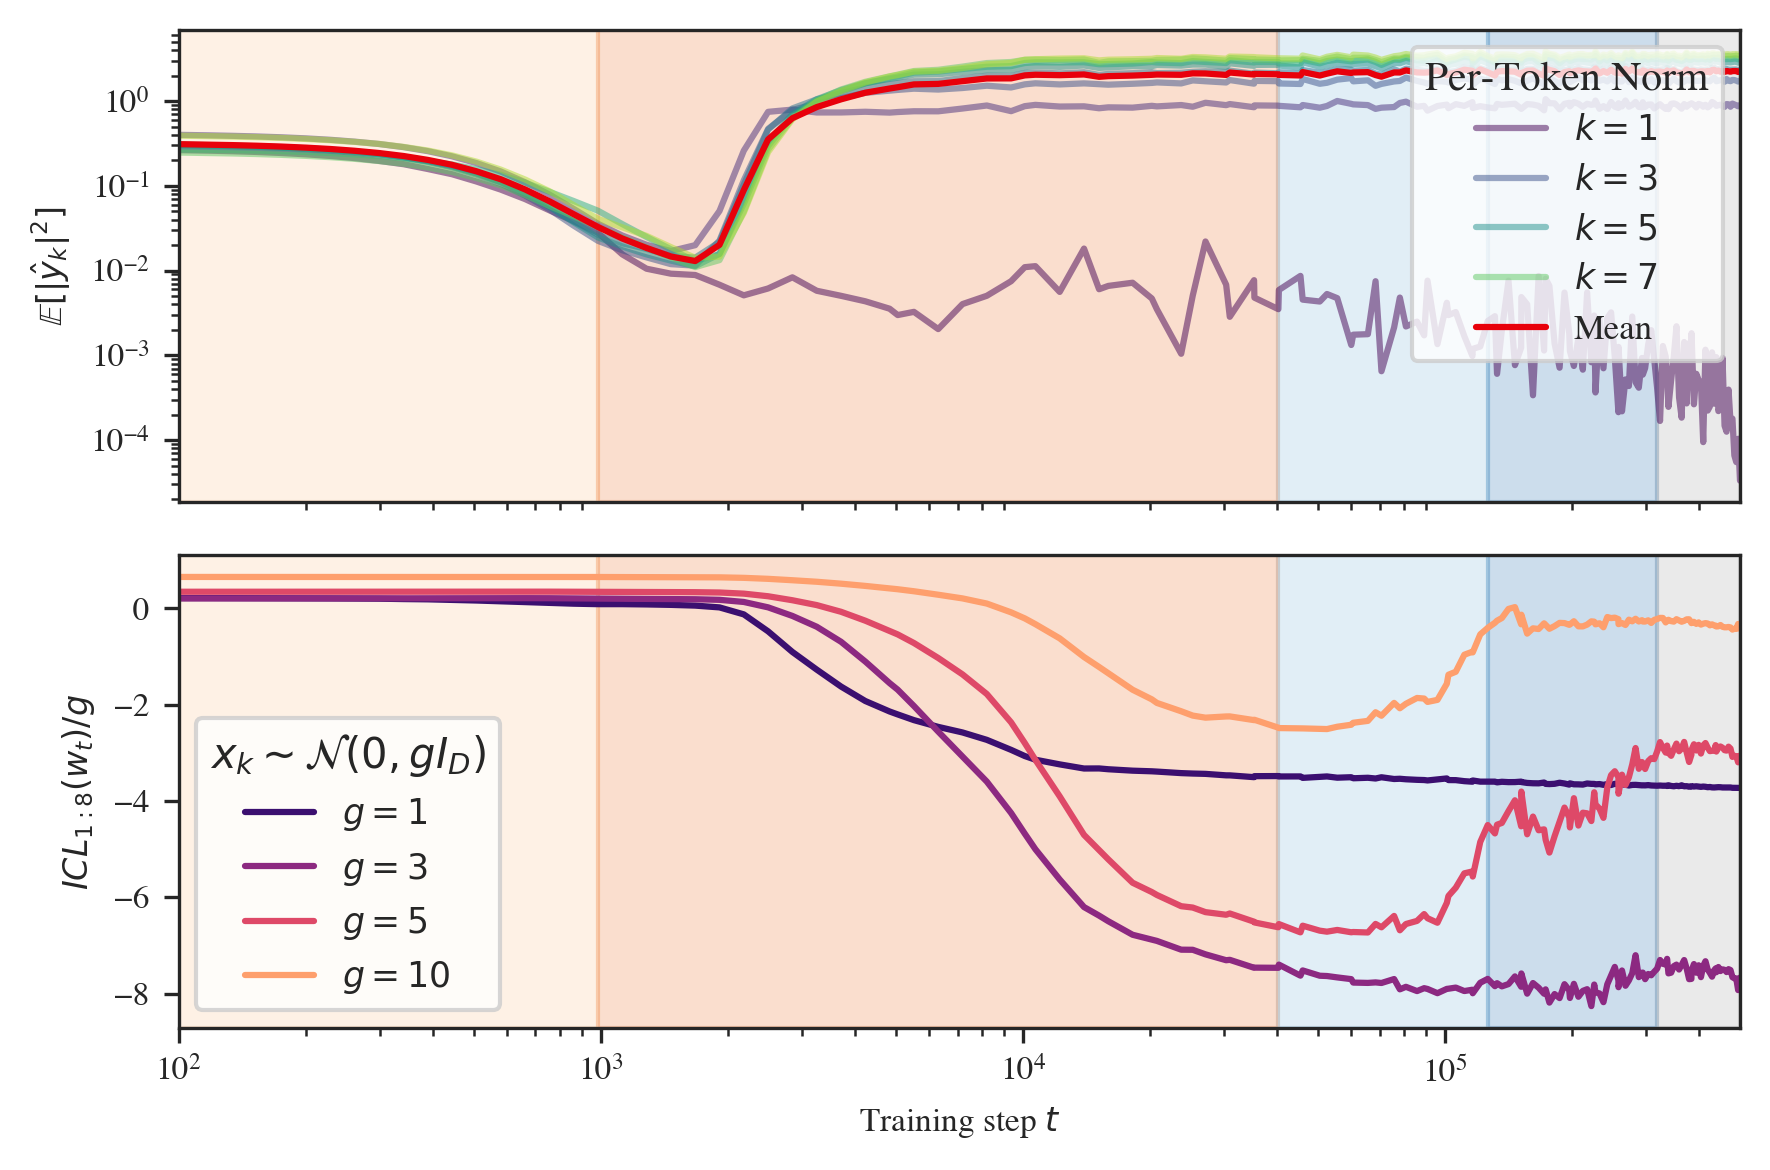

In [242]:
metrics = ['loss_0', 'icl_score'] #, "ood_inputs_rel_loss"]# "loss", "ood_loss"]

df = evals_over_time_df.loc[evals_over_time_df.model_seed == MODEL_SEED]

fig, axes = plt.subplots(len(metrics), 1, figsize=(6, 4))  # Adjust the figsize as needed
token_cmap = ScalarMappable(norm=Normalize(vmin=0, vmax=8), cmap="viridis")

ood_colors = sns.color_palette("magma", 4)

for m, metric in enumerate(metrics):
    if metric == 'icl_score':
        data = df[f'loss/7'].values - df[f'loss/{k0}'].values
        sns.lineplot(x=df.step, y=data, ax=axes[m], color=ood_colors[0], label=f"$g=1$")

        for i, (l, g) in enumerate(zip(['a', 'b', 'c'], [3, 5, 10, 100])):
            data = (df[f'ood_{l}_inputs_loss/7'].values - df[f'ood_{l}_inputs_loss/{k0}'].values ) / (g)
            sns.lineplot(x=df.step, y=data, ax=axes[m], color=ood_colors[i+1], label=f"$g={g}$")

    elif metric == 'ood_inputs_rel_loss':
        for l, g in zip(['a', 'b', 'c', 'd'], [3, 5, 10, 100]):
            data = df[f'ood_{l}_inputs_loss/mean'].values / g ** 2 # df[f'loss/mean'].values
            sns.lineplot(x=df.step, y=data, ax=axes[m])
    else:
        for i in range(8):
            color = token_cmap.to_rgba(i)
            # if i == 0 and metric == "loss_first_x":
            #     continue

            sns.lineplot(data=df, x="step", y=f"{metric}/{i}", ax=axes[m], alpha=0.5, color=color, label=f"$k={i+1}$" if i % 2 == 0 else "_")

        if metric.endswith('/token'):
            mean_metric = metric[:-6] 
        else:
            mean_metric = f"{metric}/mean"
            
        sns.lineplot(data=df, x="step", y=mean_metric, label="Mean", ax=axes[m], color=BRED)

for ax in axes:
    ax.set_xscale("log")
    ax.set_xlabel("")

    # legend = ax.legend()
    # legend.remove()
    ax.set_xlim(100, 500_000)

ax.set_xlabel("Step $t$")
# legend = axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=6)
# legend.set_title("Per-Token Losses")

# Move legend to be likee fig.legend(patch_list, milestone_titles_and_labels, loc='upper center', bbox_to_anchor=(0.5, -0.025), ncol=len(TRANSITIONS))
for i, (ax, metric) in enumerate(zip(axes, metrics)):
    title, label = titles_and_labels[metric]
    # ax.set_ylabel(label)
    ax.set_ylabel("")
    l = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'][i]
    # ax.set_title(f"({l}) {title}")
    ax.set_ylabel(title)

    # if settings.get(metric, {}).get("logy", False):
    # ax.set_yscale("log")
    ax.set_xscale('log')

for ax in [axes[0]]: #, axes[2]]:
    ax.set_yscale('log')

# axes[3].set_yscale('linear')
# axes[5].set_yscale('linear')
plt.tight_layout()

# Change right space
fig.subplots_adjust(right=0.75) 

# Small legends
axes[0].legend(loc='upper right', title="Per-Token Norm", fontsize='small')
axes[1].legend(title="$x_k\sim \mathcal{N}(0, gI_D)$",  fontsize='small')

_plot_transitions(axes)

for ax in axes.flatten()[:-1]:
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_xticklabels([])
    # ax.set_ylabel("")
# Add color bar on the far right

plt.tight_layout()

fig.set_facecolor('white')
fig.savefig(FIGURES / MODEL_ID / 'behavioral.pdf');

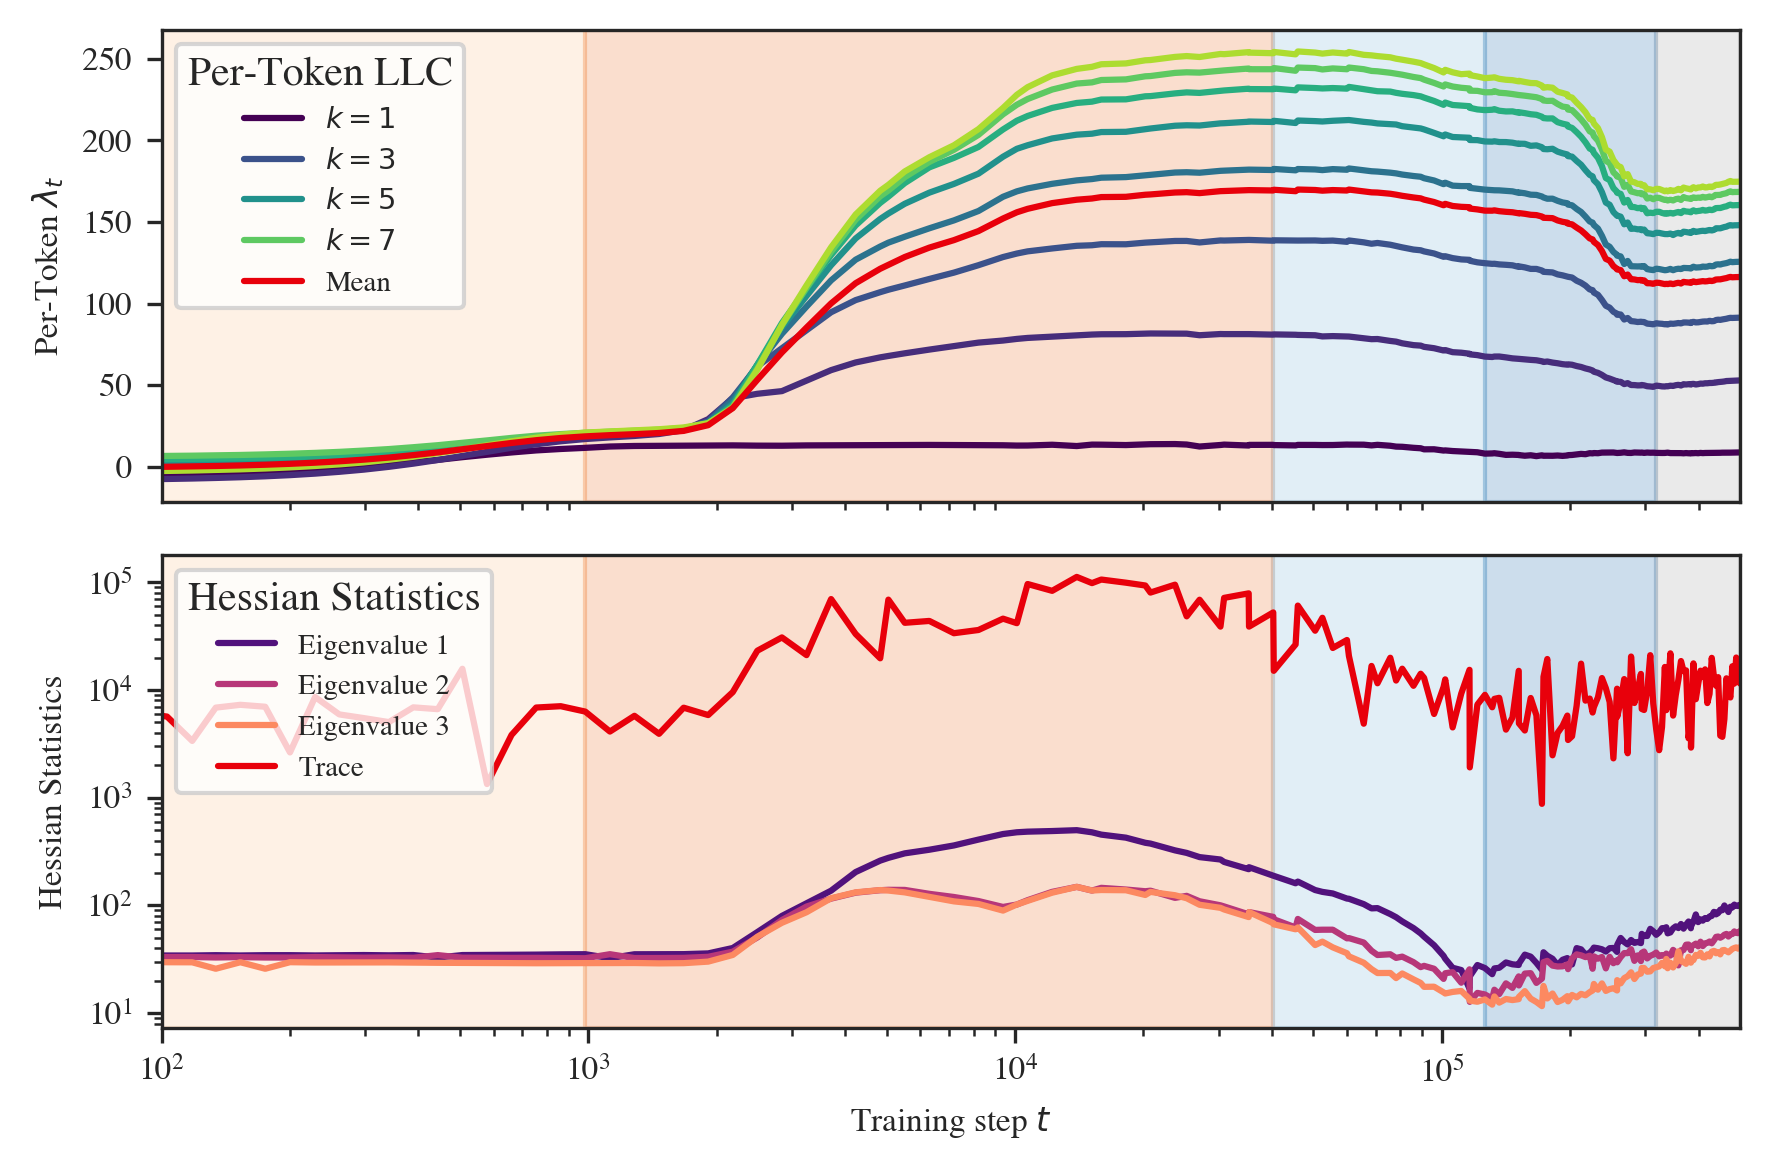

In [257]:
metrics = ["llc/mean"]# "loss", "ood_loss"]

fig, axes = plt.subplots(2, 1, figsize=(6, 4))  # Adjust the figsize as needed

token_cmap = ScalarMappable(norm=Normalize(vmin=0, vmax=8), cmap="viridis")


for i in range(8):
    color = token_cmap.to_rgba(i)

    for m, metric in enumerate(metrics):
        # if i == 0 and metric == "loss_first_x":
        #     continue

        sns.lineplot(data=df, x="step", y=f"{metric}/{i}", ax=axes[m], alpha=1, color=color, label=f"$k={i+1}$" if i % 2 == 0 else "_")

    # if i > 0:
    #     sns.lineplot(data=df, x="step", y=f"loss_first_x/{i}", ax=axes[2], alpha=0.5, color=color)

for m, metric in enumerate(metrics):
    if metric.endswith('/token'):
        mean_metric = metric[:-6] 
    else:
        mean_metric = f"{metric}/mean"
        
    sns.lineplot(data=df, x="step", y=mean_metric, label="Mean", ax=axes[m], color=BRED)

ax = axes[0]
ax.set_ylabel(r"$\hat\lambda_k(w_t)$")
ax = axes[1]

_hessian_df = hessian_stats_df.loc[hessian_stats_df.model_seed == MODEL_SEED]
_hessian_df['hessian/trace'] = _hessian_df['hessian/trace'].map(sum)
cmap3 = sns.color_palette("magma", 3)

sns.lineplot(_hessian_df, x='step', y="hessian/evals/0", color=cmap3[0], label="Eigenvalue 1", ax=ax)
sns.lineplot(_hessian_df, x='step', y="hessian/evals/1", color=cmap3[1], label="Eigenvalue 2", ax=ax)
sns.lineplot(_hessian_df, x='step', y="hessian/evals/2", color=cmap3[2], label="Eigenvalue 3", ax=ax)
sns.lineplot(_hessian_df, x='step', y="hessian/trace", ax=ax, color=BRED, label="Trace")

ax.set_yscale('log')

for ax in axes:
    ax.set_xscale("log")
    ax.set_xlabel("")

    ax.set_xlim(100, 500_000)

# legend = axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=6)
# legend.set_title("Per-Token Losses")

# Move legend to be likee fig.legend(patch_list, milestone_titles_and_labels, loc='upper center', bbox_to_anchor=(0.5, -0.025), ncol=len(TRANSITIONS))
for i, (ax, metric) in enumerate(zip(axes, [*metrics, 'hessian'])):
    title, label = titles_and_labels[metric]
    l = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'][i]
    # ax.set_title(f"({l}) {title}")
    ax.set_ylabel(f"{title}")

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('')

ax.set_xlabel('Training step $t$')

axes[0].set_xticks([])
axes[0].set_xticklabels([])
        
plt.tight_layout()

fig.subplots_adjust(right=0.75) 
axes[0].legend(loc='upper left', ncol=1, fontsize='x-small', title="Per-Token LLC")
axes[1].legend(loc='upper left', ncol=1, title="Hessian Statistics", fontsize='x-small')

_plot_transitions(axes)


for ax in axes.flatten()[:-1]:
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_xticklabels([])
# Add color bar on the far right

plt.tight_layout()

fig.set_facecolor('white')
fig.savefig(FIGURES / MODEL_ID / 'geometric.pdf')


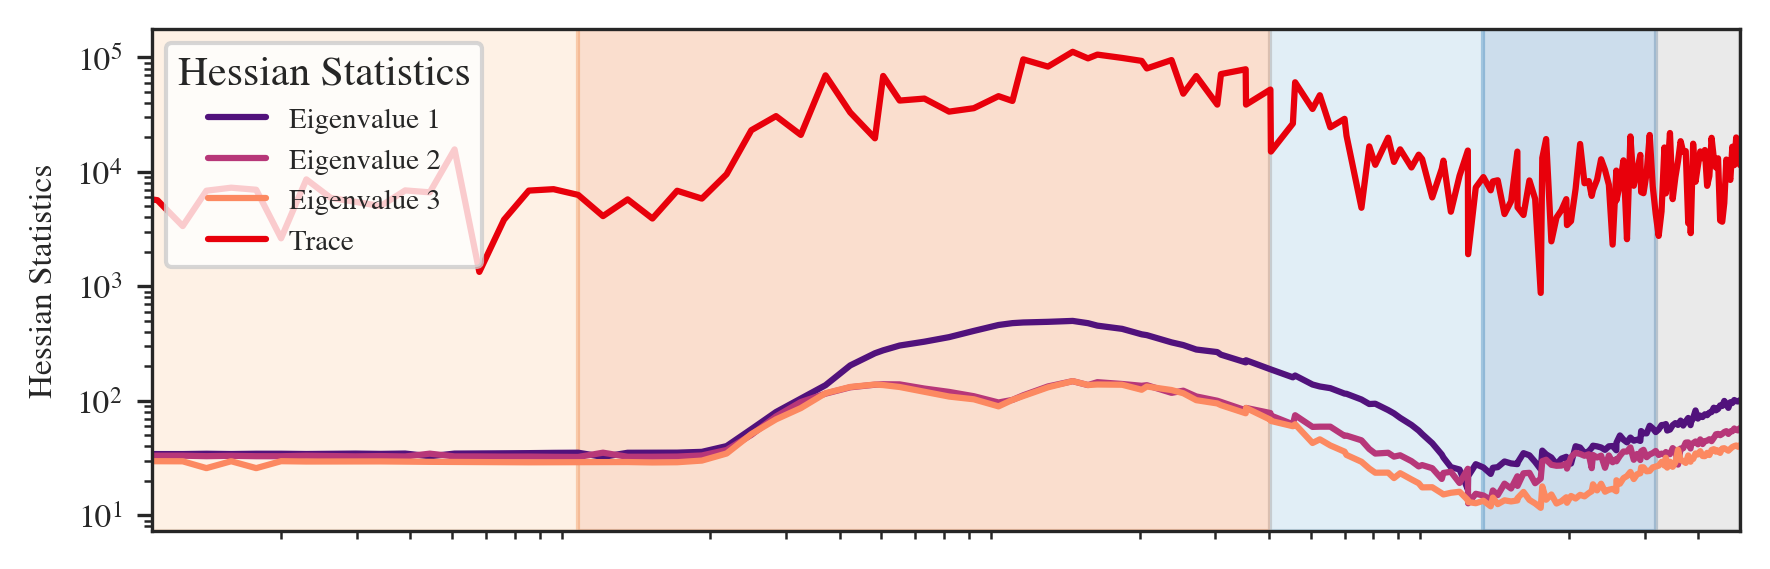

In [260]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2))  # Adjust the figsize as needed
axes = [ax]

token_cmap = ScalarMappable(norm=Normalize(vmin=0, vmax=8), cmap="viridis")

_hessian_df = hessian_stats_df.loc[hessian_stats_df.model_seed == MODEL_SEED]
_hessian_df['hessian/trace'] = _hessian_df['hessian/trace'].map(sum)
cmap3 = sns.color_palette("magma", 3)

sns.lineplot(_hessian_df, x='step', y="hessian/evals/0", color=cmap3[0], label="Eigenvalue 1", ax=ax)
sns.lineplot(_hessian_df, x='step', y="hessian/evals/1", color=cmap3[1], label="Eigenvalue 2", ax=ax)
sns.lineplot(_hessian_df, x='step', y="hessian/evals/2", color=cmap3[2], label="Eigenvalue 3", ax=ax)
sns.lineplot(_hessian_df, x='step', y="hessian/trace", ax=ax, color=BRED, label="Trace")

ax.set_yscale('log')

for ax in axes:
    ax.set_xscale("log")
    ax.set_xlabel("")

    ax.set_xlim(100, 500_000)

# legend = axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=6)
# legend.set_title("Per-Token Losses")

# Move legend to be likee fig.legend(patch_list, milestone_titles_and_labels, loc='upper center', bbox_to_anchor=(0.5, -0.025), ncol=len(TRANSITIONS))
for i, (ax, metric) in enumerate(zip(axes, ['hessian'])):
    title, label = titles_and_labels[metric]
    l = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'][i]
    # ax.set_title(f"({l}) {title}")
    ax.set_ylabel(f"{title}")

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('')

ax.set_xlabel('Training step $t$')

plt.tight_layout()

fig.subplots_adjust(right=0.75) 
ax.legend(loc='upper left', ncol=1, title="Hessian Statistics", fontsize='x-small')

_plot_transitions(axes)


for ax in axes:
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_xticklabels([])
# Add color bar on the far right

plt.tight_layout()

fig.set_facecolor('white')
fig.savefig(FIGURES / MODEL_ID / 'hessian.pdf')


## ICL Score

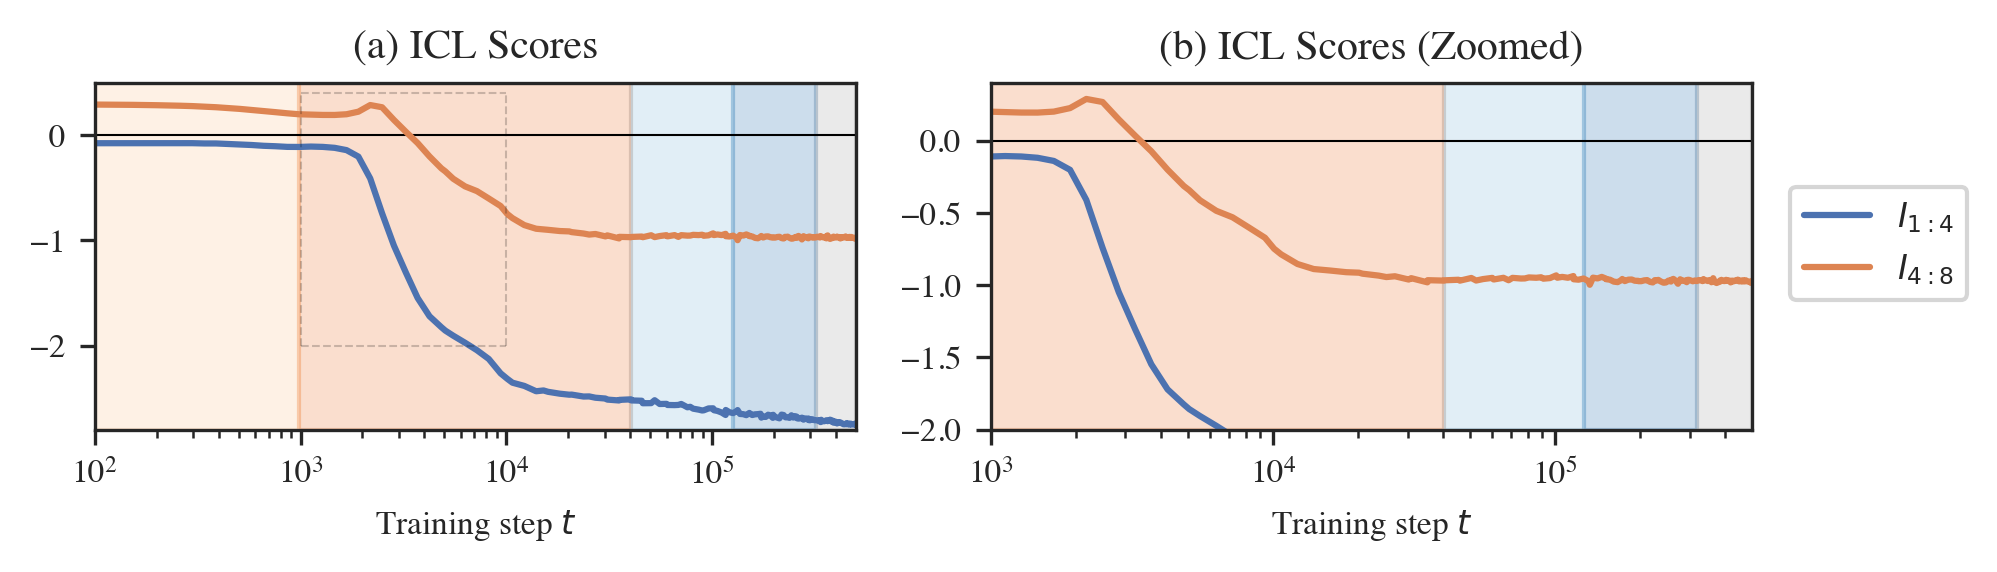

In [244]:
fig, axes = plt.subplots(1, 2, figsize=(FULL_WIDTH, FULL_HEIGHT))

sns.set_palette('deep')

icl_score_1 =  -df['loss/0'] + df['loss/3']
icl_score_2 =  - df['loss/3'] + df['loss/7']

df['icl_score_1'] = icl_score_1
df['icl_score_2'] = icl_score_2

for ax in axes:
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
    sns.lineplot(data=df, x="step", y="icl_score_1", ax=ax, color=sns.palettes.color_palette("deep", 2)[0])    
    sns.lineplot(data=df, x="step", y="icl_score_2", ax=ax, color=sns.palettes.color_palette("deep", 2)[1])
    ax.set_ylabel("$I_{k:k'}$")

axes[0].set_title("(a) ICL Scores")
axes[1].set_title("(b) ICL Scores (Zoomed)")
axes[0].set_xlim(100, 500_000)
axes[0].set_ylim(-2.8, 0.5)
axes[1].set_xlim(1000, 10_000)
axes[1].set_ylim(-2, 0.4)

# Draw box
ylim = axes[0].get_ylim()
height = ylim[1] - ylim[0]

bottom = (-2 - ylim[0]) / height
# print(bottom, bottom * height, ylim)
height = (0.4 - ylim[0]) / height

xlim = axes[0].get_xlim()
width = np.log10(xlim[1]) - np.log10(xlim[0])

left = (np.log10(1000) - np.log10(100)) / width
right = (np.log10(10000) - np.log10(100)) / width

axes[0].axvline(1000, bottom, height, alpha=0.2, color='black', linestyle='--', linewidth=0.5)
axes[0].axvline(10000, bottom, height, alpha=0.2, color='black', linestyle='--', linewidth=0.5)
axes[0].axhline(-2, left, right, alpha=0.2, color='black', linestyle='--', linewidth=0.5)
axes[0].axhline(0.4, left, right, alpha=0.2, color='black', linestyle='--', linewidth=0.5)

# ylims1 = axes[0].get_ylim()
# ylims2 = axes[1].get_ylim()

# min_ylim = min(ylims1[0], ylims2[0])
# max_ylim = max(ylims1[1], ylims2[1])

for ax in axes:
    ax.set_xlabel("Step $t$")
    ax.set_xscale("log")
    ax.set_ylabel("")
    # ax.set_yscale("log")
    # ax.set_ylim(min_ylim, max_ylim)

# handles = axes[0].get_legend_handles_labels()[0]
# ax.legend(handles=handles, labels=[f"$M = 2^{{{m}}}$" for m in [4, 8, 12, 16, 20]], bbox_to_anchor=(1.05, .9), loc='upper left', borderaxespad=0.)
ax.legend(labels=["_", "$I_{1:4}$", "_", "$I_{4:8}$"], bbox_to_anchor=(1.05, .7), loc='upper left', borderaxespad=0.)

_plot_transitions(axes)

fig.tight_layout()
fig.savefig(FIGURES / MODEL_ID / "icl-scores.pdf", bbox_inches='tight')
plt.show()

# Essential Dynamics

In [229]:
import pickle
from typing import Tuple
from sklearn.decomposition import PCA

from icl.figures.plotting import plot_explained_variance

def plot_essential_dynamics_grid(steps, rows: List[Tuple[PCA, List]], transitions, palette='tab10', save=False, figsize=(20, 4), num_pca_components=3, max_step=None, normalize=False, labels=None, max_plot=-1):
    num_samples = len(rows)  

    # Create a single row of subplots
    num_pca_combos = (num_pca_components * (num_pca_components-1)) // 2
    fig, all_axes = plt.subplots(num_samples, num_pca_combos + 1, figsize=figsize)
    
    if num_samples == 1:
        all_axes = [all_axes]

    labels = labels or [f"Model {i+1}" for i in range(num_samples)]

    for samples_idx, (pca, samples) in enumerate(tqdm.tqdm(rows, desc="Plotting...")):
        axes = all_axes[samples_idx]

        # Ensure ax is iterable by converting to a list if there's only one subplot
        if num_pca_components == 2:
            axes = [axes]

        # colors = list(reversed(rainbow(len(transitions) + 1)))
        if isinstance(palette, str):
            colors = sns.palettes.color_palette(palette, n_colors=len(transitions) + 1)
        else:
            colors = palette

        I = 0

        max_plot = max_plot if max_plot is not None else len(samples)

        for i in range(1, num_pca_components):
            for j in range(i):
                sns.scatterplot(x=samples[:max_plot, i], y=samples[:max_plot, j], ax=axes[I], alpha=0.5, color="gray", s=10, legend=False)
                
                for k, (start, end, stage) in enumerate(transitions):
                    start_idx = steps.index(start)
                    end_idx = steps.index(end) + 1

                    if max_plot > 0:
                        if start > max_plot:
                            continue

                        end_idx = min(end_idx, max_plot)

                    # sc = axes[I].scatter(samples[:, i], samples[:, j], c=transition_idxs, cmap=cmap, s=50, alpha=alpha)
                    axes[I].plot(samples[start_idx:end_idx, i], samples[start_idx:end_idx, j], color=colors[k])

                if not transitions:
                    axes[I].plot(samples[:max_plot, i], samples[:max_plot, j])

                axes[I].set_xlabel(f'PC {i+1}')
                axes[I].set_ylabel(f'PC {j+1}')
                # axes[I].set_title(f'PC {j+1} vs PC {i+1}')

                I += 1

        axes[0].set_ylabel(f"{labels[samples_idx]}\n\nPC 1")

        plot_explained_variance(pca, ax=axes[-1], num_pca_components=num_pca_components)

    # cmap = sns.palettes.color_palette(palette, n_colors=len(transitions) + 1)
    # Plot the legend on the first subplot on the left
    # legend_ax = axes[0]
    # scatter_proxy = [plt.Line2D([0], [0], linestyle='none', marker='o', alpha=alpha, color=cmap[i]) for i in range(len(transitions))]
    # legend_labels = [label for _, _, label in transitions]
    # legend_ax.legend(scatter_proxy, legend_labels, loc='center', ncol=1, frameon=False, bbox_to_anchor=(-0.5, 0.5), title='Developmental Stages')
    # legend_ax.set_title()

    # plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the right side to make room for the colorbar
    # plt.tight_layout(rect=[0, 0, 1, 1])

    if transitions:
        # Create an axis for the legend

        # Create a list of handles for the legend
        handles = [plt.Line2D([0], [0], color=colors[i], linestyle='-') for i in range(len(transitions))]
        labels = [label for _, _, label in transitions]

        # Add legend to the new axis
        fig.legend(handles, labels, loc='center', ncol=len(labels), frameon=False, bbox_to_anchor=(0.5, 0.02))
        # Add some space at the bottom for the legend

    plt.tight_layout()  # Adjust layout first
    plt.subplots_adjust(bottom=0.1, top=0.9)  # Fine-tune spacing, adjust these values as needed

    fig.set_facecolor('white')
    
    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)

    return fig 

Plotting...: 100%|██████████| 5/5 [00:00<00:00, 28.03it/s]


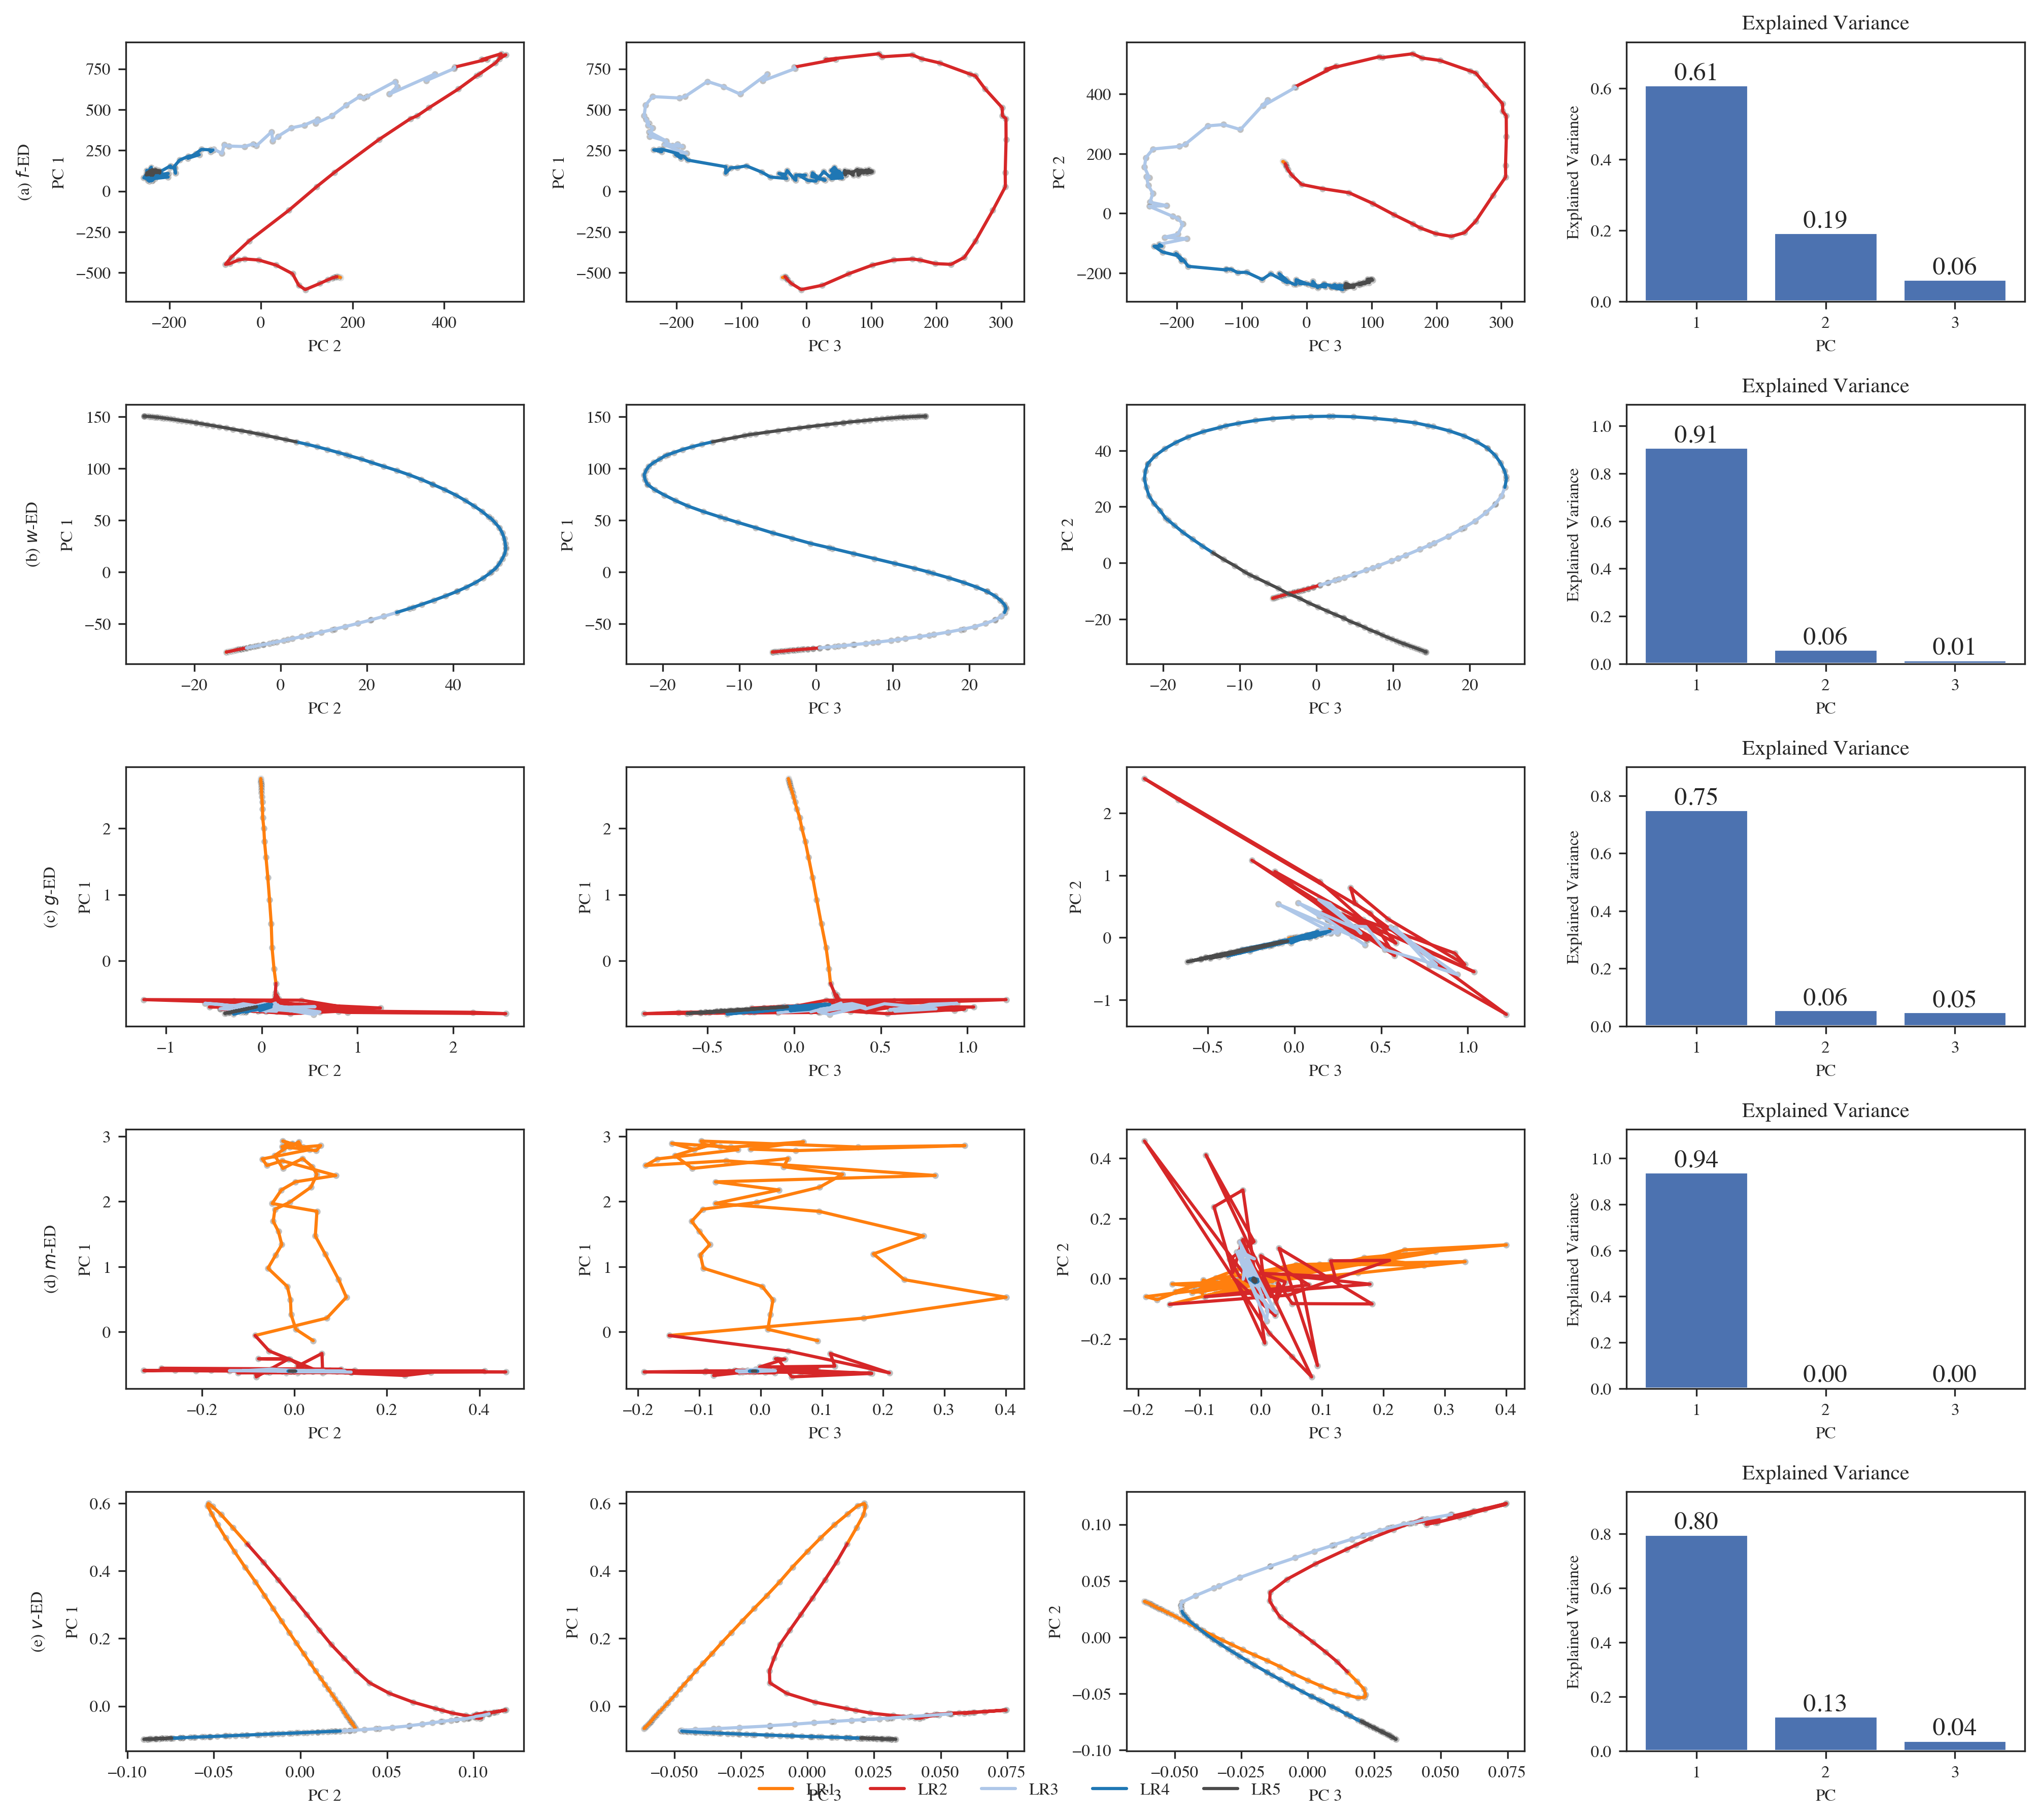

In [230]:
red =sns.color_palette('tab10', 4)[3]
deep_orange = sns.color_palette('tab20c', 5)[4]
light_orange = sns.color_palette('tab20', 4)[2]
light_orange = decrease_brightness(light_orange, 1.5)
light_blue = sns.color_palette('tab20', 4)[1]
dark_blue = sns.color_palette('tab20', 4)[0]
gray = sns.color_palette('tab20c', 18)[17]
gray = decrease_brightness(gray, 0.5)
colors = [light_orange, red, light_blue, dark_blue, gray]

fig = plot_essential_dynamics_grid(
    steps, 
    essential_dynamics_reduced[MODEL_SEED].values(), 
    TRANSITIONS, 
    num_pca_components=3, 
    figsize=(FULL_WIDTH * 2, FULL_HEIGHT * 6), 
    labels=['(a) $f$-ED', '(b) $w$-ED', '(c) $g$-ED', '(d) $m$-ED', '(e) $v$-ED'],
    palette=colors,
)        
fig.savefig(FIGURES / MODEL_ID / 'ED-variants.pdf')
plt.tight_layout()
plt.show()

# Structural indicators


## Embedding

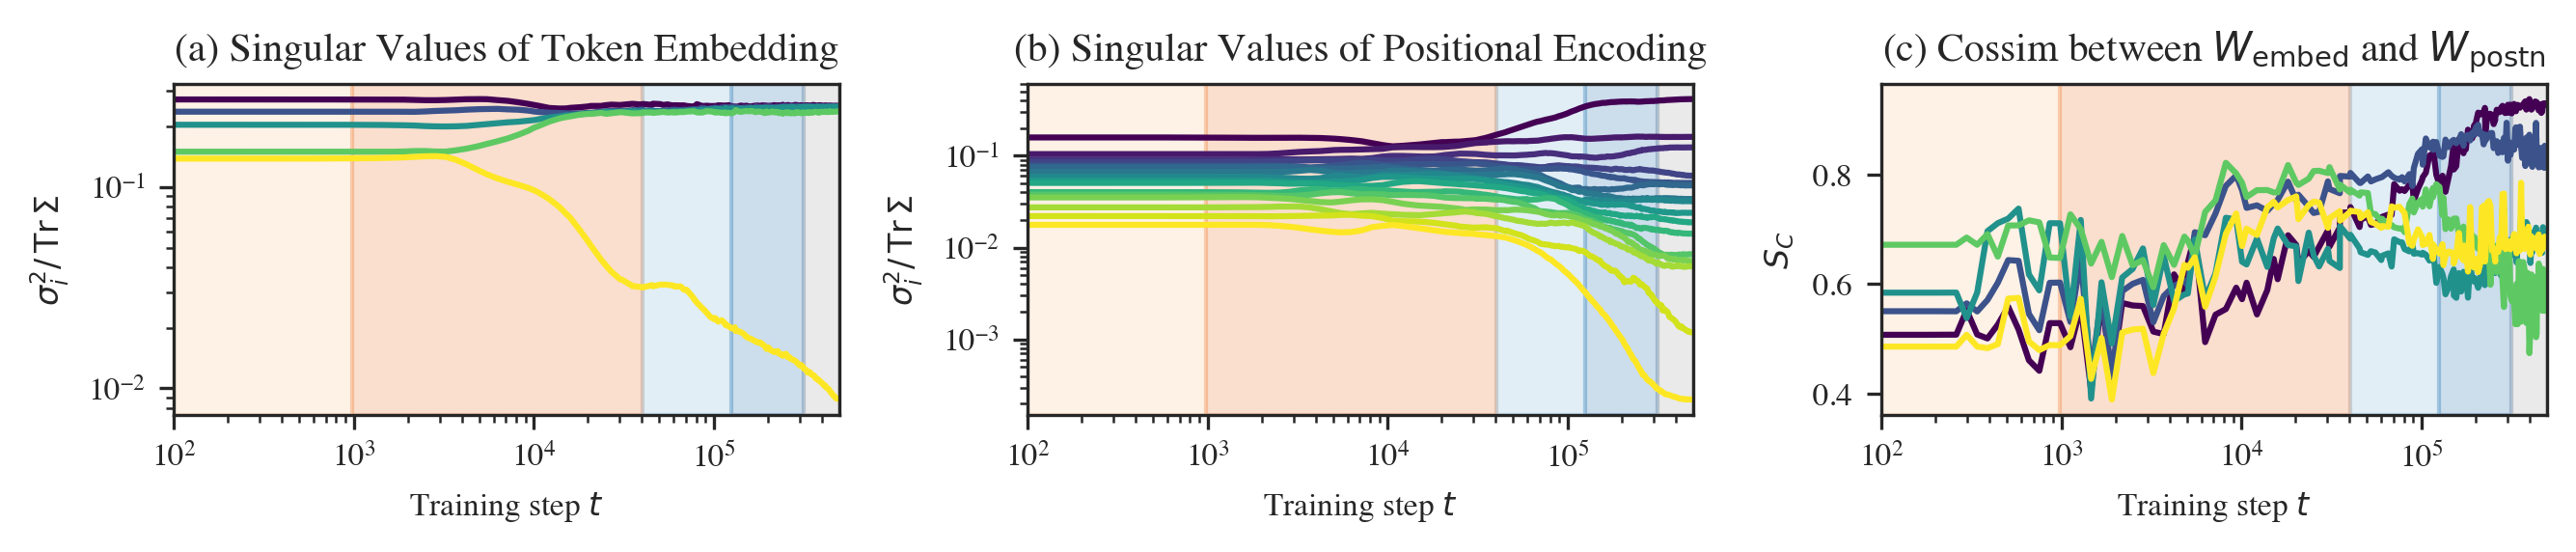

In [231]:

fig, axes = plt.subplots(1, 3, figsize=(FULL_WIDTH * 4 / 3, FULL_HEIGHT  ))

# PCA explained Variance over time

ax = axes[0]

sns.lineplot(data=embed_sing_vals.loc[embed_sing_vals.seed == MODEL_SEED], x="step", y="embed/S_normed", hue="index", palette="viridis", ax=ax)
ax.set_xscale('log')
ax.set_title("(a) Singular Values of Token Embedding")

ax = axes[1]

sns.lineplot(data=postn_sing_vals.loc[postn_sing_vals.seed == MODEL_SEED], x="step", y="postn/S_normed", hue="index", palette="viridis", ax=ax)
ax.set_xscale('log')
ax.set_title("(b) Singular Values of Positional Encoding")

for ax in axes[:2]:
    ax.set_ylabel(r"$\sigma_i^2/\,\mathrm{Tr}\,\Sigma$")
    ax.set_yscale('log')

ax = axes[2]

sns.lineplot(data=entangling.loc[entangling.seed == MODEL_SEED], x="step", y="cossim", hue="index", palette="viridis", ax=ax)
ax.set_xscale('log')
ax.set_title(r"(c) Cossim between $W_{\mathrm{embed}}$ and $W_{\mathrm{postn}}$")
ax.set_ylabel("$S_C$")

for ax in axes:
    ax.set_xlabel("Step $t$")
    ax.legend().remove()
    ax.set_xlim(100, 500_000)

plt.tight_layout()
fig.set_facecolor('white')
_plot_transitions(axes)

fig.savefig(FIGURES / MODEL_ID / "embed-collapse.pdf")

## Unembedding

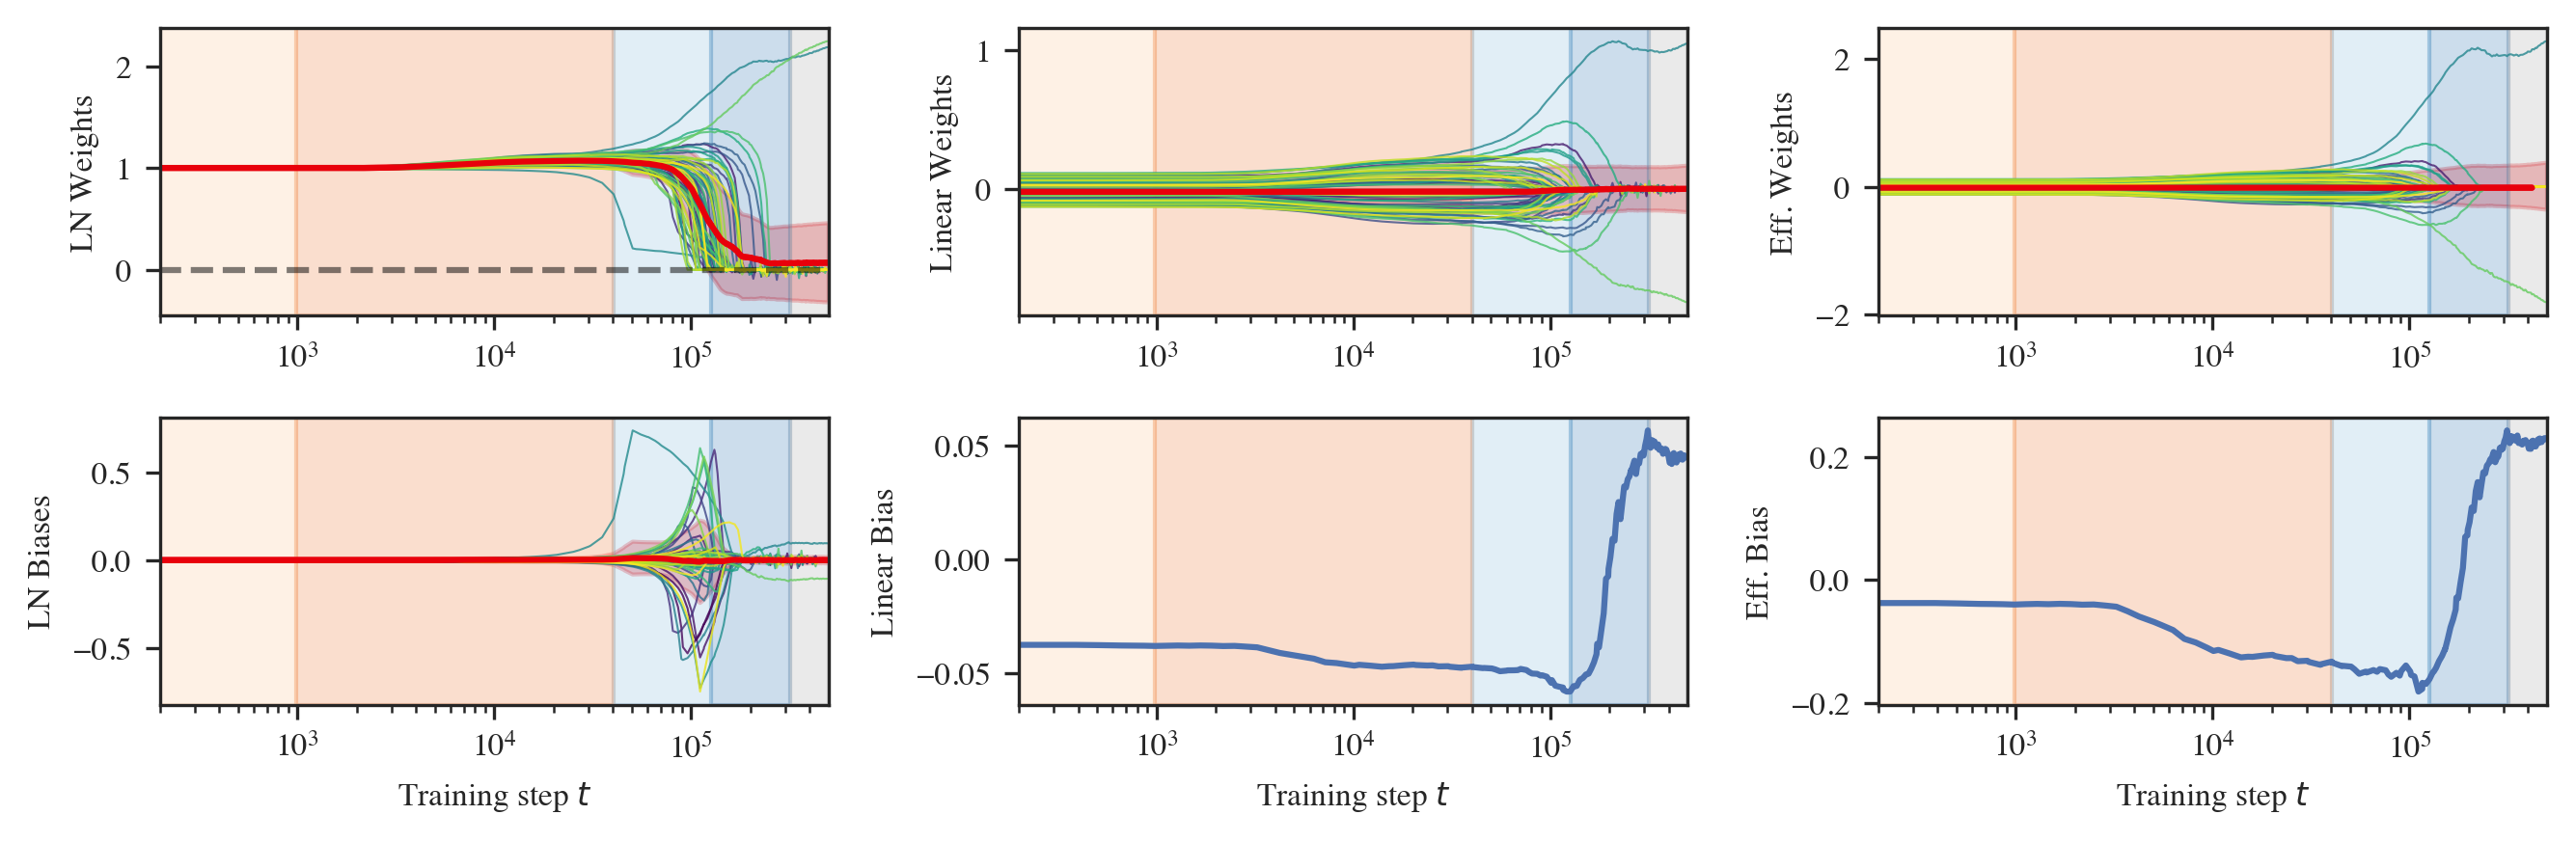

In [232]:
fig, axes = plt.subplots(2, 3, figsize=(FULL_WIDTH * 4 / 3, FULL_HEIGHT * 1.5))

fancy = {
    'ln.weight': 'LN Weights',
    'ln.bias': 'LN Biases',
    'linear.weight': 'Linear Weights',
    'linear.bias': 'Linear Bias',
}

_unembeddings = unembeddings.loc[unembeddings.seed == MODEL_SEED]

for i, layer in enumerate(["ln", "linear"]):
    for j, layer_subset in enumerate(["weight", "bias"]):
        data_subset = _unembeddings.loc[_unembeddings.layer == f"{layer}.{layer_subset}"]
        means = data_subset.groupby('step').mean()
        stds = data_subset.groupby('step').std()

        if i + j != 2:
            sns.lineplot(data=means, x="step", y='p', color=BRED, ax=axes[j, i])
            sns.lineplot(data=data_subset, x="step", y="p", hue="i", palette="viridis", ax=axes[j, i], alpha=0.8, linewidth=0.5)
            sns.lineplot(data=means, x="step", y='p', color=BRED, ax=axes[j, i])
            axes[j, i].fill_between(means.index, means.p - stds.p, means.p + stds.p, alpha=0.25, color=BRED)
            axes[j, i].legend().remove()
            # handles = [axes[j, i].get_legend_handles_labels()[0][0]]
            # axes[j, i].legend(labels=['Mean'], handles=handles, loc='upper left', frameon=False)

        else:
            sns.lineplot(data=data_subset, x="step", y="p", hue="i", ax=axes[j, i], color=BRED)
            axes[j, i].legend().remove()   

        axes[j, i].set_xscale('log')
        axes[j, i].set_ylabel(fancy[f"{layer}.{layer_subset}"])
        axes[j, i].set_xlim(200, 500000)
        axes[j, i].set_xlabel("Training step $t$")
        # axes[j, i].set_ylabel("Weight")


axes[0,0].hlines(0, 0, 500_000, color='black', linestyle='--', alpha=0.5)

# fig.suptitle("Unembedding Weights over Time", fontsize=14)

axes[1,1].legend().remove()
plt.tight_layout()

ax = axes[0, 2]

_reduced_unembeddings = reduced_unembeddings.loc[reduced_unembeddings.seed == MODEL_SEED].sort_values(by="step")
means = _reduced_unembeddings.loc[_reduced_unembeddings.subset == "weight"].groupby('step').mean()["p"]
stds = _reduced_unembeddings.loc[_reduced_unembeddings.subset == "weight"].groupby('step').std()["p"]

sns.lineplot(data=_reduced_unembeddings.loc[_reduced_unembeddings.subset == "weight"], x="step", y=means, ax=ax, color=BRED, label="Mean")
sns.lineplot(data=_reduced_unembeddings.loc[_reduced_unembeddings.subset == "weight"], x="step", y="p", hue="i", palette="viridis", ax=ax, alpha=0.8, linewidth=0.5)
sns.lineplot(data=_reduced_unembeddings.loc[_reduced_unembeddings.subset == "weight"], x="step", y=means, ax=ax, color=BRED)
ax.fill_between(means.index, means - stds, means + stds, alpha=0.25, color=BRED)
ax.set_title(f"{layer}.{layer_subset}")

ax = axes[1, 2]
sns.lineplot(data=_reduced_unembeddings.loc[_reduced_unembeddings.subset == "bias"], x="step", y="p", hue="i", ax=ax, color=BRED)
    
for ax, subset in zip([axes[0, 2], axes[1, 2]], ["Eff. Weights", "Eff. Bias"]):
    ax.legend().remove()
    ax.set_xscale('log')
    ax.set_ylabel(f"{subset}")
    ax.set_xlabel("Training step $t$")
    # ax.set_ylabel("Weight")
    ax.set_title('')
    ax.set_xlim(200, 500000)

_plot_transitions(axes)

for ax in axes[0]:
    ax.set_xlabel('')

plt.tight_layout()

fig.savefig(FIGURES / MODEL_ID / "unembed-collapse.pdf")
# handles = [ax.get_legend_handles_labels()[0][0] for ax in axes]
# axes[0, 2].legend(labels=['Mean'], handles=handles, loc='upper left', frameon=False)
# ax.get_legend_handles_labels();

## Layer norms

In [233]:
if os.path.exists(ANALYSIS / MODEL_ID / 'lr-unembed.pt'):
    print("Loading from disk")
    with open(ANALYSIS / MODEL_ID / 'lr-unembed.pt', 'rb') as f:
        (unembedding_lns, block_1_attn_lns, block_1_mlp_lns, block_2_attn_lns, block_2_mlp_lns) = pickle.load(f)
else:     
    print("Computing...")
    unembedding_lns = [get_ln(model, 'token_sequence_transformer.unembedding.0') for model in all_models[MODEL_SEED]]
    block_1_attn_lns =  [get_ln(model, 'token_sequence_transformer.blocks.0.layer_norms.0') for model in all_models[MODEL_SEED]]
    block_1_mlp_lns =  [get_ln(model, 'token_sequence_transformer.blocks.0.layer_norms.1') for model in all_models[MODEL_SEED]]
    block_2_attn_lns =  [get_ln(model, 'token_sequence_transformer.blocks.1.layer_norms.0') for model in all_models[MODEL_SEED]]
    block_2_mlp_lns =  [get_ln(model, 'token_sequence_transformer.blocks.1.layer_norms.1') for model in all_models[MODEL_SEED]]

    with open(ANALYSIS / MODEL_ID / 'lr-unembed.pt', 'wb') as f:
        pickle.dump((unembedding_lns, block_1_attn_lns, block_1_mlp_lns, block_2_attn_lns, block_2_mlp_lns), f)

all_lns = {
    "Unembedding": unembedding_lns,
    "Block 1 Pre-Attention": block_1_attn_lns,
    "Block 1 Pre-MLP": block_1_mlp_lns,
    "Block 2 Pre-Attention": block_2_attn_lns,
    "Block 2 Pre-MLP": block_2_mlp_lns,
}

unembedding_ln_norms = [ln_norm(weight, bias) for weight, bias in unembedding_lns]
block_1_attn_ln_norms = [ln_norm(weight, bias) for weight, bias in block_1_attn_lns]
block_1_mlp_ln_norms = [ln_norm(weight, bias) for weight, bias in block_1_mlp_lns]
block_2_attn_ln_norms = [ln_norm(weight, bias) for weight, bias in block_2_attn_lns]
block_2_mlp_ln_norms = [ln_norm(weight, bias) for weight, bias in block_2_mlp_lns]

unembedding_ln_norms_std = np.array([ln_norm_std(weight, bias) for weight, bias in unembedding_lns])
block_1_attn_ln_norms_std = np.array([ln_norm_std(weight, bias) for weight, bias in block_1_attn_lns])
block_1_mlp_ln_norms_std = np.array([ln_norm_std(weight, bias) for weight, bias in block_1_mlp_lns])
block_2_attn_ln_norms_std = np.array([ln_norm_std(weight, bias) for weight, bias in block_2_attn_lns])
block_2_mlp_ln_norms_std = np.array([ln_norm_std(weight, bias) for weight, bias in block_2_mlp_lns])

def frac_nonzero(weight, eps=1e-1):
    return (weight.abs() > eps).float().mean().detach().cpu().numpy()

unembedding_ln_norm_nonzero = [frac_nonzero(weight) for weight, bias in unembedding_lns]
block_1_attn_ln_norm_nonzero = [frac_nonzero(weight) for weight, bias in block_1_attn_lns]
block_1_mlp_ln_norm_nonzero = [frac_nonzero(weight) for weight, bias in block_1_mlp_lns]
block_2_attn_ln_norm_nonzero = [frac_nonzero(weight) for weight, bias in block_2_attn_lns]
block_2_mlp_ln_norm_nonzero = [frac_nonzero(weight) for weight, bias in block_2_mlp_lns]


Loading from disk


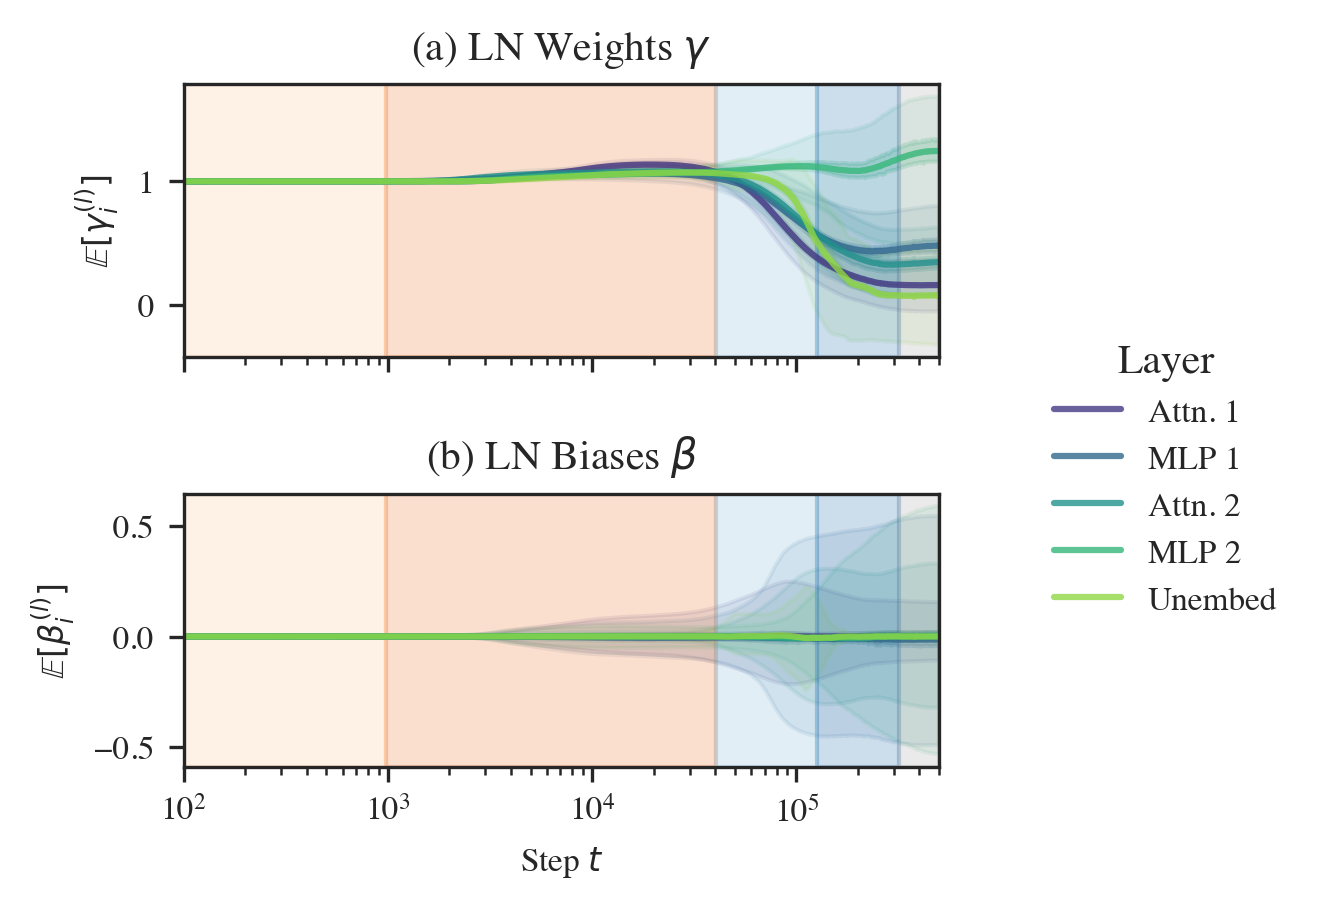

In [234]:
fig, axes = plt.subplots(2, 1, figsize=(WIDTH, HEIGHT * 1.5))

# Fill between using the stdp
colors = sns.color_palette("viridis", 5)

for i, type_ in enumerate(["weight", "bias"]):
    sns.lineplot(data=ln_stats, x="step", y=f"{type_}/mean", hue="layer", palette="viridis", ax=axes[i], alpha=0.8)

    for l, layer in enumerate(ln_stats.layer.unique()):
        layer_ln_stats = ln_stats.loc[(ln_stats.layer == layer) & (ln_stats.seed == MODEL_SEED)]

        axes[i].fill_between(steps, layer_ln_stats[f"{type_}/mean"] - layer_ln_stats[f"{type_}/std"], layer_ln_stats[f"{type_}/mean"] + layer_ln_stats[f"{type_}/std"], alpha=0.1, color=colors[l])

for ax in axes.flatten():
    plot_transitions(ax, TRANSITIONS, colors=LR_TRANSITION_COLORS)
    ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_xlim(100, 500_000)
    ax.legend().remove()

layers = ["Attn. 1", '_', "MLP 1",  '_', "Attn. 2", '_', "MLP 2", '_', "Unembed"]
axes[0].set_title(r"(a) LN Weights $\gamma$")
axes[0].set_xlabel("")
axes[0].set_xticklabels([])
axes[1].set_title(r"(b) LN Biases $\beta$")

axes[0].set_ylabel(r'$\mathbb{E}[\gamma^{(l)}_i]$')
axes[1].set_ylabel(r'$\mathbb{E}[\beta^{(l)}_i]$')
# axes[1].legend(layers, title="", loc='lower left', bbox_to_anchor=(-0.25, -.5), frameon=False, ncols=5)
axes[1].legend(layers, title="Layer", loc='center', bbox_to_anchor=(1.3, 1.05), frameon=False, ncols=1)
ax.set_xlabel('Step $t$')

# plt.tight_layout(pad=0.1)
fig.set_facecolor('white')
fig.subplots_adjust(hspace=0.5)
fig.savefig(FIGURES / MODEL_ID / "LN-collapse.pdf")
# Increase space between subplots to fit legend
# plt.tight_layout()

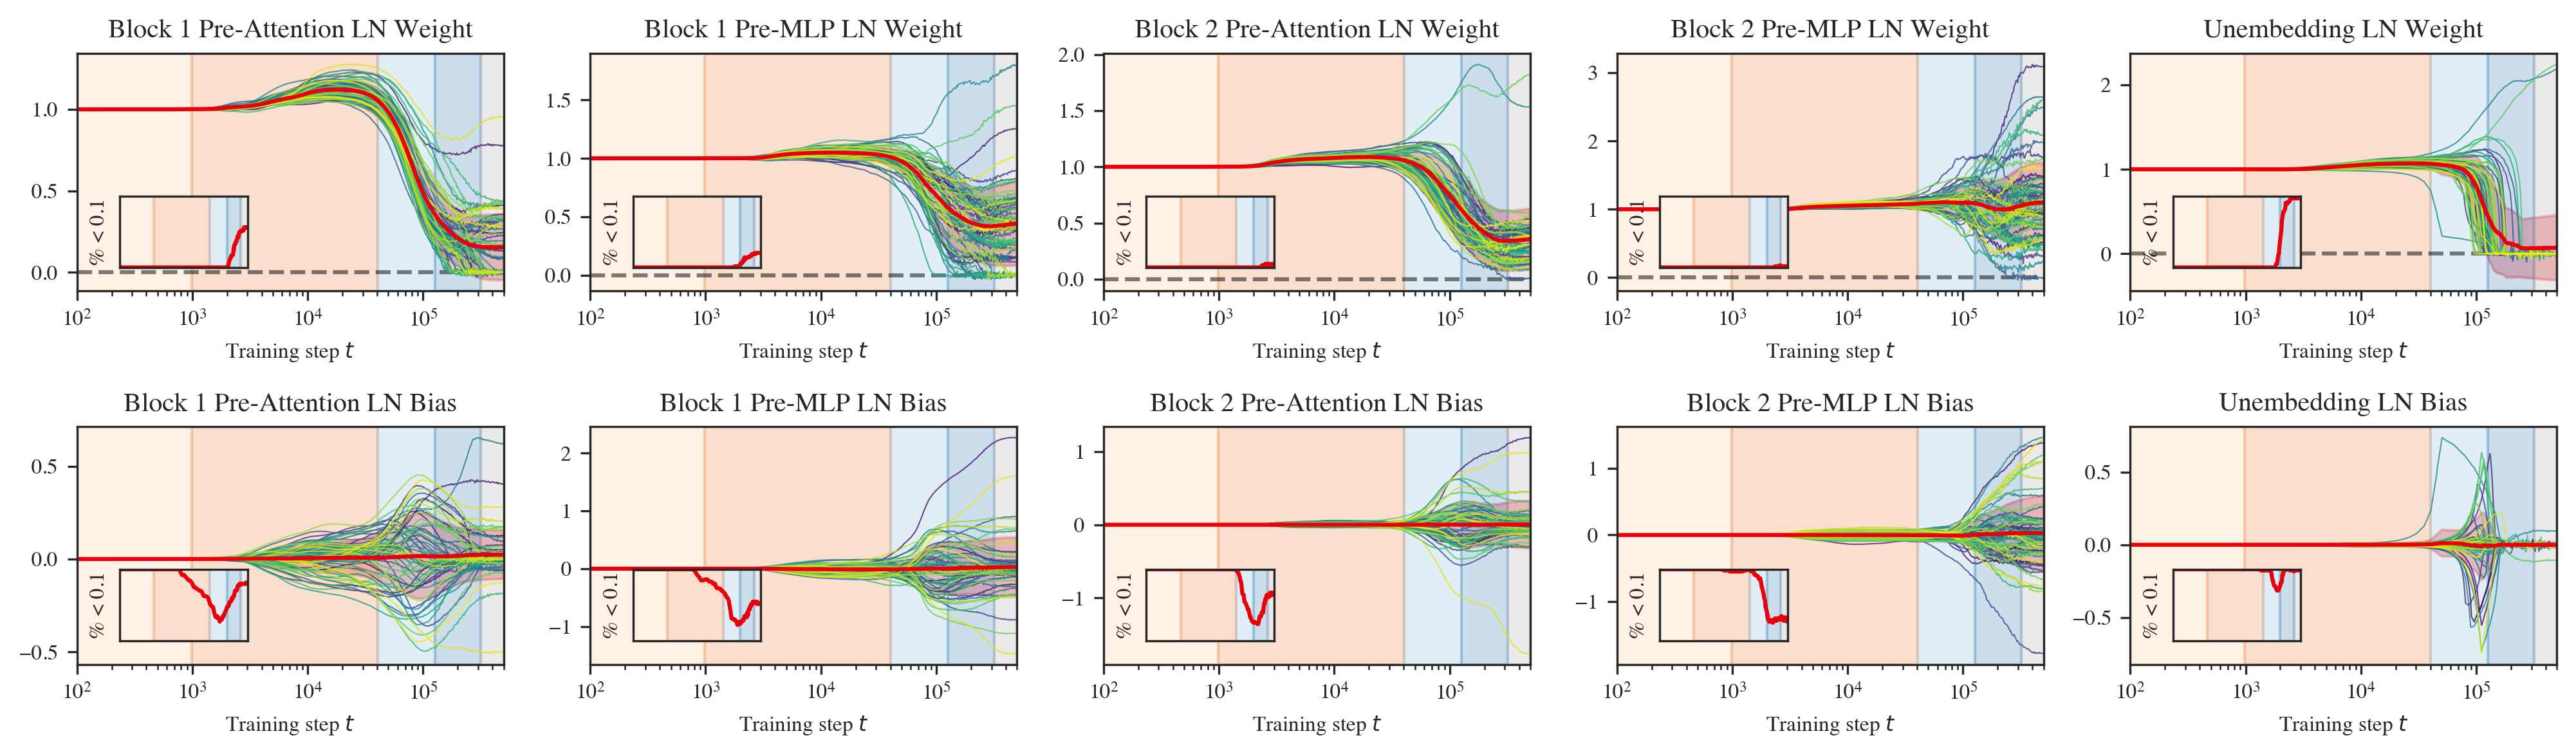

In [248]:
fig, axes = plt.subplots(2, len(all_lns), figsize=(FULL_WIDTH * 2, FULL_HEIGHT * 2 ))


def frac_eff_zero(w):
    return (w.abs() < 1e-1).float().mean().detach().cpu().numpy()

insets = []

for i, (name, lns) in enumerate(list(all_lns.items())[1:] + list(all_lns.items())[:1]):
    axes[0, i].axhline(0, color='black', linestyle='--', alpha=0.5)

    # Color palette to viridis
    plt.set_cmap('viridis')

    axes[0, i].plot(steps, np.array([w.detach().cpu().numpy() for w, b in lns]), alpha=0.8, linewidth=0.5)
    axes[1, i].plot(steps, np.array([b.detach().cpu().numpy() for w, b in lns]), alpha=0.8, linewidth=0.5)

    w_means = np.array([w.detach().cpu().numpy() for w, b in lns]).mean(axis=-1)
    b_means = np.array([b.detach().cpu().numpy() for w, b in lns]).mean(axis=-1)
    w_stds = np.array([w.detach().cpu().numpy() for w, b in lns]).std(axis=-1)
    b_stds = np.array([b.detach().cpu().numpy() for w, b in lns]).std(axis=-1)

    axes[0, i].plot(steps, w_means, color=BRED)
    axes[0, i].fill_between(steps, w_means - w_stds, w_means + w_stds, alpha=0.25, color=BRED)
    axes[1, i].plot(steps, b_means, color=BRED)
    axes[1, i].fill_between(steps, b_means - b_stds, b_means + b_stds, alpha=0.25, color=BRED)

    axes[0, i].set_title(f"{name} LN Weight")
    axes[1, i].set_title(f"{name} LN Bias")
    
    # axes[0, i].legend(labels=['Mean'], handles=handles, loc='upper left', frameon=False)
    # axes[1, i].legend(labels=['Mean'], handles=handles, loc='upper left', frameon=False)
    # axes[0, i].legend().remove()
    # axes[1, i].legend().remove()

    axinset0 = axes[0, i].inset_axes([0.10, 0.1, 0.3, 0.3])
    axinset1 = axes[1, i].inset_axes([0.10, 0.1, 0.3, 0.3])

    frac_w_eff_zero = np.array([frac_eff_zero(w) for w, b in lns])
    frac_b_eff_zero = np.array([frac_eff_zero(b) for w, b in lns])
    
    axinset0.plot(steps, frac_w_eff_zero, color=BRED)
    axinset1.plot(steps, frac_b_eff_zero, color=BRED)

    insets.extend([axinset0, axinset1])
    

plot_transitions(axes, TRANSITIONS, colors=LR_TRANSITION_COLORS)
plot_transitions(insets, TRANSITIONS, colors=LR_TRANSITION_COLORS)
plt.tight_layout()

for ax in [*axes.flatten(), *insets]:
    ax.set_xscale('log')
    # ax.set_yscale('symlog')
    ax.set_xlim(100, 500000)

for ax in insets:
    ax.set_ylim(0, 1)
    ax.set_ylabel("% < 0.1")
    ax.set_yticks([])
    ax.set_xticks([])  # Remove x-ticks
    ax.set_xticklabels([])  # Remove x-tick labels
    ax.grid(False)
    ax.set_xlabel('')

fig.savefig(FIGURES / MODEL_ID / "LN-collapse-detail.pdf")

## Attention 

In [236]:
def plot_attention_patterns(df: pd.DataFrame, num_blocks: int, num_heads: int, num_tokens: int, title=None, save: Optional[str] = None, figsize=(20, 25), logx=False, logy=False, metric="mean", label="Entropy", full_block=True, full_head=True, y_axis=True):
    fig = plt.figure(figsize=figsize)

    if title:
        plt.suptitle(label + "\n" + title)

    num_cols = num_blocks * 2
    num_rows = int(full_block) + int(full_head) + num_heads

    fig.set_facecolor('white')

    axes = []

    if full_block:
        # Create subplot for mean entropy of first two blocks
        ax0 = plt.subplot2grid((num_rows, num_cols), (0, 0), colspan=num_cols)
        block_cmap = sns.color_palette("viridis", num_blocks * 2)

        for b in range(num_blocks):
            for x_or_y in (1, 0):
                ax0.plot(df.step, df[f"block_{b}/{'x' if not x_or_y else 'y'}/{metric}"], label=f"Block {b + 1} {'xs' if not x_or_y else 'ys'}", color=block_cmap[b+1-x_or_y])

        ax0.set_title("Blocks")
        ax0.set_xlabel("Step, $t$")
        ax0.set_ylabel(label)
        ax0.legend()

        axes.append(ax0)

    if full_head:
        # Create subplots for each block, showing entropy in different heads
        ax1 = [plt.subplot2grid((num_rows, num_cols), (int(full_block), i), colspan=1) for i in range(num_blocks * 2)]
        head_cmap = sns.color_palette("viridis", num_heads)
            
        for b in range(num_blocks):
            for x_or_y in (1, 0):
                _ax1 = ax1[2 * b + 1-x_or_y]
                _ax1.set_title(f"Block {b + 1} {'xs' if not x_or_y else 'ys'}")
                # _ax1.set_xlabel("Step, $t$")
                # _ax1.set_ylabel(label)
                
                for h in range(num_heads):
                    series = df[f"block_{b}/head_{h}/{'x' if not x_or_y else 'y'}/{metric}"]
                    _ax1.plot(df.step, series, label=f"Head {h + 1}", color=head_cmap[h])

                _ax1.set_xticks([])
                _ax1.set_xticklabels([])
                
        ax1[0].legend()
        ax1[0].set_ylabel(label)

        axes.extend(ax1)

    # Create subplots for each head in each block, detailing entropy for each token
    ax2 = [plt.subplot2grid((num_rows, num_cols), (i//(num_cols) + int(full_block) + int(full_head), i%(num_cols))) for i in range(num_heads * num_blocks * 2)]
    ax_idx = 0

    for b in range(num_blocks):
        for x_or_y in (0, 1):
            ax2[ax_idx].set_ylabel(label)
            token_cmap = sns.color_palette("viridis" if not x_or_y else "magma", num_tokens)
            for h in range(num_heads):
                _ax2 = ax2[ax_idx]
                _ax2.set_title(f"$b={b + 1}, h={h + 1}, {'x' if not x_or_y else 'y'}_k$")
                # ax2[ax_idx].set_xlabel("Step, $t$")
                # ax2[ax_idx].set_ylabel(label)

                for t in range(int(x_or_y), num_tokens, 2):
                    series = df[f"block_{b}/head_{h}/token_{t}/{metric}"]

                    if y_axis:
                        _ax2.axhline(0, color='black', linestyle='--', linewidth=0.5)

                    _ax2.plot(df.step, series, label=f"Token {'x' if not x_or_y else 'y'} {t + 1}", color=token_cmap[t])
                    
                _ax2.set_xticks([])
                _ax2.set_xticklabels([])
                ax_idx += 1

    for ax in ax2[-4:]:
        ax.set_xlabel("Step $t$")
        ax.set_xticks([10**i for i in range(6)]) + [500_000]
        ax.set_xticklabels([10**i for i in range(6)]) + [500_000]

    axes.extend(ax2)
    for ax in axes:
        if logx:
            ax.set_xscale("log")
        if logy:
            ax.set_yscale("log")

        ax.set_xlim(100, 500_000)

    _plot_transitions(axes)


    # ax2[0].legend()
    # ax2[1].legend()
    viridis = sns.color_palette("viridis", 8)
    magma = sns.color_palette("magma", 8)
    colors = [(viridis[c] if not x_or_y else magma[c]) for c in range(8) for x_or_y in (0, 1)]
    labels = [f"${'x' if not x_or_y else 'y'}_{i + 1}$" for i in range(8) for x_or_y in (0, 1)]

    # Handles (patches)
    # handles = [mpatches.Line(color=colors[i], label=labels[i * 2 + x_or_y]) for i in range(8) for x_or_y in (0, 1)]
    # Handles (lines)
    handles = [plt.Line2D([0,0],[0,0], color=colors[i], label=labels[i]) for i in range(16)]
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.subplots_adjust(bottom=0.2)      
    fig.legend(handles=handles, loc='lower center', ncol=8, frameon=False, bbox_to_anchor=(0.5, 0.01))

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)

    return fig, axes

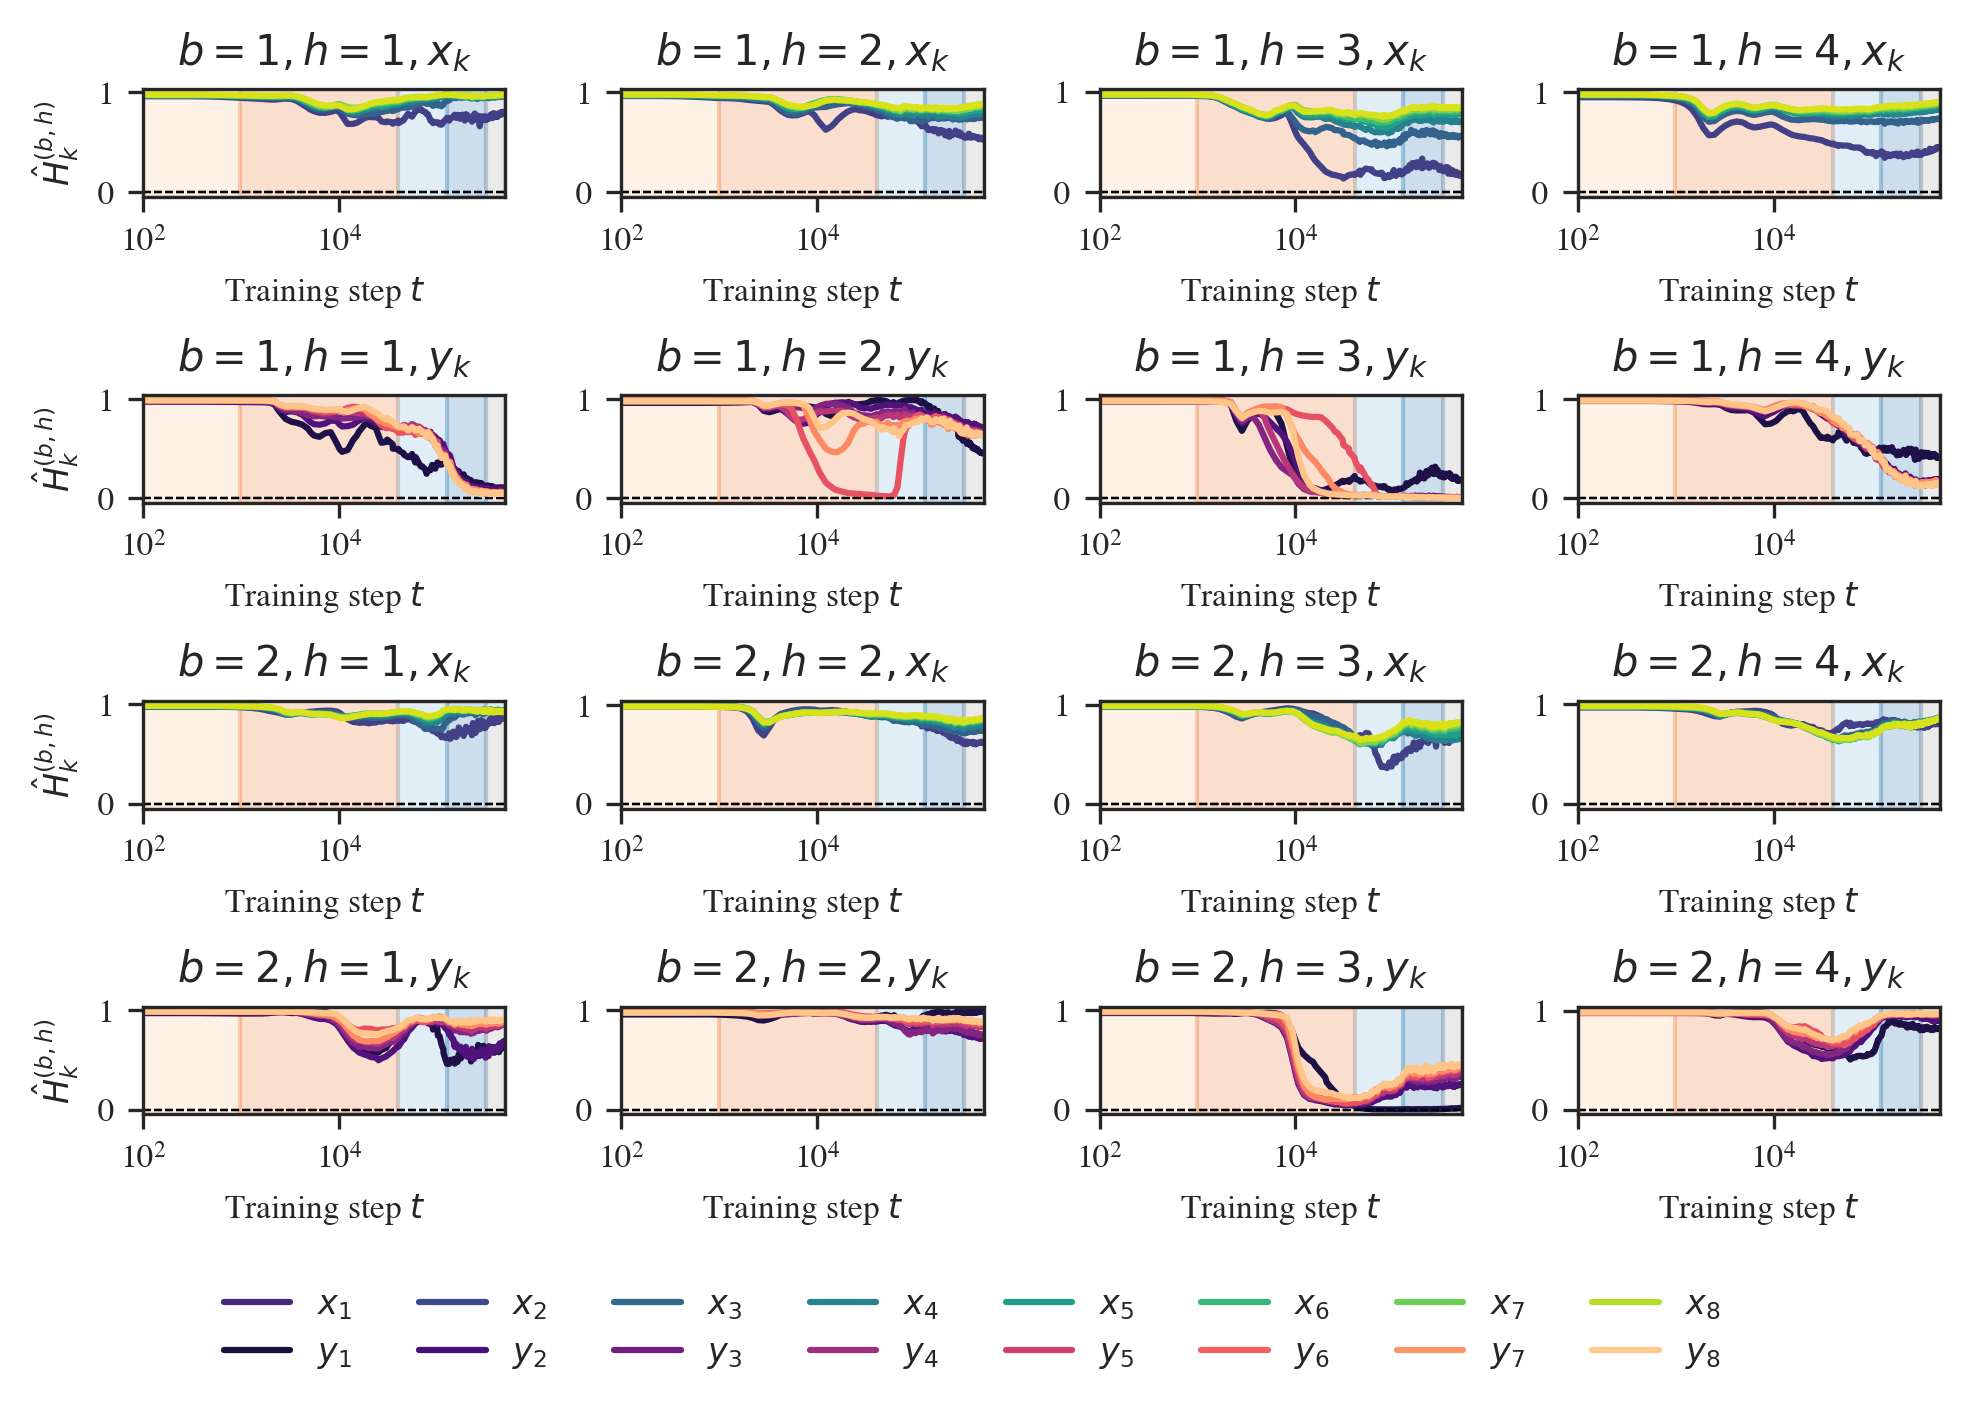

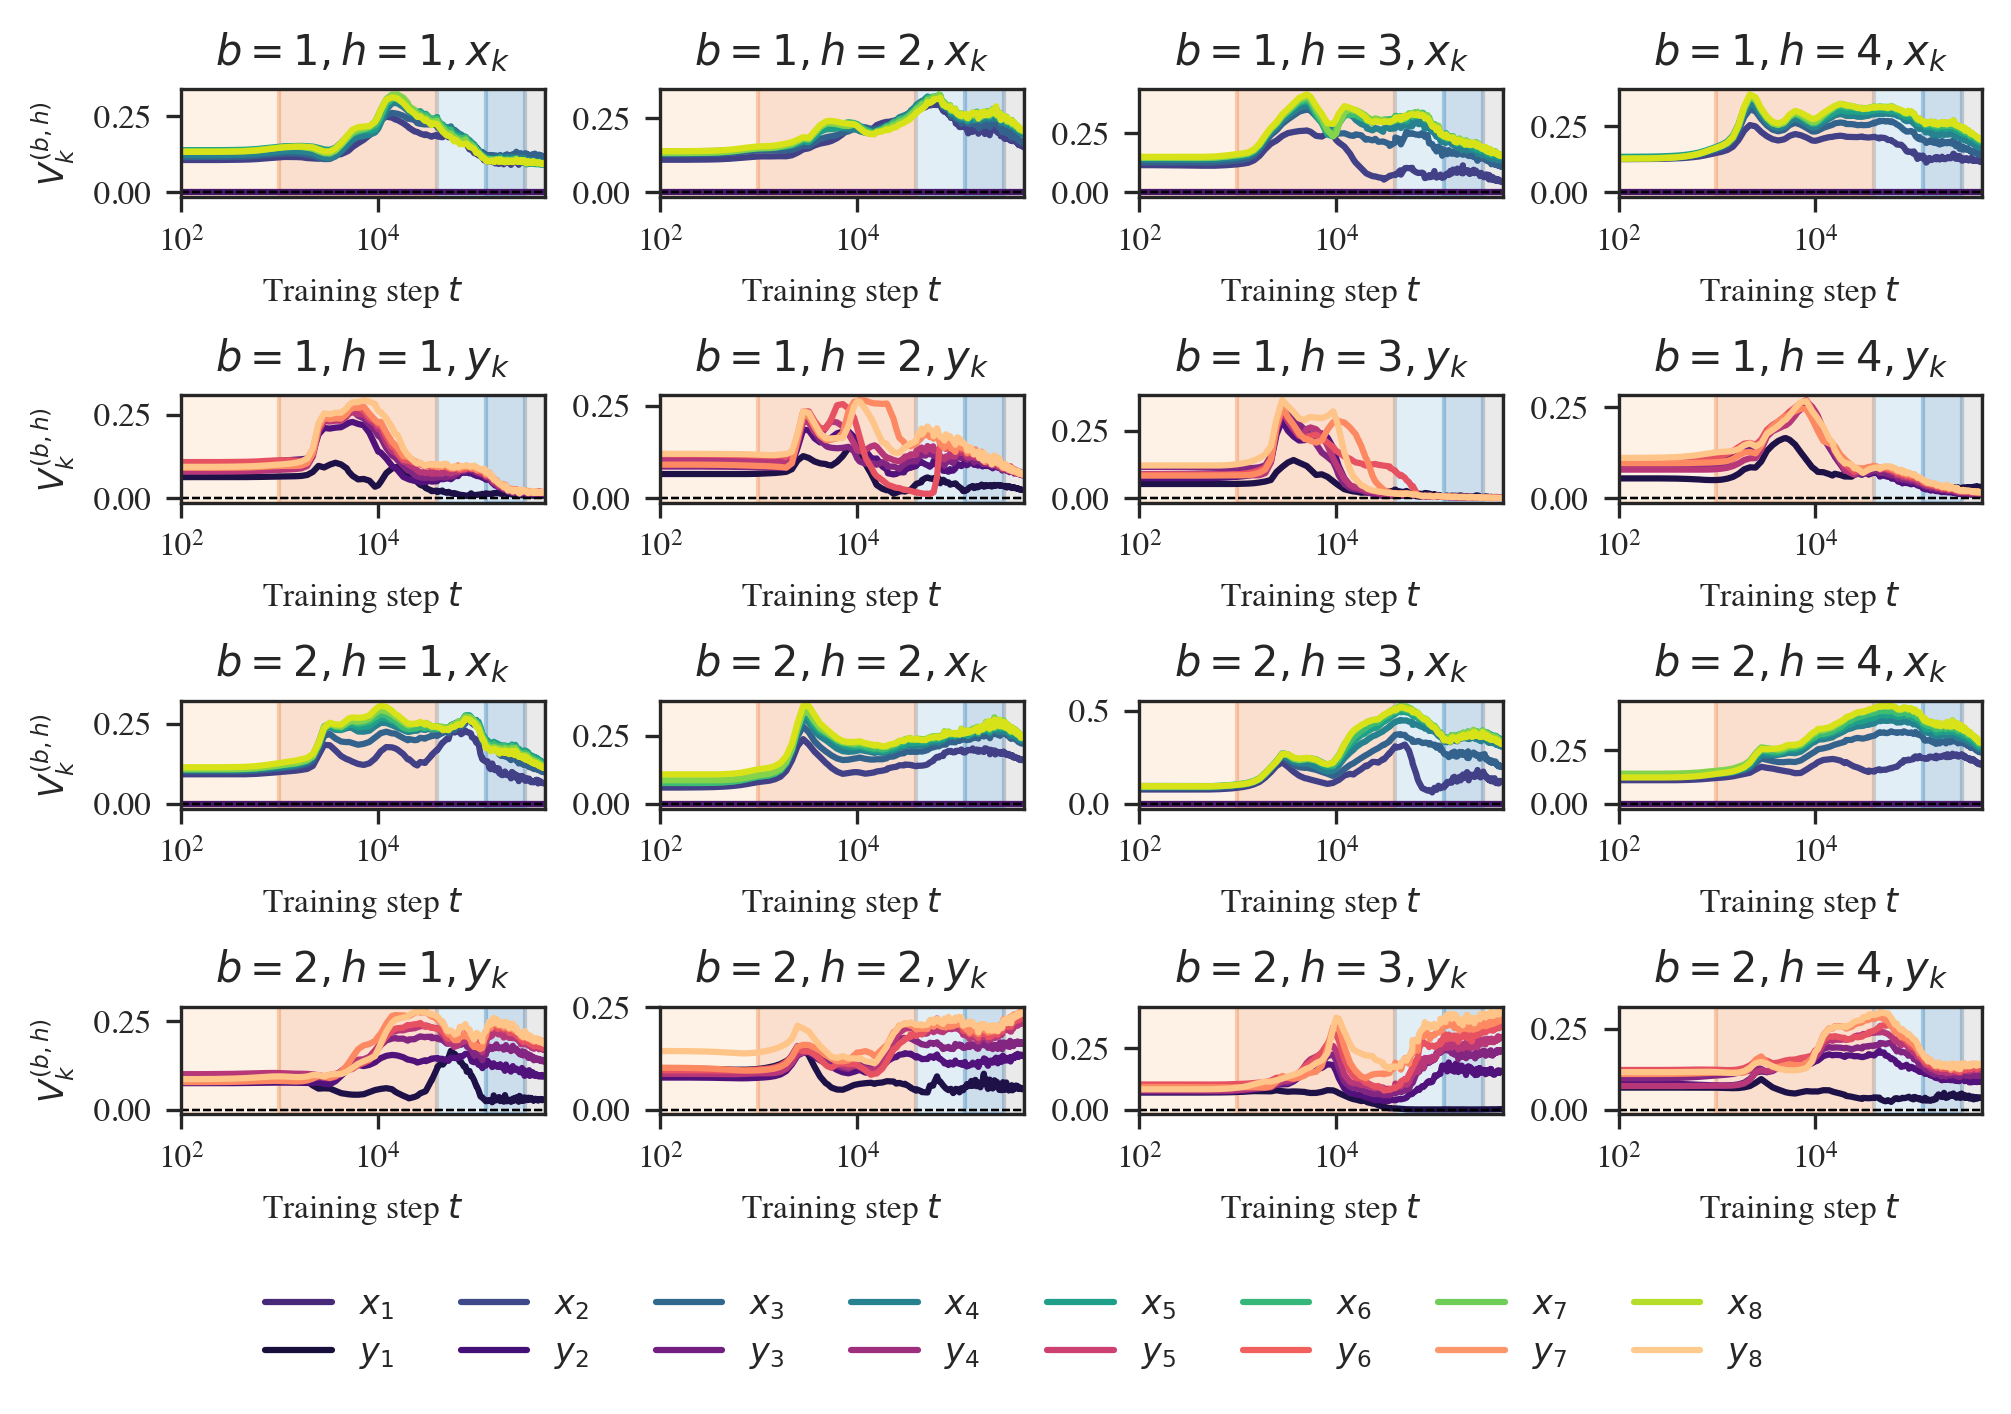

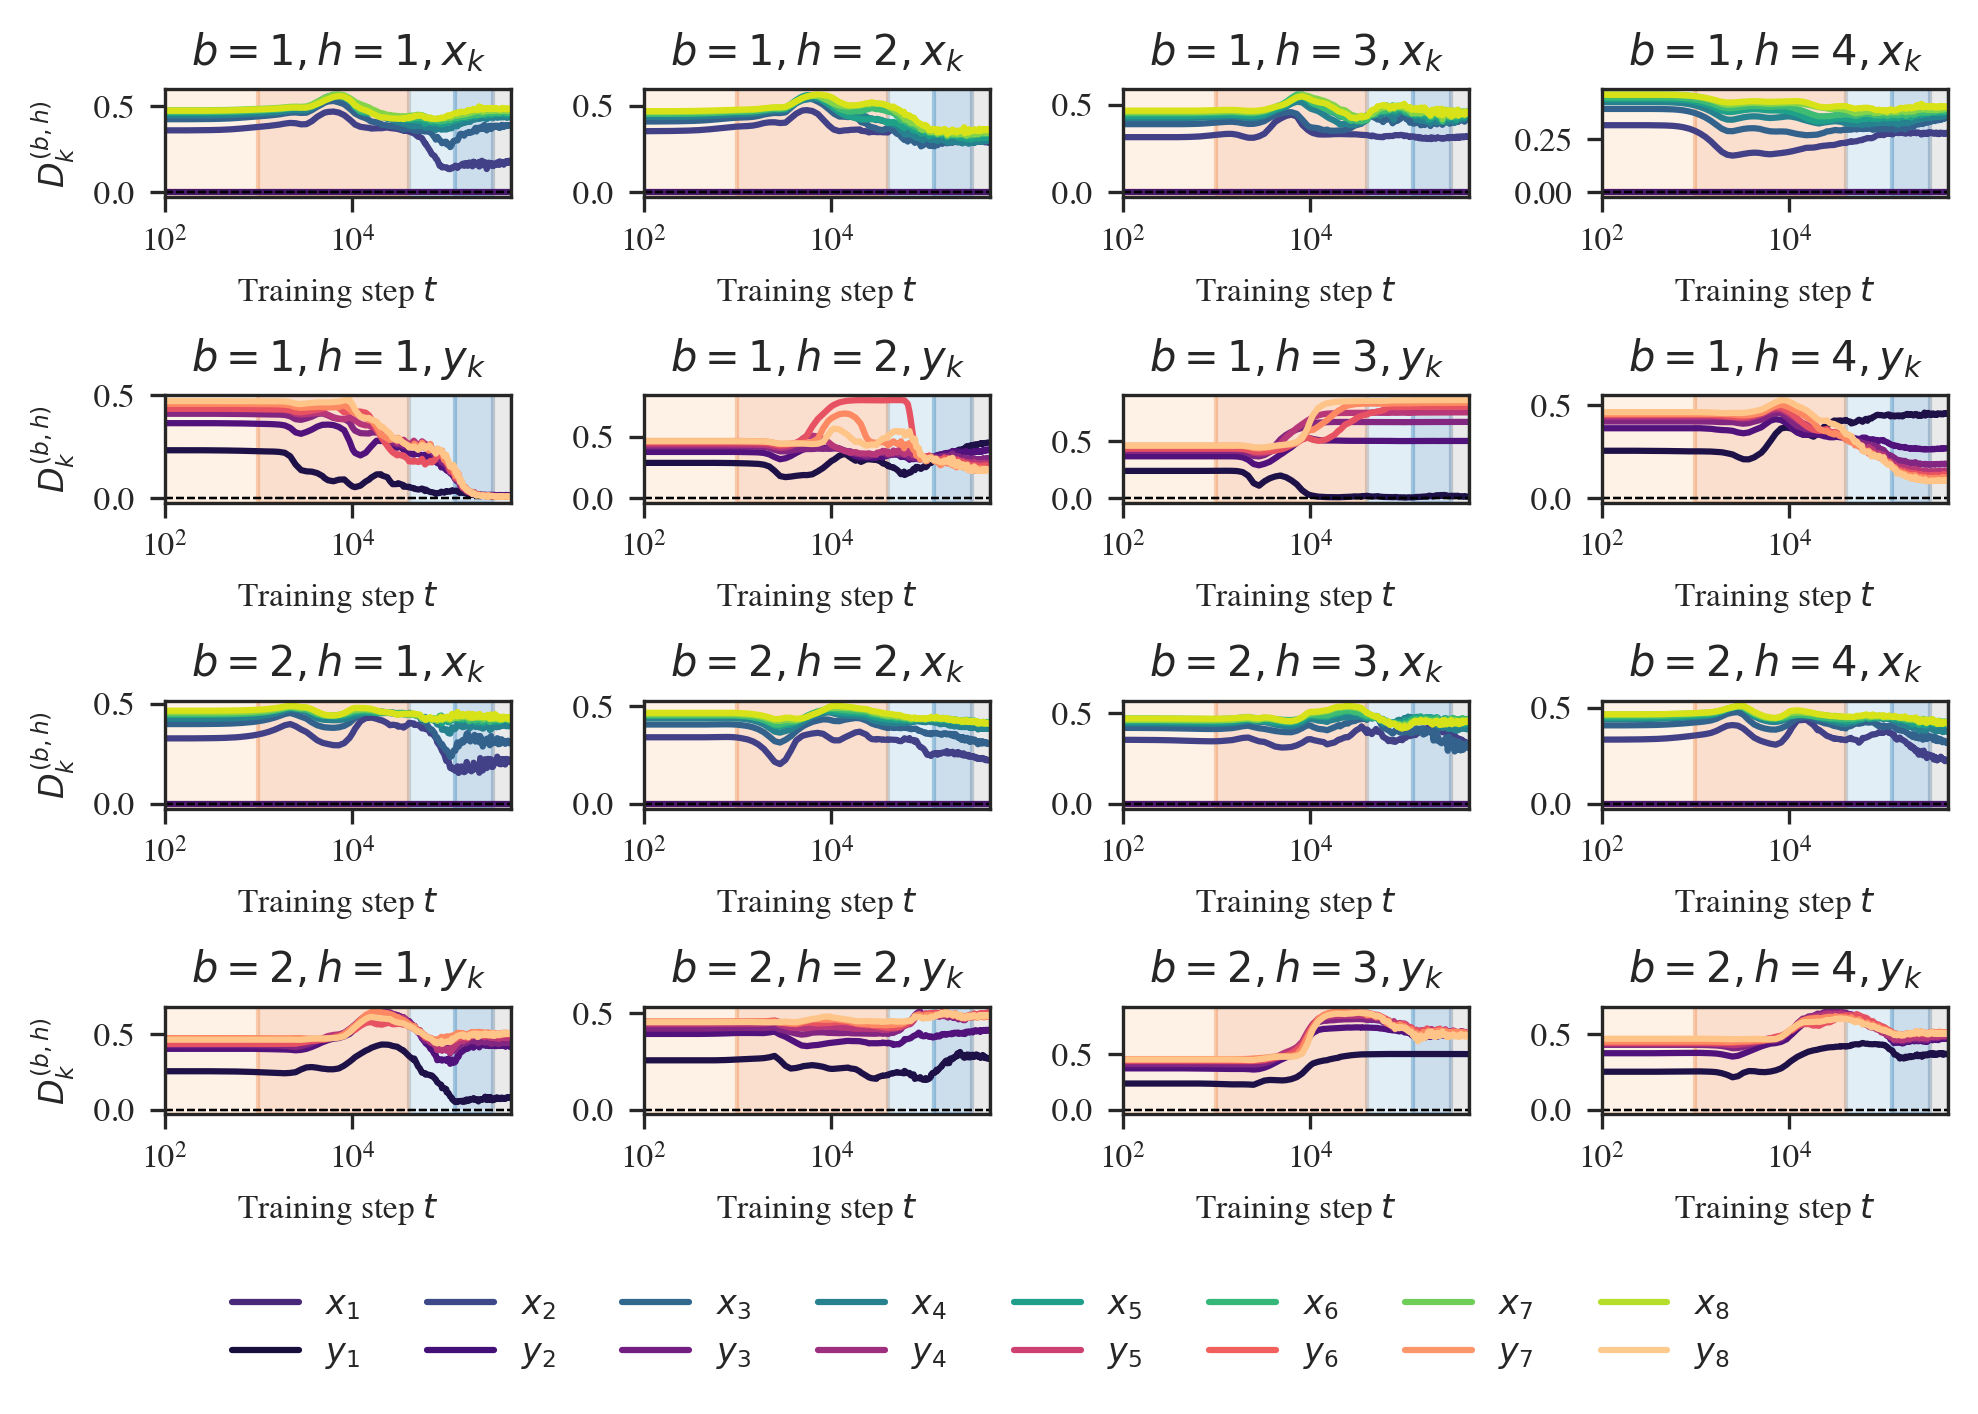

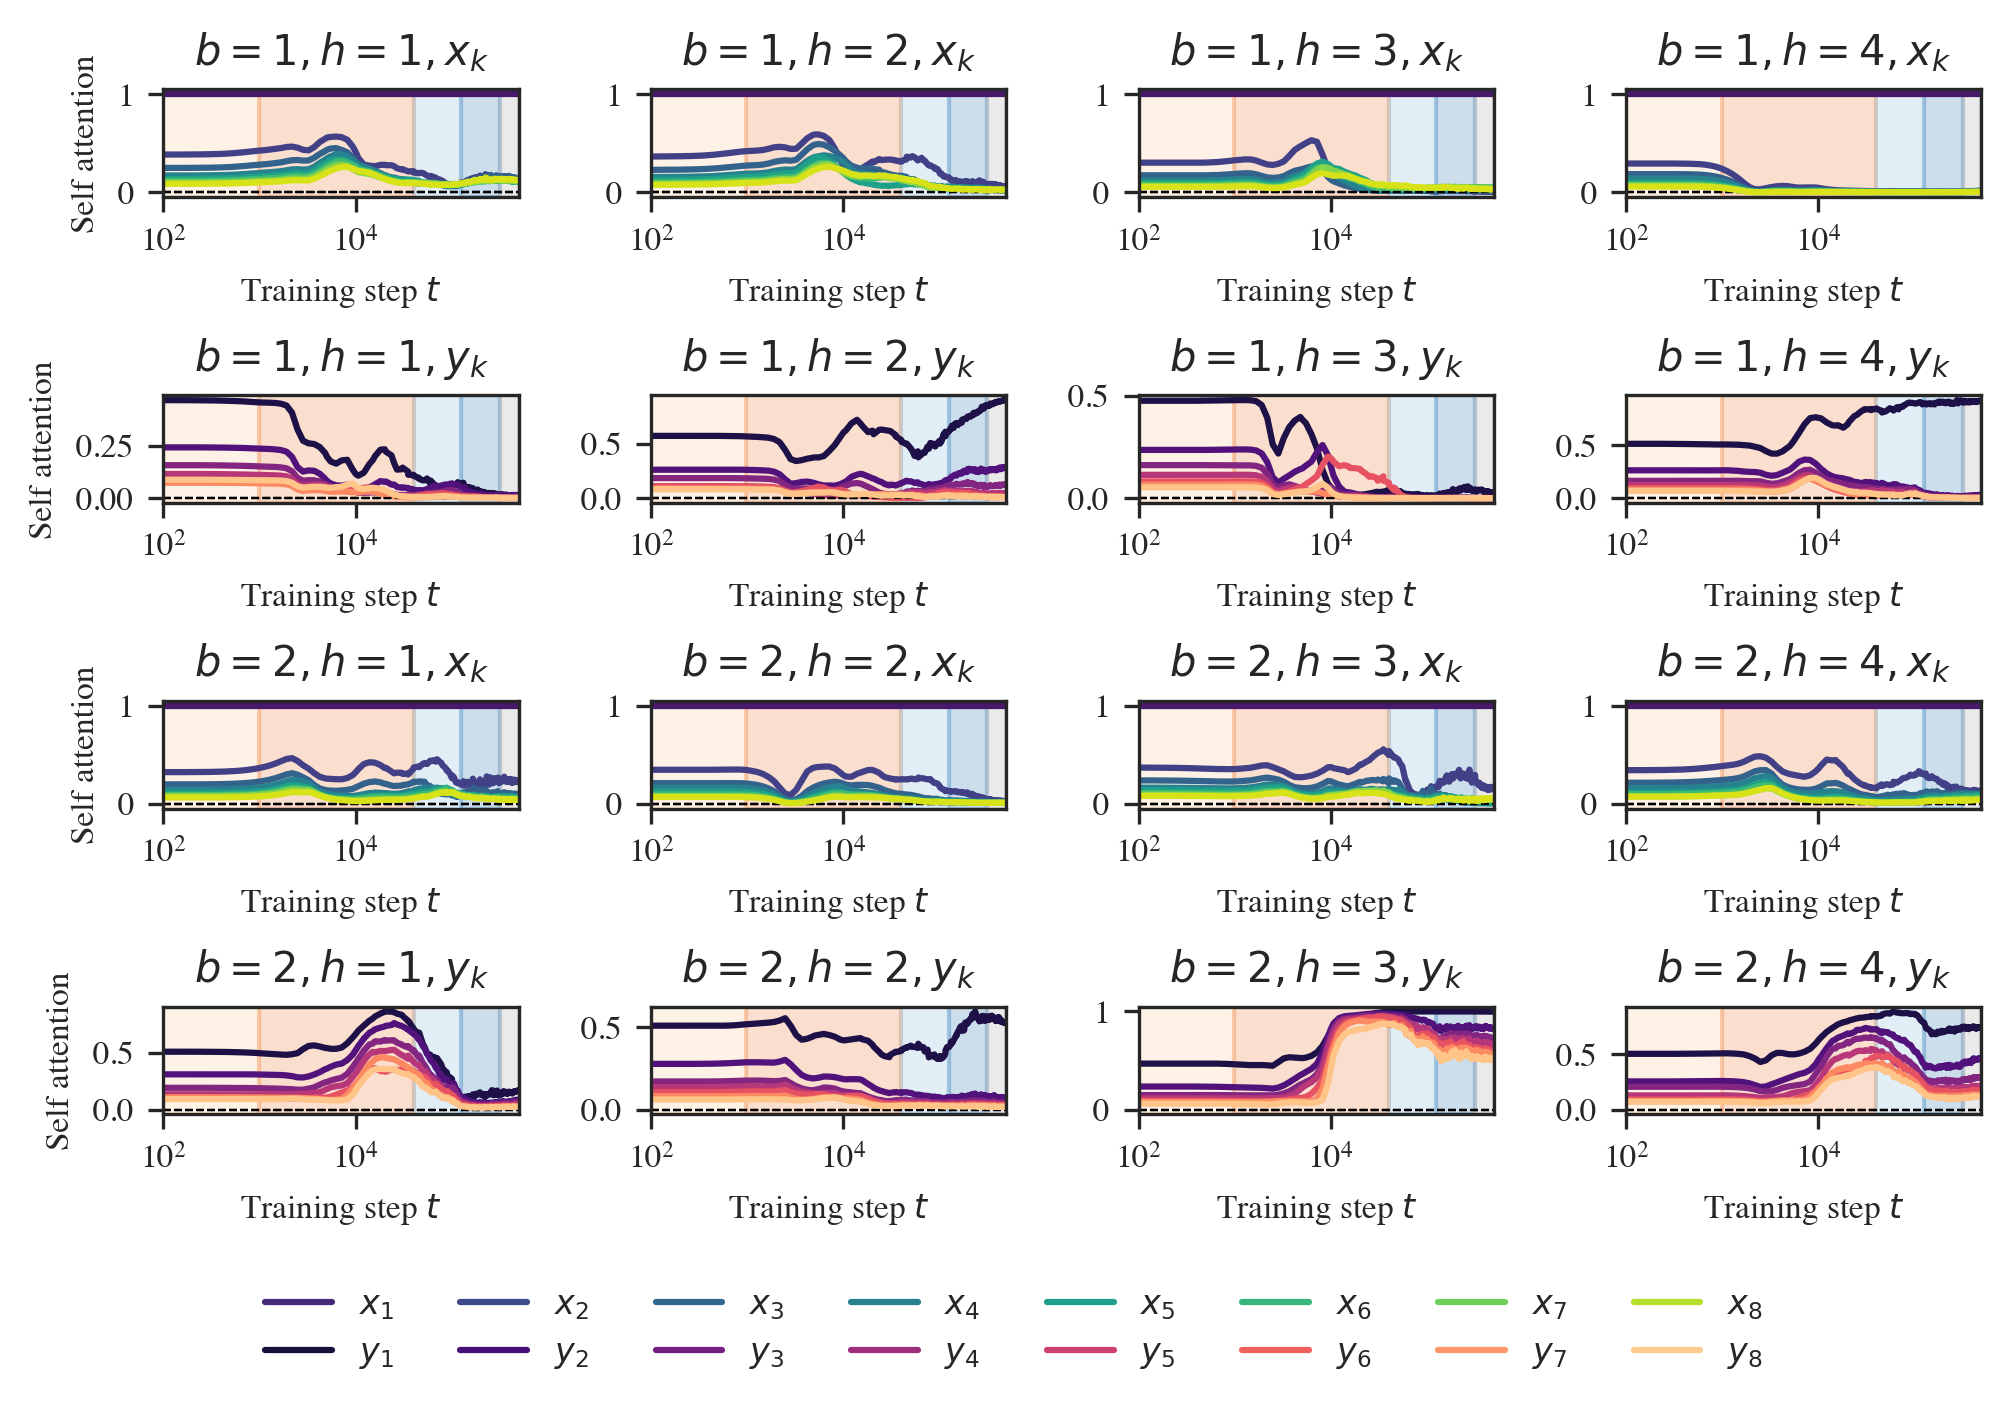

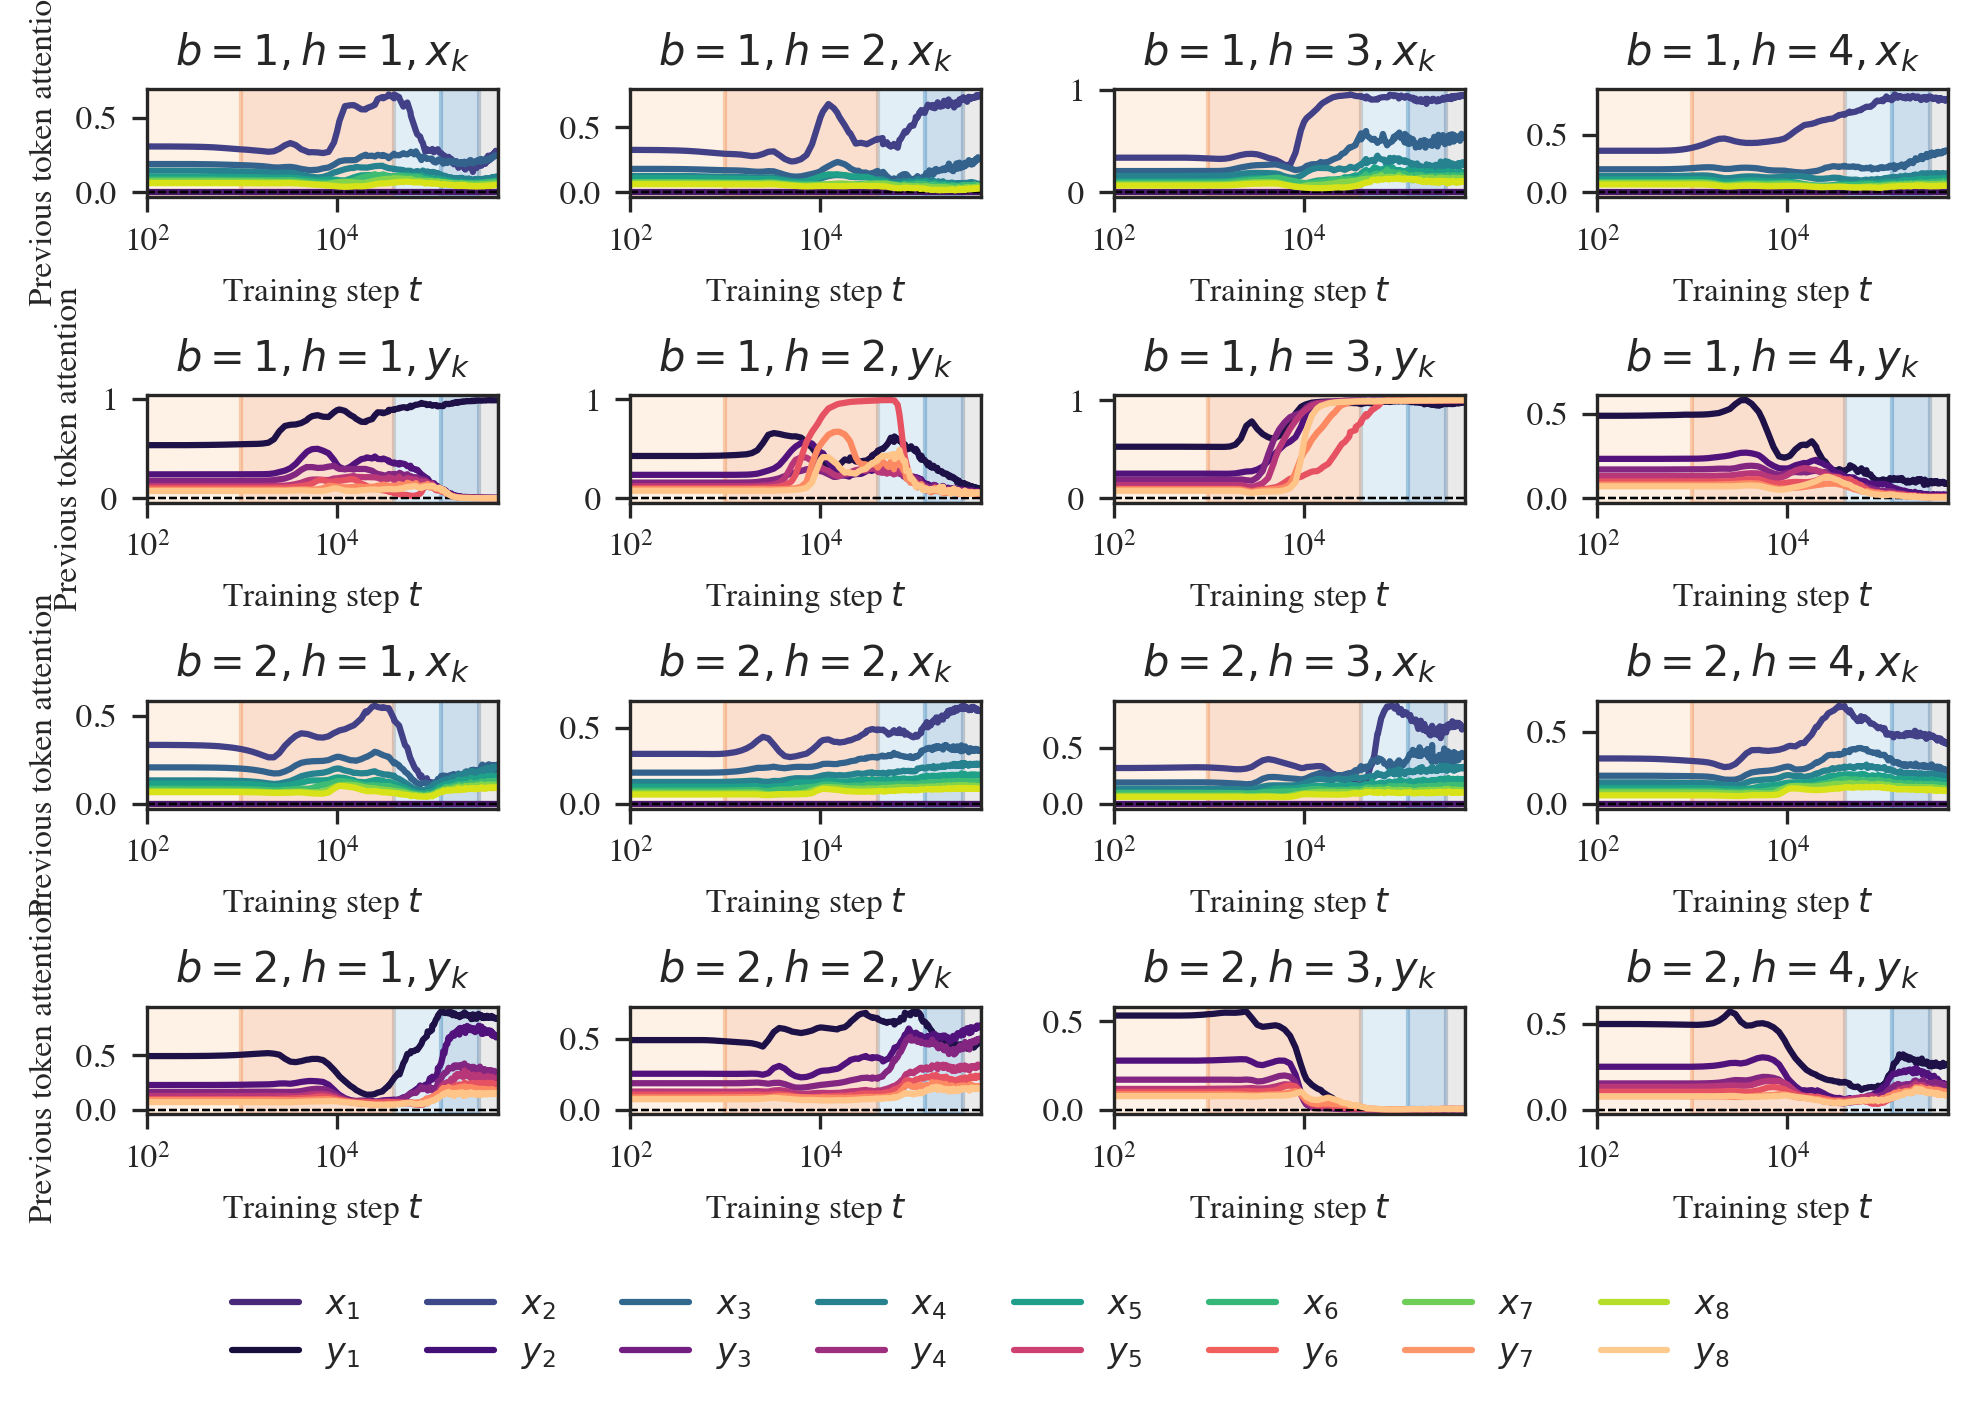

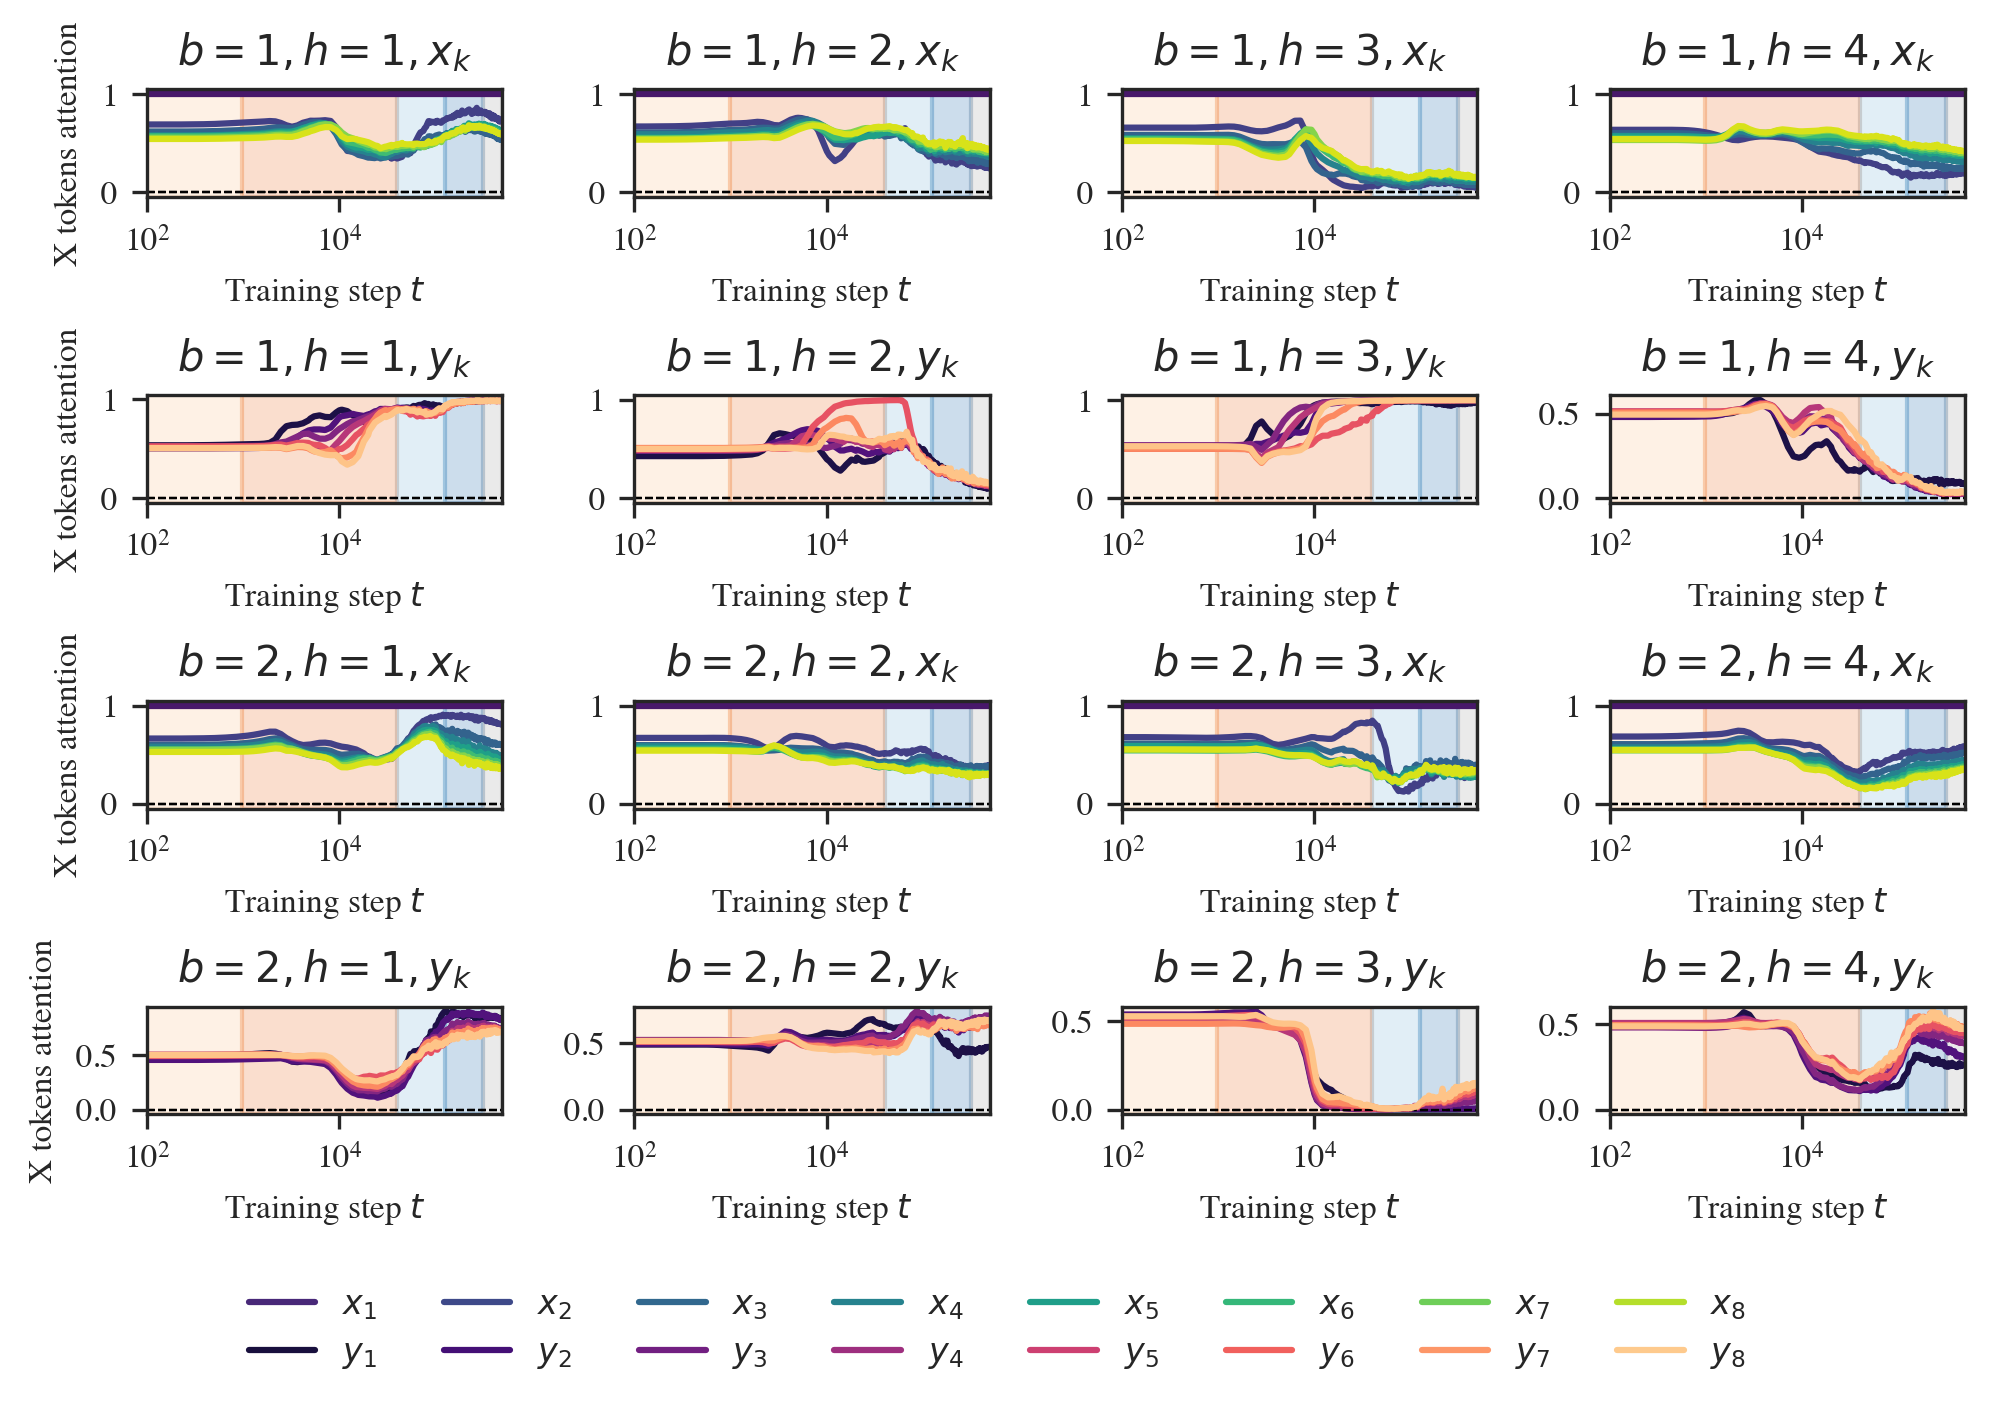

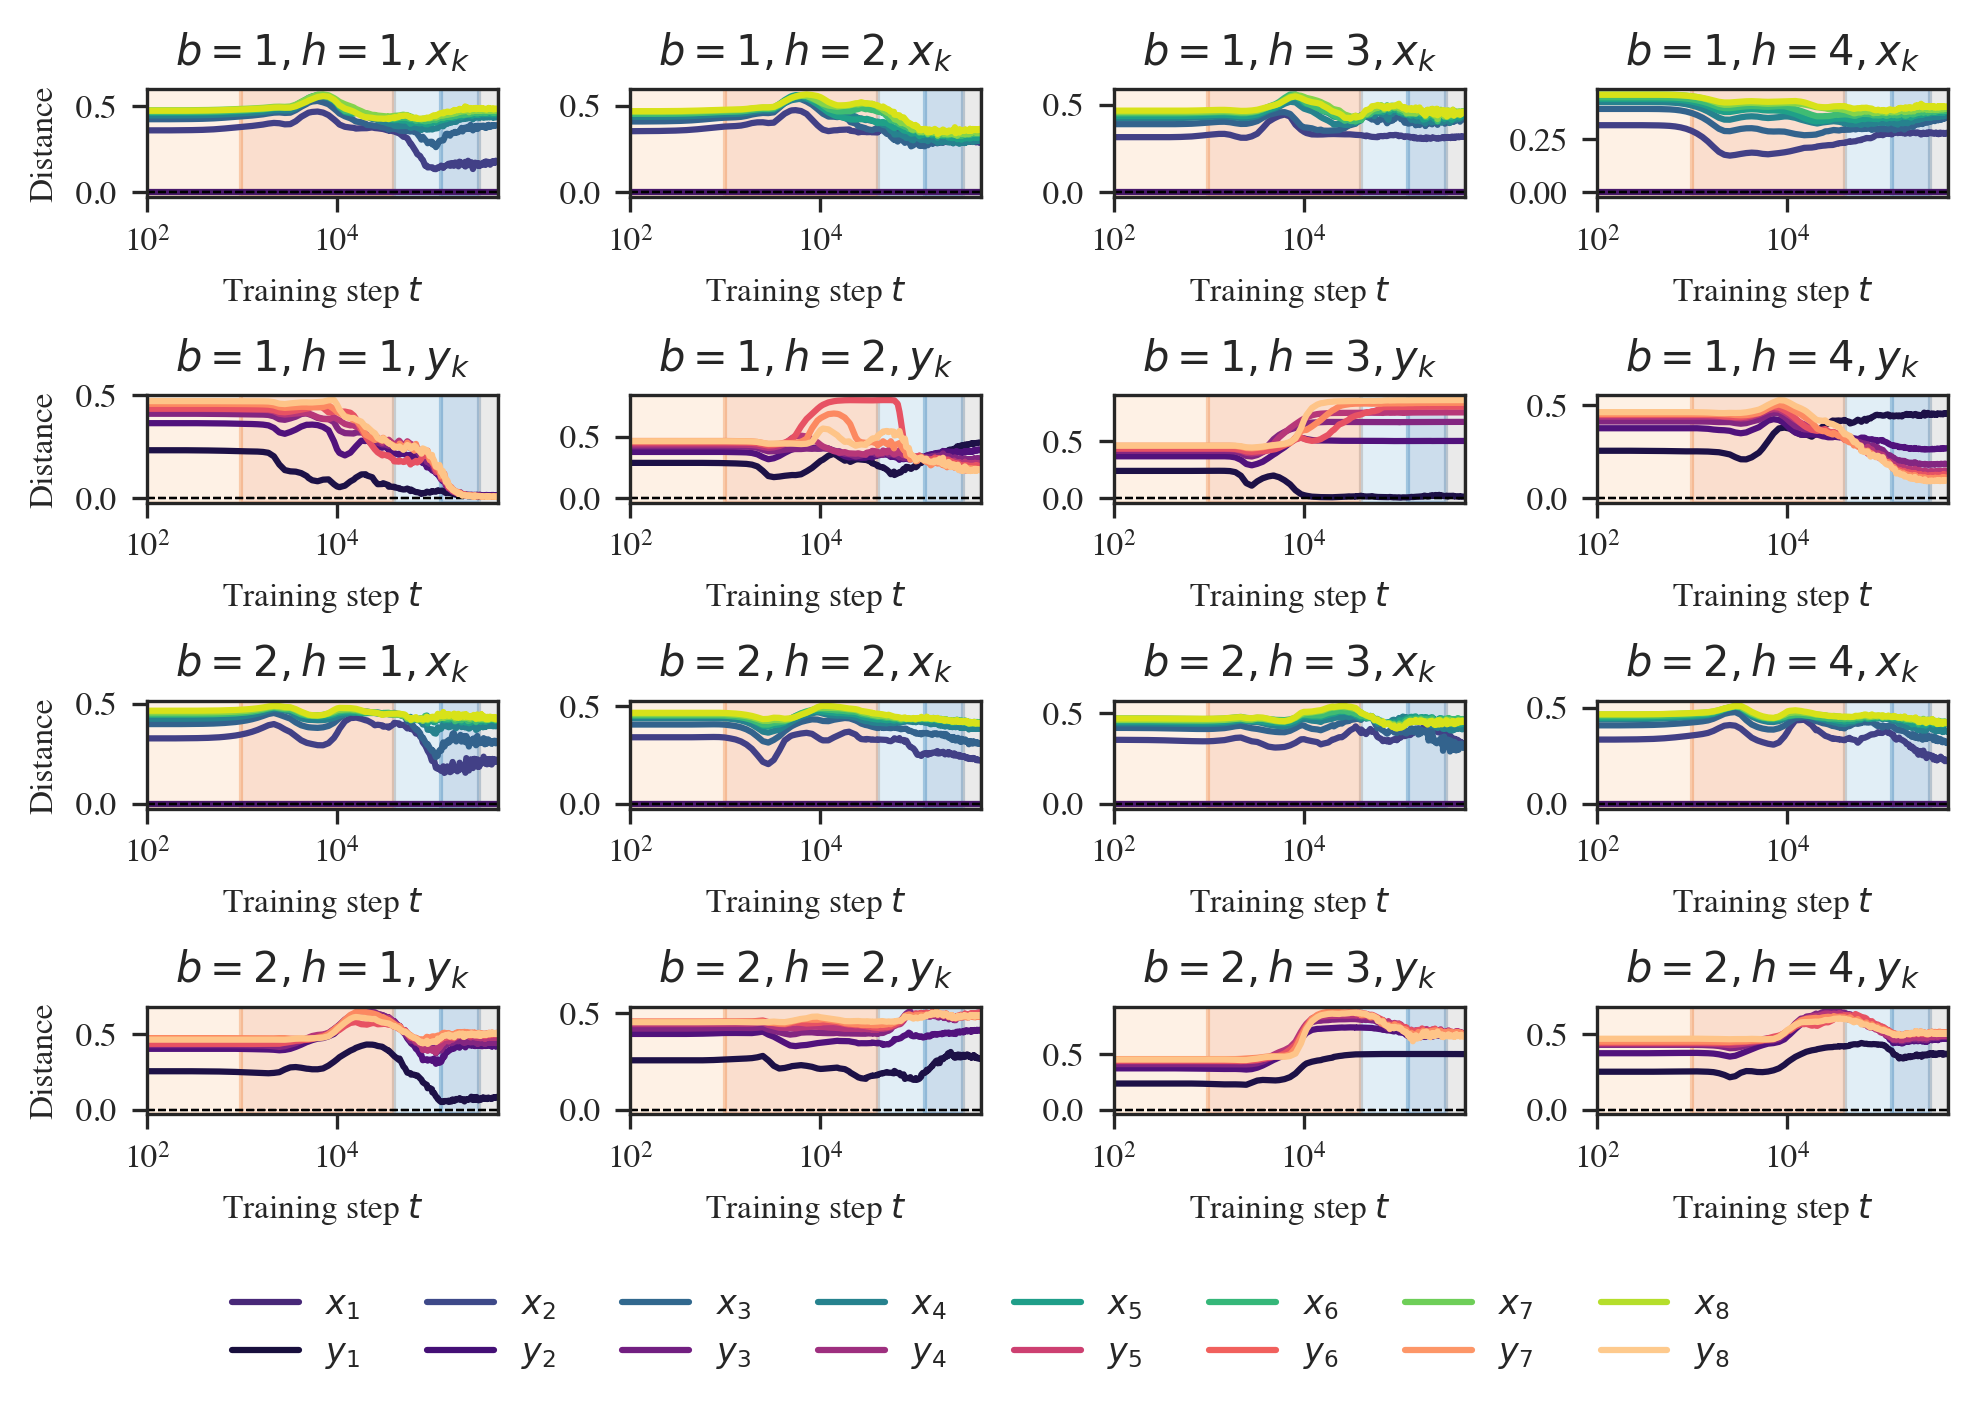

In [237]:
for i, (title, metric) in enumerate(zip(("$\hat{H}_{k}^{(b, h)}$", "$V_{k}^{(b, h)}$", "$D_{k}^{(b, h)}$", "Self attention", "Previous token attention", "X tokens attention", "Distance"), ("entropy_normalized", "variability", "distance", "self_attn", "prev_token_attn", "x_tokens_attn", "distance"))):
    fig, axes = plot_attention_patterns(
        attn_variabilities.loc[attn_variabilities.seed == MODEL_SEED], 
        num_blocks=2, 
        num_heads=4, 
        num_tokens=15, 
        save=False,
        figsize=(FULL_WIDTH, 2.5 * FULL_HEIGHT),
        logx=True,
        metric=metric,
        title=None, # run.config.to_latex(), 
        label=title,
        full_block = False,
        full_head = False,
    )
    # for ax in axes:
    #     ax.set_yscale('log')
    #     ax.set_ylim(10e-4, 1)
        
    fig.savefig(FIGURES / MODEL_ID / f"attn-{metric}.pdf")
    plt.show()
    

# Specific to individual runs

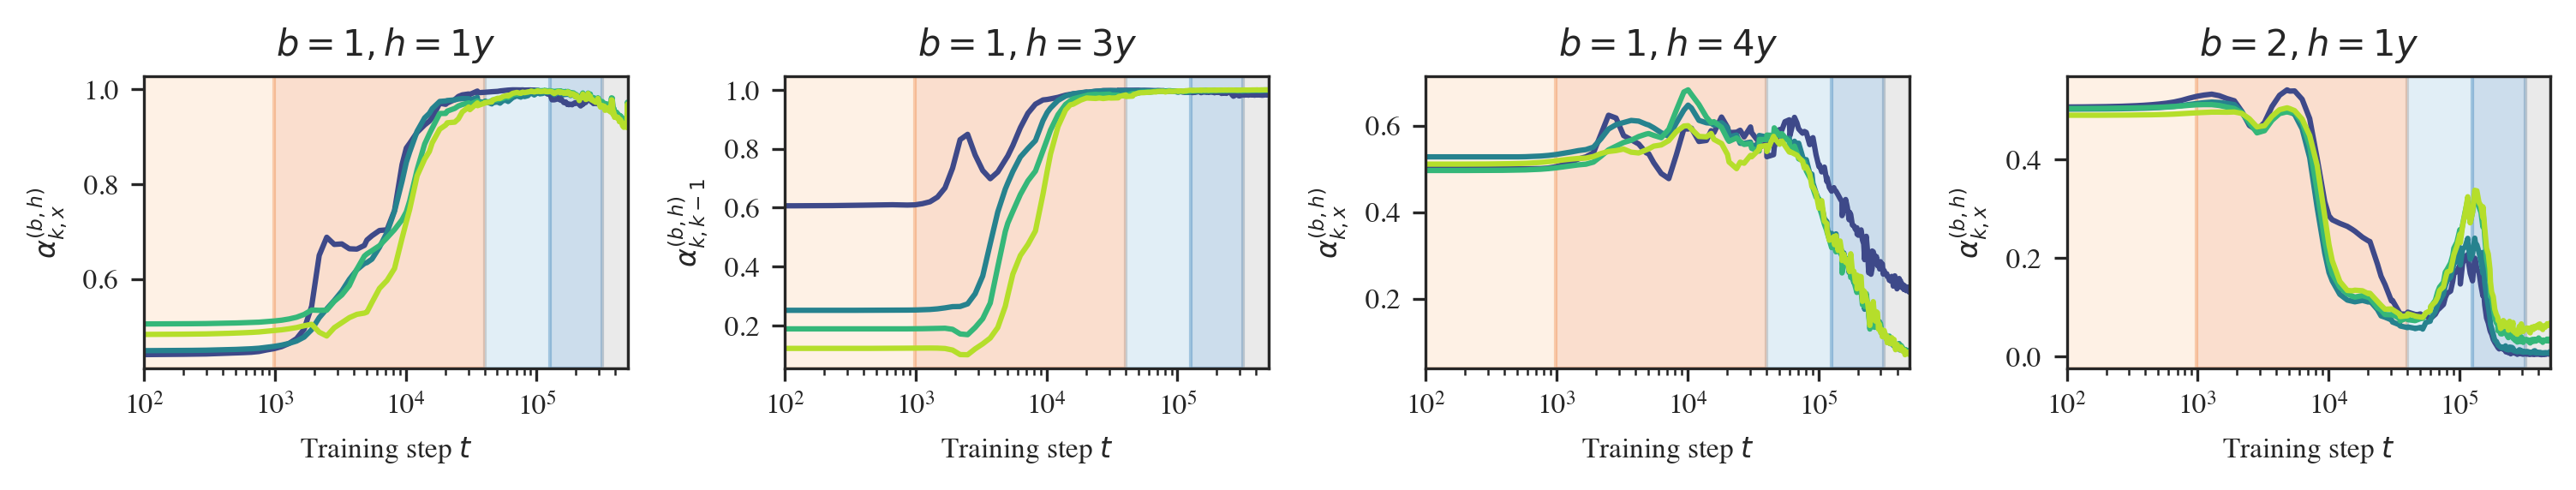

In [238]:
import warnings

metrics_to_labels = {
    "first_x": r"\alpha_{k, 1}^{(b, h)}",
    "first_y": r"\alpha_{k, 2}^{(b, h)}",
    "prev_token_attn": r"\alpha_{k, k-1}^{(b, h)}",
    "previous_x": r"\alpha_{k, y_{k-1}}^{(b, ha)}",
    "previous_y": r"\alpha_{k, x_{k-1}}^{(b, h)}",
    "x_tokens_attn": r"\alpha_{k, x}^{(b, h)}",
    "y_tokens_attn": r"\alpha_{k, y}^{(b, h)}",
    "self_attn": r"\alpha_{k, k}^{(b, h)}",
}

head_metrics = {
    "b1h1y": "x_tokens_attn", # It's attending to x. For first y 100% on previous token. For others 0% on previous token but 100% on x
    "b1h3y": "prev_token_attn",
    "b1h4y": "x_tokens_attn", # Almost a particular one?
    "b2h1y": "x_tokens_attn",
    # "b1h1x": "?",
    # "b1h2x": "?",
    # "b1h2y": "?",
    # "b1h4x": "?",
    # "b2h1x": "?",
    # "b2h1y": "?",
    # "b2h2x": "?",
    # "b2h2y": "?",
    # "b2h3x": "?",
   # "b2h3y": "self_attn", # relaxes in R3
    # "b2h4x": "?",
    # "b2h4y": "?",
}

fig, axes = plt.subplots(1, len(head_metrics), figsize=(FULL_WIDTH * 1.5, FULL_HEIGHT))

df = attn_variabilities.loc[attn_variabilities.seed == 1]
colors = sns.color_palette("viridis", 8)

for i, ((id_, metric), ax) in enumerate(zip(head_metrics.items(), axes)):

    try:
        x_or_y = 1 if id_[4] == "y" else 0
        for token in range(x_or_y, 15, 2):
            ax.plot(df.step, df[f"block_{int(id_[1])-1}/head_{int(id_[3])-1}/token_{token}/{metric}"], color=colors[token])

    except:
        warnings.warn(f"Failed to plot {id_} {metric}")
        
    ax.set_title(f"$b={id_[1]}, h={id_[3:5]}$")
    ax.set_xscale("log")
    ax.set_xlim(100, 500_000)
    ax.set_xlabel("Step $t$")
    ax.set_ylabel(f"${metrics_to_labels[metric]}$")

_plot_transitions(axes)
plt.tight_layout()

fig.savefig(FIGURES / 'L2H4Minf-seed-1' / "attn-ids.pdf")

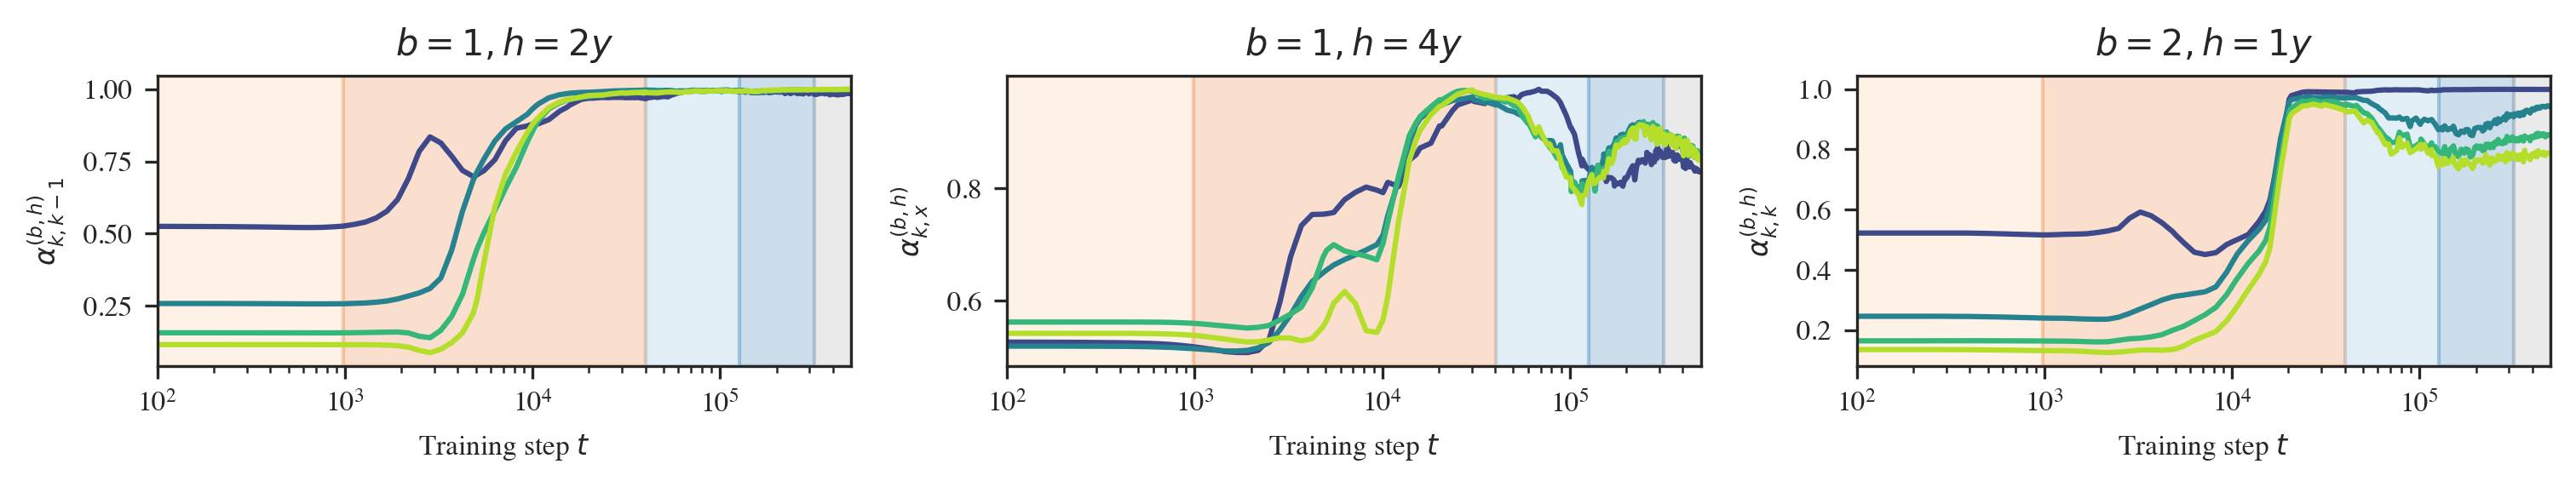

In [204]:
import warnings

metrics_to_labels = {
    "first_x": r"\alpha_{k, 1}^{(b, h)}",
    "first_y": r"\alpha_{k, 2}^{(b, h)}",
    "prev_token_attn": r"\alpha_{k, k-1}^{(b, h)}",
    "previous_x": r"\alpha_{k, y_{k-1}}^{(b, ha)}",
    "previous_y": r"\alpha_{k, x_{k-1}}^{(b, h)}",
    "x_tokens_attn": r"\alpha_{k, x}^{(b, h)}",
    "y_tokens_attn": r"\alpha_{k, y}^{(b, h)}",
    "self_attn": r"\alpha_{k, k}^{(b, h)}",
}

head_metrics = {
    "b1h2y": "prev_token_attn",
    "b1h4y": "x_tokens_attn", # Almost a particular one?
    "b2h1y": "self_attn",
    # "b2h2x": "x_tokens_attn",
    # "b2h1y": "x_tokens_attn", # It's attending to x. For first y 100% on previous token. For others 0% on previous token but 100% on x
    # "b1h1x": "?",
    # "b1h2x": "?",
    # "b1h2y": "?",
    # "b1h4x": "?",
    # "b2h1x": "?",
    # "b2h1y": "?",
    # "b2h2y": "?",
    # "b2h3x": "?",
   # "b2h3y": "self_attn", # relaxes in R3
    # "b2h4x": "?",
    # "b2h4y": "?",
}

fig, axes = plt.subplots(1, len(head_metrics), figsize=(FULL_WIDTH * 1.5, FULL_HEIGHT))

df = attn_variabilities.loc[attn_variabilities.seed == 0]
colors = sns.color_palette("viridis", 8)

for i, ((id_, metric), ax) in enumerate(zip(head_metrics.items(), axes)):

    try:
        x_or_y = 1 if id_[4] == "y" else 0
        for token in range(x_or_y, 15, 2):
            ax.plot(df.step, df[f"block_{int(id_[1])-1}/head_{int(id_[3])-1}/token_{token}/{metric}"], color=colors[token])

    except:
        warnings.warn(f"Failed to plot {id_} {metric}")
        
    ax.set_title(f"$b={id_[1]}, h={id_[3:5]}$")
    ax.set_xscale("log")
    ax.set_xlim(100, 500_000)
    ax.set_xlabel("Step $t$")
    ax.set_ylabel(f"${metrics_to_labels[metric]}$")

_plot_transitions(axes)
plt.tight_layout()

fig.savefig(FIGURES / 'L2H4Minf-seed-0' / "attn-ids.pdf")

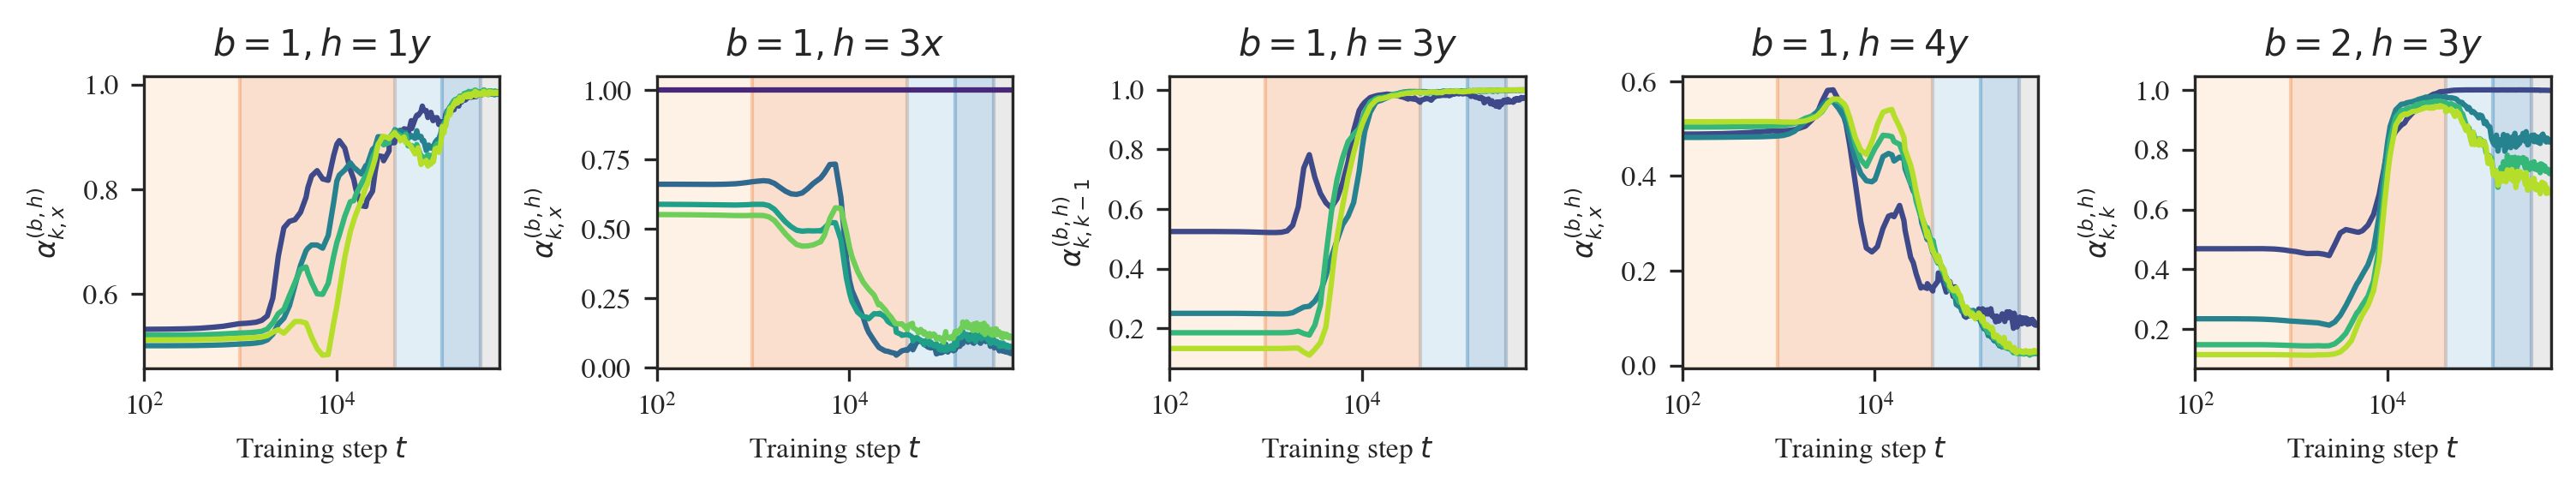

In [205]:
import warnings

metrics_to_labels = {
    "first_x": r"\alpha_{k, 1}^{(b, h)}",
    "first_y": r"\alpha_{k, 2}^{(b, h)}",
    "prev_token_attn": r"\alpha_{k, k-1}^{(b, h)}",
    "previous_x": r"\alpha_{k, y_{k-1}}^{(b, ha)}",
    "previous_y": r"\alpha_{k, x_{k-1}}^{(b, h)}",
    "x_tokens_attn": r"\alpha_{k, x}^{(b, h)}",
    "y_tokens_attn": r"\alpha_{k, y}^{(b, h)}",
    "self_attn": r"\alpha_{k, k}^{(b, h)}",
}

head_metrics = {
    # "b1h1x": "?",
    "b1h1y": "x_tokens_attn", # It's attending to x. For first y 100% on previous token. For others 0% on previous token but 100% on x
    # "b1h2x": "?",
    # "b1h2y": "?",
    "b1h3x": "x_tokens_attn", # Maybe close to uniform?
    "b1h3y": "prev_token_attn",
    # "b1h4x": "?",
    "b1h4y": "x_tokens_attn", # Almost a particular one?
    # "b2h1x": "?",
    # "b2h1y": "?",
    # "b2h2x": "?",
    # "b2h2y": "?",
    # "b2h3x": "?",
    "b2h3y": "self_attn", # relaxes in R3
    # "b2h4x": "?",
    # "b2h4y": "?",
}

fig, axes = plt.subplots(1, len(head_metrics), figsize=(FULL_WIDTH * 1.5, FULL_HEIGHT))

df = attn_variabilities.loc[attn_variabilities.seed == 4]
colors = sns.color_palette("viridis", 8)

for i, ((id_, metric), ax) in enumerate(zip(head_metrics.items(), axes)):

    try:
        x_or_y = 1 if id_[4] == "y" else 0
        for token in range(x_or_y, 15, 2):
            ax.plot(df.step, df[f"block_{int(id_[1])-1}/head_{int(id_[3])-1}/token_{token}/{metric}"], color=colors[token])

    except:
        warnings.warn(f"Failed to plot {id_} {metric}")
        
    ax.set_title(f"$b={id_[1]}, h={id_[3:5]}$")
    ax.set_xscale("log")
    ax.set_xlim(100, 500_000)
    ax.set_xlabel("Step $t$")
    ax.set_ylabel(f"${metrics_to_labels[metric]}$")

_plot_transitions(axes)
plt.tight_layout()

fig.savefig(FIGURES / 'L2H4Minf-seed-4' / "attn-ids.pdf")